In [1]:
import tensorflow as tf
import datetime, os
#hide tf logs 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'} 
#0 (default) shows all, 1 to filter out INFO logs, 2 to additionally filter out WARNING logs, and 3 to additionally filter out ERROR logs
import scipy.optimize
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import seaborn as sns 
import codecs, json
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error 

# generates same random numbers each time
np.random.seed(1233)
tf.random.set_seed(1233)

print("TensorFlow version: {}".format(tf.__version__))

TensorFlow version: 2.9.1


# *Data Prep*

Training and Testing data is prepared from the solution file

In [2]:
## Data Import
K_real = np.load('./K_tx_real_d_one.npy') # Values of K(t,x)
Q_real = np.load('./Q_15minutes.npy') # Input Matrix of Model
f_real = Q_real[:,1] # Inflow Rate
v_real = Q_real[:,3] # Average Speed
pi_real = np.load('./pitilde_15minutes.npy') # Values of pi(t,x)

In [3]:
pi_real.shape

(150, 2016)

Text(0, 0.5, 'Remaining Trip Distance (miles)')

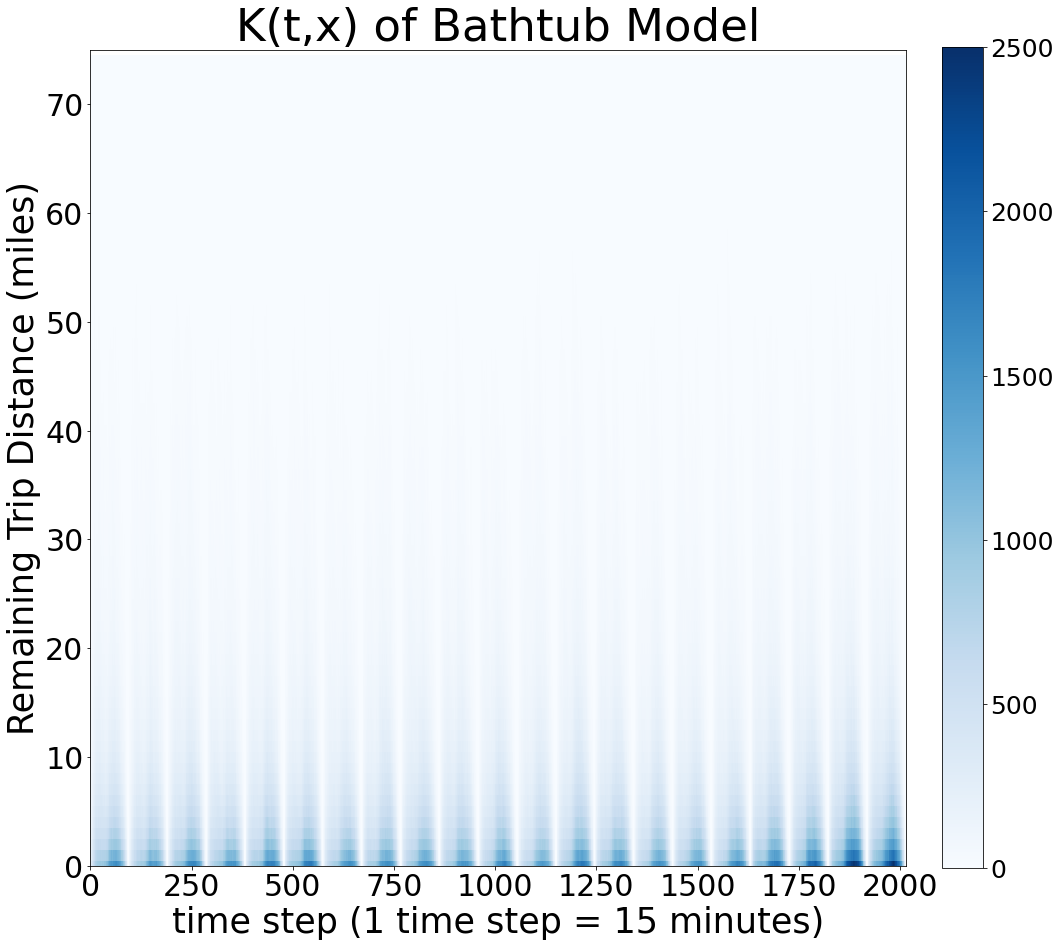

In [4]:
K_array = np.array(K_real[:,0:len(K_real[0])])
fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.T, cmap = 'Blues', interpolation='nearest')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,len(K_real[0])])
plt.clim(0, 2500) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title('K(t,x) of Bathtub Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (miles)', fontsize=35)

In [5]:
## Scale
N_timestep = 24*21*4 # 24 hours * 21 days * 15 minutes = total timestep
N_diststep = 75 # 1 distance step = 1 mile
Size_diststep = 1 # unit: miles
N_trainingdays = 0 # Set zero (0)
N_training = 24*4*N_trainingdays # Training data is all


## Normalization [0,1]
x = np.arange(0,int(N_diststep/Size_diststep))[:,None]   # x: step of remaining distance
t = np.arange(0,N_timestep)[:,None]    # Time step 
usol = K_real.transpose() [:,N_training:]     # real value of K(t,x) ==> Target Variable
usol_max = usol.max()

## Normalization [0,1]
x = (x - x.min()) / (x.max() - x.min())
t = (t - t.min()) / (t.max() - t.min())
f_real = (f_real - usol.min()) / (usol.max() - usol.min())  # usol과 같은 dimension이어야 함. 단위 같기 때문.
v_real = (v_real - v_real.min()) / (v_real.max() - v_real.min())
usol = (usol - usol.min()) / (usol.max()-usol.min())

X, T = np.meshgrid(x,t)                     # makes 2 arrays X and T such that u(X[i],T[j])=usol[i][j] are a tuple


multiplier_dist = int(N_diststep/Size_diststep)-1
multiplier_time = N_timestep-1
multiplier_u = usol_max
print('multiplier distance = ', multiplier_dist)
print('multiplier time = ', multiplier_time)
print('usol max = ', usol_max)

multiplier distance =  74
multiplier time =  2015
usol max =  2500


In [6]:
Size_diststep = 15 # unit: miles
size_input = int(N_diststep/Size_diststep)*N_timestep # Total number of grid points
# size_input = int(N_diststep/Size_diststep)*2 + N_timestep*7 # Boundary
N_u = int(size_input*0.2) # Total number of data points for 'u' ==> Training data from grid points
N_f = N_u*2 #Total number of collocation (auxiliary) points 
alpha = 0.5 # weights of loss

print('size input = ', size_input)
print('N_u = ', N_u)
print('N_f = ', N_f)

size input =  10080
N_u =  2016
N_f =  4032


In [7]:
# # Previous version (before Aug 30)
# size_input = int(N_diststep/Size_diststep)*N_timestep # All domain
# # size_input = int(N_diststep/Size_diststep)*2 + N_timestep*7 # Boundary
# N_u = int(size_input*0.5) #Total number of data points for 'u'
# N_f = N_u*2 #Total number of collocation points 
# alpha = 0.5

# print('size input = ', size_input)
# print('N_u = ', N_u)
# print('N_f = ', N_f)

# *Grid Data*

We prepare the grid data to compare against the solution produced by the PINN.

In [8]:
''' X_u_test = [X[i],T[i]] [25600,2] for interpolation'''
X_u_grid = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))

# Domain bounds
lb = X_u_grid[0]  # [-1. 0.]
ub = X_u_grid[-1] # [1.  0.99]

'''
   Fortran Style ('F') flatten,stacked column wise!
   u = [c1 
        c2
        .
        .
        cn]

   u =  [25600x1] 
'''
u_grid = usol.flatten('F')[:,None] 

# *Training Data* (All domain)


The boundary conditions serve as the test data for the PINN and the collocation points are generated using **Latin Hypercube Sampling**

In [9]:
def trainingdata(N_u,N_f):

#     '''Boundary Conditions'''

#     #Initial Condition 0 =< x =< 9 (135 miles) and t = 0  
#     leftedge_x = np.hstack((X[0,:][:,None], T[0,:][:,None])) #L1
#     leftedge_u = usol[:,0][:,None]
    
#     #Initial Condition 0 =< x =< 9 (135 miles) and t = 2015  
#     rightedge_x = np.hstack((X[0,:][:,None], T[-1,:][:,None])) #L1
#     rightedge_u = usol[:,-1][:,None]

#     #Boundary Condition x = 9 (135 miles) and 0 =< t =<2015
#     topedge_x = np.hstack((X[:,-1][:,None], T[:,0][:,None])) #L3
#     topedge_u = usol[-1,:][:,None]
        
#     #Boundary Condition x = 0 and 0 =< t =<2015
#     bottomedge_x = np.hstack((X[:,0][:,None], T[:,0][:,None])) #L2
#     bottomedge_u = usol[0,:][:,None]
    
#     #Boundary Condition x = 5 (25 miles) and 0 =< t =<2015
#     midedge_x = np.hstack((X[:,5][:,None], T[:,0][:,None])) #L3
#     midedge_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 10 (50 miles) and 0 =< t =<2015
#     midedge1_x = np.hstack((X[:,10][:,None], T[:,0][:,None])) #L3
#     midedge1_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 15 (75 miles) and 0 =< t =<2015
#     midedge2_x = np.hstack((X[:,15][:,None], T[:,0][:,None])) #L3
#     midedge2_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 20 (100 miles) and 0 =< t =<2015
#     midedge3_x = np.hstack((X[:,20][:,None], T[:,0][:,None])) #L3
#     midedge3_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 25 (125 miles) and 0 =< t =<2015
#     midedge4_x = np.hstack((X[:,25][:,None], T[:,0][:,None])) #L3
#     midedge4_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 2 and 0 =< t =<2015
#     bottomedge_x_2 = np.hstack((X[:,1][:,None], T[:,0][:,None])) #L2
#     bottomedge_u_2 = usol[2,:][:,None]
    
#     #Boundary Condition x = 1 and 0 =< t =<2015
#     bottomedge_x_1 = np.hstack((X[:,1][:,None], T[:,0][:,None])) #L2
#     bottomedge_u_1 = usol[1,:][:,None]


#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x, midedge_x, midedge1_x, midedge2_x, midedge3_x, midedge4_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u, midedge_u, midedge1_u, midedge2_u, midedge3_u, midedge4_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x, midedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u, midedge_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([bottomedge_x, bottomedge_x_1, bottomedge_x_2]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([bottomedge_u, bottomedge_u_1, bottomedge_u_2])   #corresponding u [4042,]
    
#     all_X_u_train = np.vstack([bottomedge_x, topedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([bottomedge_u, topedge_u])   #corresponding u [4042,]

    all_X_u_train = np.hstack((X.T[range(0,N_diststep,Size_diststep)].flatten()[:,None],T.T[range(0,N_diststep,Size_diststep)].flatten()[:,None]))
    all_u_train = usol[range(0,N_diststep,Size_diststep)].flatten()[:,None]
    
    #choose random N_u points for training
    np.random.seed(1233)
    train_idx = np.random.choice(all_X_u_train.shape[0], N_u, replace=False) # ID of training data
    test_idx = np.delete(np.arange(size_input), train_idx) # ID of testing data
    
    # Training Data
    X_u_train = all_X_u_train[train_idx, :] #choose indices from  set 'idx' (x,t)
    u_train = all_u_train[train_idx,:]      #choose corresponding u
    
    # Testing Data
    X_u_test = all_X_u_train[test_idx, :]
    u_test = all_u_train[test_idx,:]

    '''Collocation Points'''

    # Latin Hypercube sampling for collocation points 
    # N_f sets of tuples(x,t)
#     X_f_train = np.rint(lb + (ub-lb)*lhs(2,N_f))
    X_f_train = (lb + (ub-lb)*lhs(2,N_f))
#     X_f_train = np.unique(X_f_train, axis=0).astype(int) # 중복된 것 없앰
    X_f_train = np.vstack((X_f_train, X_u_train)) # append training points to collocation points 
    
    f_t = f_real[np.int0(X_f_train*multiplier_time)[:,1]][:,None]
    pi_tx = pi_real[np.int0(X_f_train*multiplier_dist)[:,0],np.int0(X_f_train*multiplier_time)[:,1]][:,None]
    v_t = v_real[np.int0(X_f_train*multiplier_time)[:,1]][:,None]

    return X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx

In [10]:
X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx  = trainingdata(N_u,N_f)

In [11]:
X_u_train.shape

(2016, 2)

In [12]:
X_u_test.shape

(8064, 2)

In [13]:
X_u_train

array([[0.81081081, 0.55434243],
       [0.2027027 , 0.71960298],
       [0.        , 0.01588089],
       ...,
       [0.        , 0.27047146],
       [0.81081081, 0.49875931],
       [0.        , 0.70421836]])

# **PINN**

Generate a **PINN** of L hidden layers, each with n neurons. 

Initialization: ***Xavier***

Activation: *tanh (x)*

In [14]:
class Sequentialmodel(tf.Module): 
    def __init__(self, layers, name=None):
       
        self.W = []  #Weights and biases
        self.parameters = 0 #total number of parameters
        
        for i in range(len(layers)-1):
            
            input_dim = layers[i]
            output_dim = layers[i+1]
            
            #Xavier standard deviation 
            std_dv = np.sqrt((2.0/(input_dim + output_dim)))

            #weights = normal distribution * Xavier standard deviation + 0
            w = tf.random.normal([input_dim, output_dim], dtype = 'float64') * std_dv
                       
            w = tf.Variable(w, trainable=True, name = 'w' + str(i+1))

            b = tf.Variable(tf.cast(tf.zeros([output_dim]), dtype = 'float64'), trainable = True, name = 'b' + str(i+1))
                    
            self.W.append(w)
            self.W.append(b)
            
            self.parameters +=  input_dim * output_dim + output_dim
    
    def evaluate(self,x):
        
        x = (x-lb)/(ub-lb)
        
        a = x
        
        for i in range(len(layers)-2):
            
            z = tf.add(tf.matmul(a, self.W[2*i]), self.W[2*i+1])
            a = tf.nn.tanh(z)
            
        a = tf.add(tf.matmul(a, self.W[-2]), self.W[-1]) # For regression, no activation to last layer
        return a
    
#     def speed(self,x):
        
#         a = tf.math.minimum(u_free, tf.abs(a_speed/x + b_speed))

#         print('speed = ', a)
#         print('k = ', x)

#         return a
    
    def get_weights(self):

        parameters_1d = []  # [.... W_i,b_i.....  ] 1d array
        
        for i in range (len(layers)-1):
            
            w_1d = tf.reshape(self.W[2*i],[-1])   #flatten weights 
            b_1d = tf.reshape(self.W[2*i+1],[-1]) #flatten biases
            
            parameters_1d = tf.concat([parameters_1d, w_1d], 0) #concat weights 
            parameters_1d = tf.concat([parameters_1d, b_1d], 0) #concat biases
        
        return parameters_1d
        
    def set_weights(self,parameters):
                
        for i in range (len(layers)-1):

            shape_w = tf.shape(self.W[2*i]).numpy() # shape of the weight tensor
            size_w = tf.size(self.W[2*i]).numpy() #size of the weight tensor 
            
            shape_b = tf.shape(self.W[2*i+1]).numpy() # shape of the bias tensor
            size_b = tf.size(self.W[2*i+1]).numpy() #size of the bias tensor 
                        
            pick_w = parameters[0:size_w] #pick the weights 
            self.W[2*i].assign(tf.reshape(pick_w,shape_w)) # assign  
            parameters = np.delete(parameters,np.arange(size_w),0) #delete 
            
            pick_b = parameters[0:size_b] #pick the biases 
            self.W[2*i+1].assign(tf.reshape(pick_b,shape_b)) # assign 
            parameters = np.delete(parameters,np.arange(size_b),0) #delete 

            
    # Loss of data discrepancy
    def loss_BC(self,x,y):

        loss_u = tf.reduce_mean(tf.square(y-self.evaluate(x)))
        return loss_u

    # Loss of physics
    def loss_PDE(self, x_to_train_f, f_t, pi_tx, v_t):
    
        g = tf.Variable(x_to_train_f, dtype = 'float64', trainable = False)
        ft = tf.Variable(f_t,dtype = 'float64', trainable = False)
        pitx = tf.Variable(pi_tx,dtype = 'float64', trainable = False)
        vt = tf.Variable(v_t,dtype = 'float64', trainable = False)
    
        x_f = g[:,0:1]
        t_f = g[:,1:2]

        with tf.GradientTape(persistent=True) as tape:

            tape.watch(x_f)
            tape.watch(t_f)

            g = tf.stack([x_f[:,0], t_f[:,0]], axis=1)   

            z = self.evaluate(g)
            u_x = tape.gradient(z,x_f)

        u_t = tape.gradient(z,t_f)
        
        del tape

        f = u_t - vt*(u_x) - tf.multiply(ft, pitx)
        loss_f = tf.reduce_mean(tf.square(f))

        return loss_f
    
    # total loss
    def loss(self,x,y,g,h,i,k,alpha):

        loss_u = self.loss_BC(x,y)
        loss_f = self.loss_PDE(g,h,i,k)

        loss = alpha*loss_u + (1-alpha)*loss_f

        return loss, loss_u, loss_f
    
    def optimizerfunc(self,parameters):
        
        self.set_weights(parameters)
       
        with tf.GradientTape() as tape:
            tape.watch(self.trainable_variables)
            
            loss_val, loss_u, loss_f = self.loss(X_u_train, u_train, X_f_train, f_t, pi_tx, v_t, alpha)
            
        grads = tape.gradient(loss_val,self.trainable_variables)
                
        del tape
        
        grads_1d = [ ] #flatten grads 
        
        for i in range (len(layers)-1):

            grads_w_1d = tf.reshape(grads[2*i],[-1]) #flatten weights 
            grads_b_1d = tf.reshape(grads[2*i+1],[-1]) #flatten biases

            grads_1d = tf.concat([grads_1d, grads_w_1d], 0) #concat grad_weights 
            grads_1d = tf.concat([grads_1d, grads_b_1d], 0) #concat grad_biases

        return loss_val.numpy(), grads_1d.numpy()
    
    def optimizer_callback(self,parameters):
               
        loss_value, loss_u, loss_f = self.loss(X_u_train, u_train, X_f_train, f_t, pi_tx, v_t, alpha)
        
        u_pred = self.evaluate(X_u_test)
        error_vec = np.linalg.norm((u_test-u_pred),2)/np.linalg.norm(u_test,2)
        loss_record.append(loss_value)
        l2_record.append(error_vec)
        tf.print(loss_value, loss_u, loss_f, error_vec)
        

# *Model Training and Testing*

A function '**model**' is defined to generate a NN as per the input set of hyperparameters, which is then trained and tested. The L2 Norm of the solution error is returned as a comparison metric

In [15]:
# Training data
X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx  = trainingdata(N_u,N_f)
#alpha = int(N_f/N_u) #weight of loss function

layers = np.array([2,20,20,20,20,20,20,20,20,1]) #8 hidden layers
loss_record = []
l2_record = []

PINN = Sequentialmodel(layers)

init_params = PINN.get_weights().numpy()

start_time = time.time() 

# train the model with Scipy L-BFGS optimizer
results = scipy.optimize.minimize(fun = PINN.optimizerfunc, 
                                  x0 = init_params, 
                                  args=(), 
                                  method='L-BFGS-B', 
                                  jac= True,        # If jac is True, fun is assumed to return the gradient along with the objective function
                                  callback = PINN.optimizer_callback, 
                                  options = {'disp': None,
                                            'maxcor': 100, 
                                            'ftol': 1 * np.finfo(float).eps,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
#                                             'ftol': 1e-10,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
                                            'gtol': 1e-10, 
                                            'maxfun':  50000, 
                                            'maxiter': 15000,
                                            'iprint': -1,   #print update every 50 iterations
                                            'maxls': 50})
end_time = time.time()

0.016131413398415305 0.0306904785436019 0.0015723482532287098 0.8153468129992503
0.015362570728139692 0.029862255470439625 0.00086288598583975844 0.8043688844399952
0.01331632977734859 0.025585911719833109 0.0010467478348640696 0.7439871277432983
0.012293362621416887 0.022955804517601118 0.0016309207252326577 0.7033315314585158
0.010996760401487001 0.020652383696162069 0.0013411371068119324 0.6634987441742926
0.010944975706907674 0.020693744884602547 0.0011962065292128014 0.6642583109452582
0.01091617333528804 0.020700630240996019 0.0011317164295800606 0.6643100488905123
0.010851730971268618 0.020652924296538845 0.0010505376459983915 0.6634432110361598
0.010708986210341406 0.0204568105159895 0.00096116190469331265 0.660004893276678
0.010531860322131692 0.020160320966790428 0.00090339967747295386 0.6548029217907063
0.010249520926960196 0.019680410016623111 0.00081863183729728034 0.6467093352681929
0.0097627080696680545 0.018823059541156546 0.00070235659817956329 0.6336376534934006
0.009

0.0057925677509134384 0.0097667884840294834 0.0018183470177973932 0.44609795600589225
0.0057921441610093464 0.0097646805973761082 0.0018196077246425842 0.4460644143687763
0.0057918518834924318 0.0097629061101467268 0.0018207976568381367 0.4460295415454719
0.005791506655807856 0.0097627066025237023 0.0018203067090920093 0.44606399109985906
0.0057912298654434462 0.009764789909308234 0.0018176698215786576 0.44611376576649986
0.0057904214388335351 0.00976793529632004 0.0018129075813470307 0.4461788298458835
0.0057891315896764408 0.0097728479892886418 0.0018054151900642407 0.4462403023005693
0.0057883573323159812 0.0097677653408838 0.0018089493237481624 0.4460817610900755
0.0057868845455419414 0.0097557418400361848 0.0018180272510476985 0.4457326440835193
0.0057833573238379385 0.0097500250935087917 0.0018166895541670844 0.4456787101050756
0.00577820786429997 0.00970264748764746 0.0018537682409524789 0.4443256208568242
0.0057746586009563882 0.0097147898256854937 0.001834527376227282 0.444548

0.0053530656778968989 0.0094424631566828853 0.0012636681991109128 0.4374999980987778
0.0053503112420676758 0.0094561087838093052 0.0012445137003260468 0.4378801377978053
0.005347189673017335 0.0094551217186628241 0.0012392576273718451 0.43782374722674966
0.0053428325109114638 0.0094898339289905959 0.0011958310928323324 0.43874606861964194
0.0053350383861756785 0.00948208356931277 0.0011879932030385881 0.43857660492044154
0.005319352432789028 0.00944097930564956 0.0011977255599284952 0.43736208329843423
0.0053130240283756486 0.0094298999750402832 0.0011961480817110131 0.43715548434100243
0.0053091662604759747 0.00941800117208437 0.0012003313488675805 0.43678102394743856
0.0053071590727017566 0.0094235393754115888 0.0011907787699919246 0.43691978578752355
0.0053063686578496234 0.0094095134138033245 0.0012032239018959225 0.4365262080733894
0.0053057359019758861 0.0094077455140500442 0.0012037262899017285 0.43648065385015833
0.0053044191783881579 0.0094075679385557456 0.0012012704182205697

0.0051109763498511937 0.0092534372284107033 0.00096851547129168426 0.43202091926715064
0.0051105472024167145 0.00925198834899493 0.0009691060558384998 0.4318788068595851
0.0051097708250439251 0.0092547293752755552 0.00096481227481229543 0.4319774161440226
0.0051076021043376029 0.00925683852720421 0.00095836568147099517 0.43213126012500663
0.0051042089693705064 0.0092562499900843039 0.00095216794865670925 0.4321862662970095
0.0050989456608438117 0.0092623769967285566 0.00093551432495906674 0.4324048395814499
0.0050937485039664 0.0092643198706291782 0.0009231771373036221 0.4325295189298983
0.0050905751503292048 0.0092855531817184964 0.00089559711893991308 0.4332219961984029
0.0050843245589747487 0.0092687322696197883 0.00089991684832970982 0.4323345613257768
0.0050785245917807729 0.0092562747858550287 0.00090077439770651639 0.4318446975773608
0.0050743143672390724 0.0092664247325793016 0.0008822040018988431 0.43246417163922307
0.0050699035239119075 0.0092613056290777509 0.000878501418746

0.0047336577059946695 0.0092271343648146157 0.0002401810471747241 0.4304112606310525
0.0047332807240316821 0.009230476831529 0.00023608461653436472 0.43049834273978105
0.0047329837831220252 0.00923165289650748 0.0002343146697365706 0.43055392634383716
0.0047326383570715572 0.0092306629938734338 0.00023461372026968059 0.4305282837613617
0.0047321574054264336 0.0092286345815152018 0.00023568022933766623 0.43049835187290164
0.0047318669102771865 0.0092291007756965509 0.00023463304485782157 0.43050149168600726
0.0047314358940576014 0.009228609053324871 0.0002342627347903322 0.43049372316407764
0.0047305816205627585 0.00922535754972139 0.00023580569140412664 0.430359210618209
0.0047303859831331584 0.0092226600590451322 0.00023811190722118492 0.43031147085979754
0.0047299802451009586 0.00922314842036035 0.00023681206984156752 0.4302934065398254
0.0047298073478845249 0.0092229554925325231 0.00023665920323652655 0.43028950435824964
0.004729655631237787 0.0092229935809205171 0.00023631768155505

0.0046835308596315 0.0092161472634993916 0.00015091445576360756 0.4299305200389059
0.0046832988134338218 0.0092140878607354509 0.0001525097661321933 0.43000683934862655
0.0046832027633574554 0.00921583084809332 0.00015057467862158931 0.42995521403158893
0.0046829412840968636 0.0092149219655682183 0.00015096060262550826 0.42994235196095204
0.00468287763872703 0.0092135947468251524 0.00015216053062890793 0.429883790410049
0.0046827922935868621 0.009213309432144998 0.00015227515502872597 0.42987511913206344
0.0046826735214562159 0.00921304394019243 0.00015230310272000146 0.42983039153144986
0.0046825283274281792 0.0092142529703280029 0.00015080368452835487 0.4298518977756438
0.0046823772508316625 0.009214815978179627 0.0001499385234836986 0.4298315245952816
0.0046822643982432181 0.0092156424666615753 0.00014888632982486049 0.4298824375246199
0.0046821608762513921 0.00921673697041499 0.00014758478208779503 0.42992300400439193
0.0046820170709787178 0.0092165364661526451 0.000147497675804790

0.0046722216708511583 0.0092176727372606741 0.00012677060444164252 0.42980662765031763
0.0046722002859847771 0.0092180470139287 0.0001263535580408546 0.42981861475587785
0.0046721675266800117 0.0092181815774075 0.00012615347595252459 0.42981941162208437
0.0046721203939906891 0.009218185315352621 0.00012605547262875685 0.4298252786001401
0.0046720545307545637 0.0092172963912673569 0.00012681267024177136 0.42979968613060754
0.0046719848949377894 0.0092165244646155945 0.00012744532525998427 0.4297776722059888
0.0046718967415358839 0.009215300802624676 0.00012849268044709165 0.42974095723548594
0.0046717628612026685 0.0092143301164689748 0.00012919560593636253 0.4296958852789556
0.004671585297533528 0.0092128294155759891 0.00013034117949106618 0.4296596842623248
0.0046714264743980315 0.0092140688723764078 0.00012878407641965577 0.4296573841028933
0.0046712228966883686 0.009215380131064866 0.00012706566231187111 0.42974884726215107
0.00467117444435012 0.00921512531487115 0.00012722357382909

0.0046665743144897508 0.0091989037566688279 0.0001342448723106741 0.42928531282587873
0.00466654842073361 0.00919871394102367 0.0001343829004435501 0.42928197358151604
0.0046665356903011247 0.0091981316704320814 0.00013493971017016775 0.4292596367211426
0.0046665282707940093 0.0091975794960577166 0.0001354770455303023 0.429247689412431
0.0046665224967658387 0.0091970152360944211 0.0001360297574372559 0.4292388662288446
0.0046665123815768737 0.0091967567621429932 0.00013626800101075397 0.4292342538395027
0.0046664999773914076 0.0091964437698264252 0.00013655618495639067 0.42922055559660655
0.0046664878794312132 0.0091964995777088412 0.00013647618115358534 0.4292266292849147
0.0046664707011935215 0.0091965960505067789 0.00013634535188026395 0.4292342172299216
0.0046664348180075416 0.009196925653434513 0.00013594398258057061 0.42925386021874096
0.0046663821458557521 0.0091975532763247259 0.00013521101538677862 0.4292810729298608
0.0046662976450704257 0.0091983762262239175 0.00013421906391

0.00466409299368411 0.0091925476252505064 0.00013563836211771219 0.42902064254844074
0.004664065852881533 0.0091923470224883081 0.00013578468327475827 0.42900978223217473
0.0046640489458904177 0.0091918270624528533 0.00013627082932798204 0.42899996461259277
0.0046640111685808568 0.0091916891585013278 0.000136333178660386 0.42899071174923964
0.0046639849494386574 0.009192155075504636 0.00013581482337267933 0.4290041325978043
0.0046639445188912266 0.0091923101360696924 0.0001355789017127602 0.4290158035073243
0.0046639182180663883 0.0091929610567128162 0.00013487537941996039 0.42902944912657265
0.0046638844759896558 0.0091923425287530267 0.00013542642322628476 0.4290132617194638
0.0046638644657411351 0.0091917639270888314 0.00013596500439343854 0.42900066524798103
0.00466383073579717 0.0091914517924429756 0.00013620967915136344 0.4289922062621637
0.0046637738281668228 0.0091918767187224564 0.00013567093761118854 0.4289855263644921
0.0046637270597983333 0.0091907459421290832 0.00013670817

0.0046617172043774725 0.009184479402824625 0.00013895500593031937 0.42883430576794923
0.0046616754562338368 0.0091848325457257237 0.00013851836674194971 0.42884422191259136
0.0046616501692518242 0.0091857774754454547 0.00013752286305819346 0.42886975375659075
0.0046616239703801948 0.0091853140106842764 0.00013793393007611272 0.42887705015323263
0.00466159613431212 0.0091855415153783686 0.00013765075324587175 0.42887720766898046
0.0046615546948276815 0.0091854470283019747 0.00013766236135338885 0.4288767965766925
0.0046615100291675024 0.0091846594952324639 0.00013836056310254134 0.42887113866349286
0.0046614418667018888 0.0091836020325826977 0.00013928170082107952 0.4288331730591798
0.0046613716078836272 0.0091837546673849309 0.00013898854838232359 0.42882461336992156
0.00466132581429342 0.00918343275916852 0.00013921886941832104 0.4288303958847244
0.0046612871765899649 0.009183443218885097 0.00013913113429483287 0.4288157942059294
0.0046612475801164578 0.0091842502329250349 0.000138244

0.00465856070028809 0.0091785692481113831 0.00013855215246479609 0.42868486944073614
0.0046585318573831424 0.0091788841805229351 0.00013817953424334991 0.42870820953848626
0.0046584581924056772 0.009178174657145358 0.00013874172766599726 0.4286654299932964
0.0046584169487637979 0.0091782773951636677 0.00013855650236392725 0.42866469420567005
0.0046583295801955055 0.0091790234867646751 0.00013763567362633621 0.42869161472260986
0.004658268906360479 0.0091797017358193882 0.00013683607690156892 0.4287043857104751
0.0046581697786735312 0.0091816843843995181 0.00013465517294754351 0.4287518216338118
0.0046581452403822513 0.00918182899303081 0.00013446148773369203 0.4287610616164422
0.00465811410049341 0.0091814600707429313 0.00013476813024388817 0.4287568354694431
0.0046580771762888152 0.00918090880078142 0.00013524555179620943 0.4287274767095315
0.0046580597378742886 0.0091813511139984677 0.00013476836175010921 0.42872858878354847
0.0046580389989165491 0.0091817483941034356 0.0001343296037

0.0046570085653097242 0.0091745184211336189 0.00013949870948582949 0.4285830527845192
0.0046569886302350611 0.0091745843044162487 0.00013939295605387383 0.4285930280976893
0.00465697022164516 0.0091746216950949512 0.00013931874819537028 0.428602309791789
0.0046569290314052427 0.0091746623133761463 0.0001391957494343391 0.4286230038708731
0.0046569148356718744 0.0091747326192283245 0.00013909705211542428 0.42863963516651266
0.0046568842668770725 0.00917493992235021 0.00013882861140393458 0.4286441493053731
0.0046568316745643264 0.0091745734033196556 0.00013908994580899765 0.4286212599325419
0.0046568077980136974 0.0091737379730300918 0.0001398776229973027 0.42860579729863846
0.0046567718165891813 0.0091734845189138849 0.00014005911426447751 0.4285892723751084
0.0046567346024222345 0.0091726751414196745 0.00014079406342479468 0.42855464501045776
0.0046567226528268415 0.00917284972584507 0.00014059557980861372 0.4285599027977739
0.0046566939733720955 0.0091728566521893755 0.00014053129455

0.004655760412116682 0.009168832929602801 0.00014268789463056284 0.428444230936159
0.00465575826932936 0.009168702066329238 0.00014281447232948179 0.428442000092016
0.0046557563341615834 0.0091687668091553973 0.00014274585916776951 0.42844324973415415
0.0046557542879699047 0.0091688309937958644 0.00014267758214394456 0.42844549913732116
0.0046557516126793166 0.0091688313155496772 0.00014267190980895523 0.42844882190258743
0.0046557479740286832 0.0091689629407415828 0.00014253300731578331 0.428452353130011
0.0046557418369233654 0.0091690215571264087 0.00014246211672032293 0.4284565239257148
0.0046557361190748409 0.00916916513923193 0.00014230709891775129 0.42845803963135787
0.004655731355657635 0.0091690533876328615 0.00014240932368240843 0.42845417960950805
0.0046557260061610853 0.0091689171970912239 0.00014253481523094613 0.4284460586331293
0.0046557179425116141 0.009168731334686946 0.00014270455033628304 0.428439537458017
0.0046557054371687088 0.00916839048244663 0.000143020391890787

0.0046526014617333956 0.0091632242702393823 0.0001419786532274087 0.4281941152278159
0.00465255877214711 0.0091633798720064611 0.00014173767228775949 0.42820416516108356
0.0046525263622392765 0.0091638096214128485 0.00014124310306570524 0.42822350335413784
0.00465249074655748 0.0091644181224618641 0.0001405633706530971 0.428250010643167
0.004652443112293396 0.00916375392356304 0.0001411323010237521 0.4282134033269879
0.0046524264422552284 0.009163395432427111 0.00014145745208334659 0.4281982864180647
0.0046524090230802119 0.0091631348405955132 0.00014168320556491015 0.4281779842091241
0.0046523901593874357 0.009163368896717209 0.00014141142205766272 0.42818537096025455
0.0046523523013762957 0.0091639844568995425 0.00014072014585304838 0.42820775258623156
0.0046523285528715487 0.0091642543642144522 0.00014040274152864497 0.4282164419212447
0.004652286079883391 0.0091645713007245926 0.00014000085904218866 0.42820993897854354
0.0046522454813762645 0.0091639032341157157 0.00014058772863681

0.0046503795375679021 0.0091584628167411027 0.0001422962583947008 0.42810644737887965
0.0046503684511978137 0.0091580813994800812 0.00014265550291554628 0.42810460365185277
0.004650353920603631 0.0091579978306189115 0.00014271001058835048 0.4280967051556309
0.0046503160696251006 0.0091576982650970282 0.00014293387415317244 0.42807961689920004
0.0046502925253809691 0.0091577019542876878 0.00014288309647425104 0.4280698752363595
0.0046502646826978283 0.0091570674831056818 0.00014346188228997405 0.42805888830952227
0.0046502425957459263 0.0091571622381767925 0.00014332295331506093 0.42805120513252953
0.004650210597632114 0.009157150114940029 0.00014327108032419965 0.42806460989788125
0.0046501641035312027 0.0091573379597837748 0.00014299024727863091 0.4280794350090866
0.0046501120890750291 0.0091575281004557668 0.00014269607769429177 0.42810160624957155
0.0046500681220748661 0.0091580086289093365 0.00014212761524039585 0.42810614904901245
0.0046500336182147542 0.0091583488189026837 0.0001

0.0046459829331394953 0.00915092764482318 0.00014103822145581044 0.4278771325068573
0.0046459508697995529 0.0091511456309502411 0.00014075610864886523 0.42787702084578855
0.0046459048714557966 0.0091510489809017784 0.00014076076200981533 0.42788755700713904
0.0046458268195517629 0.0091516569626061261 0.0001399966764974001 0.42792237061157834
0.0046457632525917234 0.0091518548040561715 0.00013967170112727509 0.4279309429975856
0.00464575040520798 0.0091519099498090974 0.00013959086060686234 0.42792153260977867
0.0046456558909887839 0.0091521756025252522 0.00013913617945231603 0.4279336608769292
0.00464557451682564 0.0091522876047982048 0.00013886142885307463 0.42791879769545804
0.0046455280563579004 0.009152075184672882 0.00013898092804291869 0.42791195208611144
0.00464546902781386 0.0091518705363792981 0.00013906751924842162 0.4279065160984
0.0046454084899457673 0.00915115713179029 0.00013965984810124463 0.4278750739551463
0.0046453591325719594 0.0091510968862210471 0.00013962137892287

0.0046430047369564733 0.0091384353356898981 0.00014757413822304925 0.4275388953430741
0.0046429826095149927 0.0091386616400796379 0.00014730357895034773 0.4275367765348799
0.0046429429354961933 0.0091389340157791623 0.00014695185521322365 0.4275488674896609
0.0046429188807705609 0.00913845852832535 0.0001473792332157708 0.427543108019819
0.0046428970296879509 0.0091383315596871052 0.00014746249968879694 0.42754682508086705
0.0046428810262391512 0.0091388280476943154 0.0001469340047839877 0.4275635904037765
0.0046428589596094645 0.0091391104914420214 0.00014660742777690725 0.42756690416003823
0.004642841694074795 0.0091390209183602831 0.00014666246978930664 0.4275575733579283
0.0046428294613237407 0.0091389438688217247 0.00014671505382575652 0.42755723175265814
0.0046428198495841915 0.0091386734803585064 0.00014696621880987623 0.427547349588384
0.0046428075090361133 0.009138594746464104 0.00014702027160812332 0.42754539741246017
0.0046427973038370238 0.009138653947299416 0.0001469406603

0.0046415259732487659 0.00913661244683444 0.0001464394996630915 0.4274774391579236
0.0046414925624922 0.009136396425495321 0.00014658869948907862 0.42747672684992344
0.00464146768205435 0.0091366243909601439 0.0001463109731485561 0.42747428240793756
0.0046414324927934424 0.0091360373545095325 0.00014682763107735222 0.4274709096772127
0.0046414177755356965 0.0091360151915370648 0.0001468203595343284 0.4274673547177304
0.0046413975196738771 0.0091359325059402179 0.00014686253340753618 0.4274475073843714
0.0046413790473717464 0.0091354818897602056 0.00014727620498328792 0.4274263724238951
0.0046413589291621517 0.0091352457914639883 0.0001474720668603159 0.4274235764403652
0.0046413351025726256 0.009135019352831451 0.00014765085231380095 0.42742183303069614
0.0046413104636165341 0.0091351926972290682 0.00014742823000400061 0.42741209159069793
0.0046412793577512825 0.0091347405604125416 0.00014781815509002375 0.427399590202162
0.0046412466825782256 0.009134278698232759 0.0001482146669236927

0.0046406316897703989 0.0091342712942283025 0.00014699208531249487 0.42739258645370093
0.0046406299254144545 0.00913410924156997 0.00014715060925893828 0.42738570288277095
0.0046406285104319232 0.0091340768860807362 0.0001471801347831099 0.42738753318723754
0.0046406271920195752 0.00913401006527581 0.00014724431876334007 0.4273867794818318
0.0046406267529953147 0.009134049307846415 0.00014720419814421502 0.42738738293402184
0.0046406252638369694 0.0091339434837694779 0.00014730704390446104 0.42738363424913384
0.0046406238790164395 0.009133893903973055 0.00014735385405982476 0.42738130397196206
0.0046406222022164455 0.0091338317467825718 0.00014741265765031878 0.42737644899014293
0.0046406206942717623 0.0091338933563209317 0.00014734803222259376 0.42737903252539694
0.0046406189663469183 0.0091338296883115375 0.00014740824438229982 0.4273775539247878
0.004640614323228846 0.0091338796499232169 0.00014734899653447487 0.4273763540137943
0.0046406057184428008 0.0091339335597339054 0.00014727

0.0046398145734165078 0.0091311954002261265 0.00014843374660688819 0.427285470485994
0.0046397940113096121 0.0091312932416495064 0.00014829478096971713 0.4272895043402263
0.0046397766769554075 0.0091312002368017387 0.00014835311710907582 0.42729225935397497
0.0046397337678587688 0.0091310718258817373 0.00014839570983579979 0.4272844822720017
0.0046396922954363836 0.0091311155582697711 0.0001482690326029958 0.4272798387273968
0.0046396516186466884 0.0091316836103003673 0.00014761962699300917 0.42728993526176057
0.004639631294080712 0.0091319777198920187 0.00014728486826940578 0.427299167484866
0.0046396073073669943 0.0091322002093565547 0.00014701440537743306 0.4273060734104485
0.004639558790734891 0.00913249974793554 0.00014661783353424093 0.4273204082601883
0.004639499316531571 0.0091324813673375489 0.00014651726572559312 0.42732014435400684
0.0046394588076666765 0.0091325628685285827 0.00014635474680477022 0.42731818168385194
0.0046394123887115654 0.00913300162619481 0.00014582315122

0.0046383363049094795 0.00912987449344805 0.00014679811637091026 0.4272250526118231
0.00463832998552383 0.00912974822156264 0.00014691174948502003 0.42722073211283734
0.0046383217553864989 0.00912945693024203 0.00014718658053096816 0.4272150864636212
0.0046383153704641694 0.0091293550463978166 0.00014727569453052173 0.4272147622336091
0.0046383088612039075 0.0091294533444181876 0.00014716437798962696 0.4272236581555892
0.0046383072040779615 0.0091295332445827954 0.0001470811635731274 0.4272271135669612
0.0046383035866075445 0.0091294554194718842 0.0001471517537432057 0.427229428044058
0.00463829924986765 0.0091294444794145155 0.00014715402032078418 0.42723028488925957
0.0046382935739243489 0.00912940558477549 0.00014718156307320793 0.42722963458108715
0.0046382927383398949 0.0091293507258773231 0.00014723475080246745 0.42722888517579205
0.0046382869962617876 0.0091293949726641739 0.00014717901985940098 0.42722817481461633
0.0046382798440459672 0.009129393673200821 0.0001471660148911140

0.0046373257361519583 0.0091300001890904856 0.00014465128321343025 0.4272210033958691
0.0046372832561477591 0.0091297481877179246 0.00014481832457759284 0.4272158692232851
0.0046372378496508338 0.00912989993084533 0.00014457576845633814 0.4272332056289674
0.004637207044643348 0.0091294991976138586 0.00014491489167283792 0.4272429062679486
0.0046371735157767205 0.0091295101425926759 0.00014483688896076494 0.42723549107293934
0.0046371348283151806 0.0091287414253480026 0.000145528231282359 0.42719373138087086
0.0046371171276266806 0.0091293553047034886 0.00014487895054987243 0.4272154037124548
0.0046371116311598477 0.0091295332945816512 0.00014468996773804493 0.42723204770591
0.0046370918248514244 0.0091298632523487775 0.00014432039735407131 0.42724531094490836
0.0046370800554379078 0.0091294709548867571 0.00014468915598905895 0.4272417564239311
0.0046370457209131358 0.0091295296677877374 0.00014456177403853447 0.4272379588564037
0.0046370256816608895 0.0091275603724500064 0.000146490990

0.0046352547037371468 0.0091191364584123774 0.00015137294906191585 0.427000373244681
0.0046352447436527524 0.0091191257064497273 0.00015136378085577827 0.4270020962316787
0.0046352319674729595 0.0091192470166168681 0.00015121691832905155 0.4270061083692885
0.0046352251415934008 0.0091193892418343914 0.00015106104135241029 0.4270105579755405
0.00463521716341593 0.009119423235490566 0.0001510110913412933 0.42701207371302935
0.0046352142552972481 0.00911944622489116 0.00015098228570333653 0.4270080426790332
0.0046352056947927805 0.0091193220843442564 0.00015108930524130476 0.42699990685096023
0.0046351963720713055 0.00911925692020065 0.0001511358239419611 0.4269910637821432
0.0046351872555244538 0.0091191836672977686 0.00015119084375113991 0.4269821140159898
0.0046351811522535782 0.0091191499817569362 0.00015121232275021979 0.4269788786451792
0.0046351760930345284 0.0091188891559401946 0.00015146303012886217 0.42697351309383674
0.0046351714029650177 0.0091188344198127845 0.000151508386117

0.0046348175373897623 0.0091195661888620987 0.00015006888591742663 0.42698044359568815
0.0046348150415532344 0.0091193943937611238 0.00015023568934534483 0.42697574483000766
0.0046348132051228872 0.0091193364433698239 0.00015028996687594987 0.426974383578117
0.0046348115541072054 0.0091192906554886845 0.00015033245272572568 0.426973023570938
0.0046348099644628873 0.0091193150016858713 0.00015030492723990357 0.42697340666809563
0.0046348080019159386 0.0091193586055567065 0.00015025739827517076 0.4269735281482041
0.0046348046217957791 0.0091194889063962864 0.00015012033719527155 0.4269764603155439
0.0046347998864960877 0.00911946567494762 0.00015013409804455472 0.42697423160087905
0.0046347932205417957 0.0091194261355421261 0.00015016030554146494 0.42697165154807937
0.0046347781463727724 0.0091192944597313814 0.00015026183301416411 0.42696877797251737
0.0046347575699702626 0.00911926093162416 0.00015025420831636476 0.42696969683613867
0.0046347543624388346 0.0091192258543636249 0.0001502

0.0046341990899238378 0.0091167884594772867 0.0001516097203703881 0.4269237161995092
0.0046341825379379569 0.0091166259584247247 0.00015173911745118828 0.4269172592448676
0.0046341623188782162 0.0091165667299472324 0.00015175790780920035 0.4269090540261272
0.0046341445524129363 0.00911664328952693 0.00015164581529894389 0.4269075295925793
0.0046341273106886606 0.00911677895775683 0.00015147566362049098 0.4269024734183763
0.0046341179623991154 0.0091166891608824071 0.00015154676391582422 0.426902467246366
0.0046341060482425981 0.0091166976061076033 0.00015151449037759365 0.42690416702000256
0.0046340902638480211 0.00911650602336647 0.00015167450432957295 0.42689607778141936
0.0046340824068895406 0.0091163902219218509 0.00015177459185722962 0.4268907175430991
0.004634074377205288 0.0091162088854588753 0.00015193986895169998 0.42688596707419
0.00463406901414774 0.0091161803581850231 0.00015195767011045677 0.42688760891125416
0.0046340632424478213 0.0091160944969393559 0.000152031987956285

0.0046327307917600766 0.009111859467078395 0.00015360211644175828 0.4268287317262194
0.004632683555135503 0.0091127146945569233 0.00015265241571408203 0.42682801673077275
0.004632648330592762 0.00911226693926579 0.00015302972191973425 0.4268136311588387
0.0046325912096798916 0.00911126528143119 0.000153917137928593 0.42681410045560697
0.0046325662062247138 0.0091112006941519077 0.00015393171829752077 0.42682053885630794
0.0046325220884129307 0.0091125703763125232 0.00015247380051333775 0.426826710336353
0.00463248017700213 0.0091121980043533737 0.00015276234965088721 0.4268295004753589
0.0046324497955448777 0.0091114490824874116 0.00015345050860234385 0.4268222802734137
0.0046324302739510414 0.0091117918802458928 0.00015306866765618947 0.4268170140569335
0.0046324230475493829 0.0091117820667931 0.00015306402830566693 0.4268132503553372
0.0046324144758774265 0.0091118611681408248 0.00015296778361402805 0.4268151471497305
0.00463240866187992 0.0091119127397238462 0.00015290458403599373 0

0.0046314426155106636 0.0091120440319967921 0.00015084119902453497 0.426804139715968
0.0046314386787817225 0.0091118276693348352 0.00015104968822861044 0.4267968934211739
0.0046314357492410916 0.0091117172907353335 0.00015115420774685002 0.42679262437636717
0.004631432502820841 0.0091116196407221364 0.0001512453649195461 0.4267896372414009
0.0046314293915589661 0.009111603125452547 0.00015125565766538538 0.4267878686363864
0.0046314261967164852 0.00911166427918814 0.00015118811424483082 0.4267878656106291
0.0046314223789032279 0.0091117209847596768 0.00015112377304677966 0.4267881688366799
0.0046314171408016972 0.0091118816011731048 0.00015095268043028965 0.42679258369204826
0.0046314131344876771 0.0091121191383632585 0.00015070713061209509 0.42679854605620093
0.0046314073250048942 0.0091121990644768315 0.00015061558553295656 0.42680166287598265
0.0046314025904767 0.0091122473537778113 0.00015055782717558991 0.426803794907488
0.00463139573604735 0.0091123128204509789 0.0001504786516437

0.004631132577758215 0.0091131507499336521 0.00014911440558277805 0.42684221191540356
0.0046311269339626877 0.0091129306116616987 0.00014932325626367665 0.4268360568812079
0.0046311184988630481 0.00911248741415505 0.00014974958357104722 0.4268216082295398
0.0046311136756929149 0.009112236010573262 0.00014999134081256752 0.426807458543436
0.0046311086040539788 0.0091122074518722417 0.000150009756235716 0.4268060383373374
0.0046311053476429977 0.0091124952365025363 0.0001497154587834599 0.4268135162888582
0.0046311042594566511 0.009113082004112677 0.00014912651480062479 0.4268283328243525
0.004631098814948581 0.009113075769085972 0.00014912186081118961 0.42682773294738496
0.0046310950810796916 0.009112984087111883 0.00014920607504750094 0.4268251889070992
0.0046310885602479741 0.00911297848328149 0.00014919863721445778 0.4268234512586441
0.0046310827479022539 0.0091128977003548817 0.00014926779544962589 0.4268207509758757
0.0046310793147623939 0.0091127462699715448 0.00014941235955324265

0.0046306668199589127 0.0091092887944224776 0.00015204484549534764 0.4267257693454223
0.0046306649182128439 0.009109237713944186 0.00015209212248150131 0.42672333403545476
0.0046306643045471258 0.00910927750036027 0.00015205110873398221 0.42672492867009193
0.0046306612373729012 0.009109280211638808 0.00015204226310699468 0.42672833768779117
0.0046306600285081151 0.0091092573394694534 0.00015206271754677773 0.4267296808020817
0.00463065831525393 0.0091092864820023853 0.00015203014850547465 0.4267337686377585
0.0046306573134626784 0.0091093405870104876 0.00015197403991486843 0.42673579679096707
0.0046306557199266365 0.0091093990619166149 0.00015191237793665854 0.4267379447211016
0.0046306546375396024 0.009109532412057128 0.00015177686302207614 0.42674031475147917
0.00463065379749815 0.00910956935893693 0.00015173823605936959 0.4267403085491346
0.0046306526457380419 0.0091094873456795365 0.0001518179457965475 0.42673814293147394
0.0046306512185233187 0.00910941063377813 0.0001518918032685

0.004630494027214915 0.00911058035959286 0.00015040769483696886 0.4267569053086934
0.0046304900604139509 0.0091104518093272722 0.00015052831150062876 0.4267521341697663
0.0046304899270472166 0.0091105098723583949 0.00015046998173603814 0.426755142562826
0.0046304870872152393 0.00911052691524921 0.00015044725918126863 0.42675347526732177
0.0046304860686570684 0.00911055601350932 0.00015041612380481796 0.4267540238965209
0.0046304851230286872 0.0091105389452679781 0.00015043130078939602 0.42675269337862504
0.0046304840303436935 0.0091105851510167226 0.00015038290967066482 0.4267539855880985
0.0046304836463464472 0.00911060737520734 0.00015035991748555387 0.4267540433171478
0.0046304828643345527 0.00911063155834162 0.00015033417032748474 0.42675505248845036
0.0046304815444025756 0.009110647216041266 0.00015031587276388502 0.4267579969339419
0.004630480713292421 0.0091106836023647428 0.00015027782422009949 0.4267600415030338
0.0046304797736732807 0.0091106144842592728 0.0001503450630872877

0.0046303783723479408 0.0091094682745562153 0.0001512884701396658 0.4267124739605128
0.0046303743936988813 0.0091094706486213647 0.0001512781387763976 0.4267142601034911
0.0046303714769561919 0.00910938055088896 0.00015136240302342479 0.4267125375213258
0.00463036535069606 0.00910929409393982 0.00015143660745230064 0.42671055824074194
0.004630357773232837 0.0091090726564263935 0.00015164289003927973 0.42670511143545775
0.0046303466397184818 0.009108601645403145 0.00015209163403381872 0.4266915166160423
0.0046303399215995864 0.0091085571127668182 0.00015212273043235436 0.42669405774180325
0.0046303356825069123 0.0091085481774084813 0.00015212318760534323 0.42669525963334537
0.0046303302911889759 0.00910857699479454 0.00015208358758341138 0.42669833003943103
0.004630324492386464 0.0091086011333891114 0.0001520478513838166 0.42670267888743396
0.0046303198806781328 0.0091085638985444438 0.00015207586281182209 0.4267006848322737
0.004630318189148881 0.0091084333584550963 0.00015220301984266

0.0046298297205597866 0.0091062175384747559 0.0001534419026448173 0.426681554084811
0.004629823474298655 0.0091062293235825275 0.00015341762501478218 0.4266774407171339
0.0046298216579501675 0.0091056730445445225 0.00015397027135581341 0.4266511773543148
0.0046298160221932812 0.00910579426666419 0.0001538377777223726 0.4266548982381074
0.0046298102386651309 0.009106005799592861 0.00015361467773740011 0.4266702472079121
0.0046298028772978955 0.00910599610494167 0.000153609649654122 0.4266711213374139
0.0046297896477514233 0.0091058486388314753 0.00015373065667137104 0.42666630047827786
0.0046297797973736919 0.00910561454717491 0.00015394504757247456 0.42665807796301386
0.004629770771987239 0.0091055288540371 0.00015401268993737839 0.42665302599077376
0.0046297594402854017 0.0091055694795309731 0.00015394940103982994 0.4266528203617215
0.0046297521605191605 0.0091056090852534 0.00015389523578492002 0.42665460865319194
0.0046297410017890565 0.00910584668477299 0.00015363531880512198 0.426

0.0046293958595791385 0.0091054655407905756 0.00015332617836770151 0.4266799356573901
0.00462939135105516 0.00910559210305623 0.00015319059905408974 0.4266841543618458
0.0046293851338037534 0.0091058905701460746 0.00015287969746143171 0.4266938652396921
0.0046293815206654093 0.0091059843088206124 0.0001527787325102059 0.4266983222228447
0.0046293772439772781 0.0091064272950428984 0.00015232719291165836 0.4267104292705451
0.00462937034686137 0.0091066286152383519 0.00015211207848438854 0.42671292578399184
0.00462936094042807 0.00910667948899992 0.00015204239185622026 0.42670990622483784
0.0046293569189757794 0.0091064241190326311 0.00015228971891892795 0.42670045430808207
0.0046293507205615947 0.0091064603588827276 0.00015224108224046236 0.4267007381746181
0.0046293451002282 0.0091062153374302148 0.00015247486302618423 0.42669008301213884
0.0046293348411998066 0.0091059830249122127 0.00015268665748740111 0.42668604495414236
0.0046293241388916549 0.0091058872282042732 0.00015276104957903

0.0046282990138362783 0.0090997757227161812 0.00015682230495637605 0.42657398856376366
0.00462829502162658 0.0090996486593025883 0.00015694138395057098 0.42657545578186273
0.0046282904434026351 0.0090995259684281977 0.00015705491837707215 0.42657448094752465
0.0046282858131352893 0.0090996285785096831 0.00015694304776089606 0.42657187954164255
0.00462827853951577 0.00909971561629926 0.00015684146273228056 0.42656571895218903
0.0046282752881562379 0.0090998143085255553 0.00015673626778691993 0.4265677697537384
0.0046282695384590958 0.0090998090842994619 0.00015672999261872911 0.42656738025921104
0.0046282630679754877 0.0090998568618485768 0.00015666927410239902 0.4265728656613724
0.00462826118379561 0.0090998984099946948 0.00015662395759652404 0.4265751625776989
0.0046282559117703749 0.0091000753027847825 0.00015643652075596808 0.4265824045537694
0.0046282519825477982 0.0091001604954358325 0.00015634346965976418 0.42658202123813344
0.0046282476424601574 0.0091003067280976367 0.000156188

0.0046276639162529118 0.0090990354204444016 0.00015629241206142205 0.4265351986198876
0.00462766008113964 0.0090984939105350771 0.00015682625174420206 0.4265232538086146
0.0046276550126896762 0.0090985698960341643 0.00015674012934518877 0.42652255031472286
0.0046276506495531115 0.0090987005449406581 0.00015660075416556519 0.42652530743978684
0.0046276451522790423 0.0090988444036459049 0.00015644590091218021 0.42652858155655415
0.0046276371525830829 0.0090988947021147116 0.00015637960305145396 0.42653108652045857
0.004627628896146355 0.0090990607374247835 0.00015619705486792632 0.4265355828005824
0.00462761734067199 0.0090993832883359722 0.00015585139300800798 0.4265432656077194
0.0046276050614359708 0.0090994760538079724 0.00015573406906396894 0.4265477636020471
0.00462759572608306 0.0090995938875023212 0.00015559756466379949 0.42654987295082764
0.0046275873879251554 0.0090995526328256846 0.0001556221430246256 0.42654860874275047
0.0046275786383137563 0.0090995758978487488 0.0001555813

0.0046272033832954491 0.009099789272235247 0.000154617494355652 0.42654385852233684
0.0046272007542566664 0.0090998606317240112 0.00015454087678932124 0.4265438606698365
0.0046271970601452824 0.0091000346170007282 0.00015435950328983702 0.4265392455478536
0.0046271949321336093 0.0091000586907374319 0.0001543311735297872 0.4265398918129968
0.0046271906927668228 0.0090999235582899449 0.00015445782724370056 0.426537608383776
0.0046271873232127851 0.0090998246596352087 0.00015454998679036237 0.42653320594264205
0.0046271847413472227 0.0090998997873388363 0.00015446969535560837 0.42652821449412254
0.0046271840721936073 0.00909985044635605 0.00015451769803116316 0.4265247549411918
0.0046271817580818162 0.00909993853386756 0.00015442498229607216 0.42652649543838855
0.0046271793414456846 0.0091000995997724231 0.00015425908311894618 0.42653010496321053
0.0046271786504791254 0.0091000370327498255 0.00015432026820842571 0.42652979897760235
0.0046271773877006482 0.0091002116120027614 0.00015414316

0.0046263468032787464 0.0090963389233671924 0.00015635468319030119 0.4264617146240896
0.0046263414975105067 0.0090962184175952358 0.0001564645774257781 0.4264593231132361
0.00462632807723892 0.0090962286048529243 0.00015642754962491543 0.4264623473698599
0.0046263136679023931 0.0090964151725123257 0.00015621216329246072 0.4264686791426797
0.0046263087782237068 0.0090969400486778 0.00015567750776961515 0.4264798916346539
0.0046263010121169743 0.00909710027386381 0.00015550175037013888 0.4264783370777411
0.0046262959610898161 0.0090970839519612413 0.00015550797021839067 0.4264779616038536
0.00462629007918 0.0090972528756408082 0.00015532728271919154 0.4264802408897029
0.00462628621907017 0.00909754751808002 0.00015502492006031954 0.4264861298077626
0.0046262834748511629 0.0090977760634900068 0.00015479088621231862 0.42649239912322906
0.00462627979602814 0.009097863912229321 0.0001546956798269578 0.42649870769793824
0.0046262763313311521 0.0090978218702096377 0.00015473079245266724 0.4265

0.00462594230700625 0.0090964311992874948 0.00015545341472500524 0.42650266679493637
0.0046259397252266235 0.0090965898113016825 0.00015528963915156373 0.42650995684724186
0.0046259374411613029 0.0090968005223839646 0.0001550743599386415 0.4265158628754128
0.0046259355569356038 0.0090968918421543647 0.00015497927171684279 0.426519246293996
0.0046259329936611431 0.00909691233762375 0.00015495364969853506 0.42651933963164174
0.0046259301703882975 0.0090968177871012055 0.00015504255367538878 0.42651579655968563
0.0046259278583912133 0.0090967043671086011 0.00015515134967382632 0.42651395002050413
0.00462592457628274 0.00909657750643611 0.00015527164612937007 0.4265128421807212
0.00462591900839479 0.0090965499845223584 0.00015528803226722248 0.42651670773467903
0.0046259159254624961 0.0090968996061434153 0.00015493224478157726 0.42652876016221364
0.0046259120283540008 0.00909683373177288 0.00015499032493512119 0.42652723993750163
0.0046259073407452361 0.009096576507766763 0.000155238173723

0.0046253465145987775 0.0090925599104619264 0.00015813311873562889 0.42643270606102823
0.0046253359091885365 0.009092559386910358 0.00015811243146671573 0.426422327077691
0.0046253159766133757 0.0090923887908472868 0.00015824316237946425 0.42642562804526307
0.0046253074810306827 0.0090922158228938042 0.00015839913916756157 0.4264341980567022
0.0046252933605760941 0.00909206601109105 0.0001585207100611386 0.4264105588156161
0.0046252907755199137 0.0090919307679903378 0.00015865078304948886 0.4264064751282875
0.0046252814001464145 0.009091739757244633 0.00015882304304819548 0.42640057213818855
0.0046252704051107643 0.0090911512393893733 0.00015938957083215505 0.42637886132202407
0.0046252555289688696 0.0090911647300372517 0.00015934632790048751 0.42638296588175445
0.00462524199394065 0.00909123075005096 0.00015925323783034029 0.4263907765374533
0.0046252333925903364 0.0090912738294241912 0.00015919295575648118 0.4263954292063031
0.0046252203542358735 0.0090913785735549455 0.0001590621349

0.0046248999218837048 0.0090917968438196783 0.0001580029999477313 0.42641159875286605
0.0046248980491832006 0.0090918439855762444 0.00015795211279015631 0.42641126192788914
0.0046248974355951183 0.0090918988955160339 0.00015789597567420283 0.426412520030231
0.0046248955216383258 0.00909192731629282 0.00015786372698383262 0.4264121698477037
0.0046248924030644865 0.0090920409801996081 0.00015774382592936498 0.42641325863814433
0.0046248885597378938 0.0090920828750980943 0.00015769424437769359 0.4264140452085789
0.0046248834371066111 0.0090921765256326177 0.00015759034858060461 0.4264165575406189
0.0046248811972762578 0.0090922263049589853 0.00015753608959352995 0.4264178411953086
0.0046248762638451419 0.00909215666117807 0.00015759586651221353 0.426418642314983
0.0046248733218188691 0.0090921385999404112 0.00015760804369732744 0.42641633430479714
0.0046248702412253683 0.0090920992871088256 0.00015764119534191154 0.4264158194770347
0.0046248669772874507 0.00909201714527933 0.0001577168092

0.0046243867750753141 0.00909044987207079 0.00015832367807983919 0.42635163375105334
0.0046243755384882653 0.00909057543452633 0.0001581756424502002 0.4263539360848507
0.0046243651450148622 0.0090905217017568634 0.000158208588272861 0.4263522155731076
0.0046243562821630417 0.009090467332749437 0.00015824523157664612 0.42634702041373207
0.0046243501250302277 0.0090903645208945949 0.00015833572916586046 0.42634251391248423
0.00462433846348363 0.0090903294063819 0.00015834752058536128 0.4263343818541917
0.0046243261998202487 0.0090903543610740389 0.00015829803856645791 0.42633221218343076
0.0046243156183924236 0.0090904249366821482 0.00015820630010269929 0.4263366931841465
0.0046243124987852061 0.00909062032436439 0.00015800467320602215 0.4263422797844153
0.0046243111089961817 0.00909056197960511 0.00015806023838725491 0.4263416725254454
0.0046243053344521981 0.009090346449899327 0.00015826421900506989 0.4263335321785584
0.0046243017794398433 0.00909022403526959 0.00015837952361009587 0.4

0.0046239821805352721 0.0090886632962021135 0.00015930106486843008 0.4263070626417681
0.0046239814323838033 0.0090886676606570932 0.00015929520411051384 0.4263077222173151
0.0046239806380732771 0.0090885986956773766 0.00015936258046917693 0.42630688313978127
0.0046239800376201047 0.00908858373149346 0.0001593763437467496 0.4263064710918956
0.0046239791048362467 0.009088599459080967 0.00015935875059152683 0.42630682544066334
0.0046239783885406891 0.0090885295026482578 0.00015942727443311994 0.42630461064650566
0.0046239769706117335 0.00908855476334181 0.00015939917788165619 0.4263047041047937
0.0046239743185845445 0.0090885616614187689 0.00015938697575031984 0.4263032121856681
0.0046239731864310771 0.00908858516586868 0.00015936120699347478 0.4263020627853492
0.0046239726256129534 0.0090884600922523651 0.00015948515897354262 0.4262965624841704
0.00462396839812692 0.0090884539513596627 0.00015948284489417851 0.42629737382381977
0.0046239660149917814 0.009088447063478243 0.000159484966505

0.0046238004935033154 0.00908921610288362 0.00015838488412301104 0.42632526928925196
0.0046237993834488261 0.009089244593581491 0.0001583541733161605 0.42632710561918546
0.0046237980750539354 0.0090892475795221837 0.00015834857058568642 0.42632784793762224
0.004623796864483146 0.0090891736203194875 0.00015842010864680495 0.4263259656022033
0.0046237952422524221 0.0090890792553913174 0.00015851122911352613 0.42632494254844827
0.0046237934473554758 0.0090889933986332688 0.00015859349607768263 0.4263232005701403
0.0046237901610633 0.009088937294604079 0.00015864302752252021 0.42632278540641644
0.0046237882482026461 0.0090890348401127235 0.00015854165629256844 0.4263265833376043
0.0046237839354123234 0.0090892521194246827 0.0001583157513999637 0.42633394032274824
0.00462377973853429 0.00908955523403523 0.00015800424303334985 0.4263421723946846
0.0046237782968488652 0.0090895011762134516 0.00015805541748427793 0.4263431836712913
0.0046237754701986536 0.0090898021696159317 0.0001577487707813

0.0046232707980913912 0.0090881468101811757 0.00015839478600160635 0.42628455956628003
0.004623254550914971 0.00908836063035973 0.00015814847147021212 0.4262820332255573
0.0046232532654646059 0.0090884546262575659 0.00015805190467164671 0.42628393742713017
0.0046232399046422512 0.0090886403432636972 0.00015783946602080499 0.42628111436096855
0.0046232270135316616 0.0090886459378497347 0.0001578080892135884 0.4262721213540485
0.0046232090648193735 0.009088739994102344 0.00015767813553640211 0.42627012715434054
0.0046231917992063352 0.00908852537574095 0.00015785822267171975 0.4262669397969957
0.0046231733377179608 0.0090885096365486018 0.0001578370388873205 0.4262674197291935
0.0046231645465864323 0.0090875367554574989 0.00015879233771536549 0.42625071308809503
0.004623149001680156 0.0090879473106797882 0.00015835069268052443 0.42625439857349157
0.004623138756223521 0.0090881024764200811 0.00015817503602696137 0.4262451769366181
0.0046231258479177122 0.0090879863697110232 0.000158265326

0.0046215984107754538 0.0090870754852647485 0.00015612133628615851 0.42627162116821754
0.0046215645127263318 0.0090872701001948226 0.00015585892525784035 0.4262755116783757
0.0046215362461582248 0.0090874003844106759 0.00015567210790577398 0.42627087924341056
0.0046215080849502594 0.00908758804908632 0.00015542812081419845 0.4262701939831712
0.004621488724870065 0.0090883590447880316 0.00015461840495209812 0.4263018681448635
0.0046214733370427358 0.0090885781897242258 0.00015436848436124504 0.42631113023797107
0.0046214684184596837 0.009088811112326756 0.00015412572459261176 0.4263122476934925
0.004621455567124972 0.0090881452243857779 0.0001547659098641659 0.42629180351477325
0.0046214425406112839 0.0090878660411816276 0.00015501904004094002 0.4262808578036869
0.0046214371213359239 0.00908774879743741 0.00015512544523443823 0.4262776511474234
0.0046214321825481337 0.0090874511008255283 0.00015541326427073935 0.42627814646369994
0.0046214268554006623 0.0090874801276288331 0.00015537358

0.0046211609709847119 0.0090868210475021811 0.000155500894467242 0.42624332214434923
0.0046211559824799507 0.0090869991506379762 0.00015531281432192554 0.4262470369626508
0.0046211485632932543 0.0090875862758953256 0.00015471085069118374 0.42625563684789286
0.0046211404570527586 0.00908759317083681 0.00015468774326870768 0.4262554316235507
0.0046211356210604489 0.0090874203829264932 0.00015485085919440477 0.4262485895624998
0.00462113234150498 0.009087398180465894 0.00015486650254406461 0.42624490179248775
0.0046211275653697866 0.0090875634833238721 0.00015469164741570174 0.4262478423014062
0.0046211236315483453 0.0090876941252357023 0.00015455313786098845 0.42624538255789224
0.0046211181833998218 0.0090878097874972346 0.00015442657930240977 0.4262413792360717
0.0046211153021388056 0.0090880309508533045 0.00015419965342430744 0.4262440951304769
0.0046211100217097428 0.0090879038314822039 0.00015431621193728198 0.42623977835646365
0.004621102673084289 0.0090877644240762012 0.00015444092

0.0046200788750730059 0.0090839523225984976 0.00015620542754751375 0.4261701169866991
0.00462006827297054 0.0090839162979682846 0.00015622024797279474 0.4261698343408763
0.0046200606965894229 0.0090836857389429461 0.00015643565423589922 0.4261670794648033
0.0046200562504995829 0.009083489511696425 0.00015662298930274154 0.4261699590670701
0.0046200533122101109 0.0090834324802025433 0.00015667414421767931 0.42617046832098754
0.0046200480533675663 0.0090834571450568048 0.00015663896167832862 0.42616661774486386
0.0046200406645525759 0.0090834072695116144 0.0001566740595935381 0.42616690333283275
0.0046200354184729193 0.0090835047779597167 0.00015656605898612248 0.42616722450429345
0.0046200298975827567 0.0090834613670321071 0.00015659842813340656 0.42616573596731544
0.0046200228162284569 0.0090834378174760068 0.00015660781498090688 0.4261624387827038
0.0046200187804271335 0.00908348782551212 0.000156549735342147 0.4261622085984866
0.0046200153894646557 0.0090834894593990051 0.00015654131

0.0046197672251224739 0.0090830375042148855 0.00015649694603006191 0.4261625724417024
0.0046197664587553722 0.009083063560549871 0.00015646935696087265 0.42616392709824474
0.0046197655296234975 0.00908317207131327 0.00015635898793372468 0.4261687444404923
0.0046197649863385839 0.0090831703335769141 0.00015635963910025371 0.4261689259995071
0.00461976418359056 0.0090831599377368 0.00015636842944431886 0.42616846516752416
0.0046197607715251715 0.0090831466488617129 0.00015637489418862961 0.4261675192909204
0.0046197599614050122 0.009083233672613442 0.00015628625019658247 0.42617098158866723
0.0046197573528595553 0.0090832935097201958 0.00015622119599891448 0.4261717252427848
0.0046197559622135932 0.0090833320713026959 0.00015617985312449089 0.42617099721954954
0.00461975195599796 0.0090833647679944823 0.00015613914400143755 0.4261719931976239
0.00461974931644311 0.00908335923030245 0.00015613940258376989 0.42617293892786706
0.0046197472261952323 0.0090833222370941911 0.000156172215296272

0.0046186678922431994 0.0090786154789006084 0.00015872030558579015 0.4260508935740088
0.0046186429969695608 0.0090782677876093624 0.00015901820632976003 0.42603854697288324
0.0046186295523636556 0.00907765873956641 0.00015960036516090082 0.42602240493780846
0.00461862170075067 0.0090772407357840746 0.00016000266571726562 0.4259951953120927
0.0046186007764561048 0.0090770449744819945 0.00016015657843021532 0.42599622000114845
0.0046185891748692564 0.00907693365596281 0.00016024469377570253 0.426005555866746
0.0046185690661802014 0.0090771050659041591 0.00016003306645624309 0.4259995390526578
0.0046185540735055484 0.0090771975941577824 0.00015991055285331457 0.4259907551166895
0.0046185435069330781 0.009077141133702336 0.00015994588016381966 0.42599645415403337
0.0046185314165782566 0.0090770188239436157 0.000160044009212898 0.4260038410365903
0.00461852495703157 0.0090773210200362133 0.00015972889402692756 0.4260182813058529
0.0046185193838149778 0.0090774728597663966 0.0001595659078635

0.0046180317448517427 0.0090762239631566165 0.00015983952654686942 0.42596918690320107
0.0046180296426701836 0.00907636380681178 0.00015969547852858818 0.4259712147293543
0.00461802730323134 0.00907626209906934 0.00015979250739333944 0.4259679555596336
0.0046180248439673848 0.0090760884026250058 0.00015996128530976336 0.4259622143670426
0.0046180223376372648 0.0090758845433007145 0.00016016013197381429 0.42595461445616634
0.0046180189688176483 0.0090757885366923776 0.00016024940094291933 0.4259473173765112
0.0046180149949845359 0.0090756947315214064 0.00016033525844766456 0.4259430367791087
0.0046180125401817573 0.0090758237119611049 0.00016020136840241039 0.4259444701010851
0.0046180103535991756 0.0090759006632332318 0.00016012004396511874 0.4259457645569609
0.0046180088198157576 0.0090758622645350541 0.00016015537509646174 0.42594645870082565
0.0046180069010008009 0.00907582826050391 0.00016018554149769236 0.42594627552893016
0.0046180061345362008 0.0090757541413215154 0.000160258127

0.0046176541529239588 0.009073553895559739 0.00016175441028817882 0.4258990493235164
0.0046176479718857818 0.0090737331376386076 0.00016156280613295674 0.4259021062639131
0.0046176431111998838 0.00907386600395136 0.00016142021844840708 0.425907604613146
0.00461764164113932 0.0090738580230324169 0.0001614252592462224 0.4259047202802673
0.0046176381743451584 0.0090738266975869241 0.00016144965110339289 0.4259033616083479
0.00461763386604195 0.0090738142428256844 0.00016145348925821661 0.4259055801628243
0.0046176245534561714 0.0090737011959671938 0.0001615479109451491 0.425910513711531
0.0046176172808950287 0.0090734370220903488 0.00016179753969970852 0.42590397888169473
0.0046176103512955017 0.0090728987982716062 0.00016232190431939727 0.42588891979431814
0.0046176035675063627 0.0090725470057179073 0.0001626601292948186 0.4258764797170808
0.0046175962972157623 0.0090724727394599029 0.000162719854971621 0.42587457265968487
0.0046175884147313072 0.0090727734691782146 0.0001624033602843991

0.0046166977808441562 0.00907131632866053 0.00016207923302778251 0.42585968997247753
0.0046166855633558322 0.0090704036968374778 0.00016296742987418621 0.42583296996315867
0.0046166646580579123 0.009070825840497624 0.00016250347561820054 0.4258461332096172
0.0046166543128486823 0.0090709000613586437 0.00016240856433872092 0.4258499730341337
0.0046166416420834128 0.0090710375481135551 0.00016224573605327089 0.4258542663324002
0.0046166312695352894 0.0090711550702255225 0.00016210746884505719 0.4258592364753906
0.0046166280987386425 0.0090712390649046563 0.00016201713257262817 0.4258610823657405
0.0046166224710498171 0.0090711835769682319 0.00016206136513140259 0.42585863423270093
0.0046166175175688029 0.0090712217771017761 0.00016201325803582935 0.42586069048769065
0.0046166110351326724 0.0090713357357316577 0.00016188633453368784 0.4258677580855747
0.0046166084718837607 0.0090714286223612609 0.00016178832140626044 0.42586971749139174
0.0046166027557806265 0.00907144511480701 0.00016176

0.0046153970865282085 0.0090754819526725049 0.00015531222038391129 0.4259727605796275
0.0046153750251606779 0.0090754216429344437 0.00015532840738691174 0.42597485225931875
0.0046153255096830917 0.0090758701848056775 0.00015478083456050518 0.42599133540375655
0.0046153053878233812 0.009075871120139677 0.0001547396555070845 0.42599172362257653
0.0046152735534732287 0.0090754293583624555 0.00015511774858400121 0.4259794474607382
0.0046152525419508057 0.009075349315447255 0.00015515576845435638 0.4259795800830625
0.0046152315803861844 0.00907547343543862 0.00015498972533374857 0.4259792073462674
0.0046152171991808884 0.00907549846103392 0.00015493593732785558 0.4259849496785213
0.0046151995960304016 0.0090753654927331825 0.00015503369932761996 0.425975880987069
0.0046151849935381281 0.0090745277053447919 0.00015584228173146374 0.4259482482161415
0.0046151792049931358 0.0090740715012572644 0.00015628690872900795 0.42593586741201517
0.004615166663042969 0.009074293435268865 0.00015603989081

0.0046141436073042262 0.0090707633603227325 0.0001575238542857205 0.42581499083382807
0.0046141418192133226 0.0090707717018061775 0.00015751193662046772 0.4258174072448247
0.004614139310972991 0.0090708185027724743 0.00015746011917350811 0.4258208404174739
0.0046141370131557325 0.0090709749505340567 0.0001572990757774075 0.42582634546062315
0.0046141363046580909 0.0090708519183943445 0.00015742069092183794 0.4258229074884711
0.00461412973170567 0.0090710156650215968 0.00015724379838974369 0.42583199611358047
0.004614125119455568 0.0090712189690192926 0.00015703126989184267 0.42583824686491994
0.0046141126864673067 0.0090714134937077764 0.00015681187922683638 0.42584926852996347
0.0046141074554060333 0.00907123357818344 0.00015698133262862722 0.4258544922373968
0.0046141022268288787 0.00907140366114197 0.00015680079251578825 0.4258553266818621
0.0046140896552018182 0.0090712418553578651 0.00015693745504577212 0.42584611834079406
0.0046140876411260639 0.00907122537045461 0.00015694991179

0.0046135636644124914 0.0090686912453339149 0.00015843608349106798 0.42574985447302405
0.004613558676723451 0.00906860209521722 0.00015851525822968286 0.42575303238074175
0.0046135515561478574 0.00906846814701896 0.00015863496527675528 0.42574757893286125
0.0046135473166192117 0.0090683085052073158 0.00015878612803110683 0.42574248766679423
0.0046135439851151721 0.009068065117432916 0.00015902285279742738 0.4257387676216438
0.0046135376962976307 0.0090680563104986959 0.00015901908209656619 0.4257398346941211
0.0046135288295840425 0.00906813137461551 0.00015892628455257436 0.4257396537260262
0.0046135199912298074 0.00906797570438869 0.00015906427807092397 0.4257381104287585
0.0046135100236671762 0.00906795631161477 0.0001590637357195821 0.42573335542409424
0.0046134962691856667 0.0090677506186230879 0.00015924191974824587 0.4257292044272508
0.0046134913648153524 0.00906765228960484 0.00015933044002586306 0.42572182348761917
0.004613475747196648 0.00906753304940254 0.00015941844499075519

0.004612799320770424 0.009065755466305633 0.00015984317523521464 0.4256804774218956
0.0046127934772391627 0.0090655983239892515 0.00015998863048907437 0.42567866071474497
0.004612785059883954 0.00906545966977295 0.00016011044999495694 0.42567810107102466
0.0046127789579022147 0.0090653404202825187 0.0001602174955219115 0.4256742187159684
0.0046127782259702457 0.0090650757241677211 0.00016048072777276938 0.4256605436076499
0.0046127759853242349 0.0090648931273142972 0.00016065884333417318 0.42565390731448083
0.0046127671712490473 0.0090647498277276178 0.00016078451477047662 0.4256541502143266
0.0046127601889898538 0.00906500114813944 0.00016051922984026731 0.4256620564166453
0.0046127545523444681 0.0090650476003206141 0.00016046150436832253 0.42566083644413016
0.0046127469724811616 0.0090650099524599761 0.00016048399250234732 0.4256602672753652
0.0046127379009714741 0.0090649736830062718 0.00016050211893667627 0.4256592994929133
0.004612737075426478 0.0090650167918250747 0.0001604573590

0.00461233171434123 0.0090648675983635452 0.00015979583031891587 0.4256367594899999
0.0046123298416178016 0.0090650145810486915 0.00015964510218691161 0.42564063167372074
0.0046123268389502634 0.0090650571376771974 0.000159596540223329 0.42564388045095375
0.0046123243341692367 0.00906510651012276 0.00015954215821571355 0.4256467228853564
0.0046123224121723252 0.0090650276182241644 0.00015961720612048572 0.42564789600841557
0.0046123209578507211 0.0090648591756859586 0.0001597827400154837 0.42564455368972276
0.0046123185187952115 0.009064545711272104 0.00016009132631831889 0.42563693068765646
0.0046123161576134726 0.0090645743384382121 0.00016005797678873268 0.42563641389019824
0.0046123124691897213 0.00906401366768435 0.00016061127069509219 0.42562173363467326
0.0046123071225450674 0.0090641783624304858 0.00016043588265964831 0.42562319234452206
0.0046123006886636328 0.0090644560854389357 0.00016014529188832966 0.42562412800021654
0.00461229473586752 0.009064600797231372 0.000159988674

0.0046120702489232937 0.009063352580765998 0.00016078791708058922 0.4255976154013787
0.0046120693846931115 0.0090634101595244519 0.0001607286098617705 0.42559760613483527
0.0046120682599797048 0.0090634762160429917 0.00016066030391641875 0.42559855927080176
0.0046120667940660141 0.0090636256754332272 0.00016050791269880052 0.42560252330468573
0.0046120659968764246 0.0090636918490169874 0.00016044014473586251 0.42560442382599
0.0046120648987920858 0.0090637697279108143 0.00016036006967335673 0.4256083482370616
0.0046120640078665173 0.0090638079455950121 0.00016032007013802273 0.42561048693257286
0.0046120630049158963 0.009063791635865695 0.00016033437396609779 0.42561197247424826
0.0046120619010163221 0.0090637628366715215 0.00016036096536112211 0.4256125448512458
0.0046120609537269276 0.0090637701754487741 0.00016035173200508107 0.4256142108340926
0.0046120604438152669 0.009063784282537261 0.00016033660509327271 0.4256147938498015
0.0046120599140970185 0.0090637979207801051 0.000160321

0.0046119358749221349 0.009062671994807061 0.00016119975503720943 0.4255838173399175
0.0046119355944568667 0.0090625613496116541 0.00016130983930207987 0.42558080191377146
0.0046119302839660965 0.00906259637205426 0.00016126419587793398 0.42558108919892496
0.0046119261854325562 0.0090625024328014822 0.00016134993806362941 0.42557901772691753
0.0046119211767987464 0.0090623421195722142 0.00016150023402527778 0.42557356399721574
0.0046119181348072353 0.00906224155529102 0.00016159471432345015 0.42556839534939117
0.0046119154197752088 0.0090621848325223714 0.00016164600702804572 0.4255663368075971
0.0046119124732165251 0.0090622206493074335 0.00016160429712561673 0.42556619425999737
0.0046119100119867218 0.00906222794860267 0.000161592075370775 0.42556609073649343
0.004611905948241274 0.0090621758939584719 0.00016163600252407684 0.42556408154339365
0.0046119006043238682 0.0090620603835216765 0.00016174082512606061 0.4255664642360277
0.00461189866512324 0.00906202017429085 0.00016177715595

0.0046116432309492731 0.0090601338174243814 0.00016315264447416556 0.4255190223154089
0.0046116421017832658 0.0090600950676345011 0.0001631891359320312 0.42551669978589335
0.0046116407072819172 0.0090600255969456173 0.00016325581761821668 0.4255132206985976
0.0046116398220976944 0.0090599294015312869 0.00016335024266410256 0.4255093350448046
0.0046116387999953342 0.00905986170143266 0.00016341589855801001 0.4255074894710534
0.0046116378801335407 0.009059858810876344 0.0001634169493907379 0.42550768975364134
0.0046116367437656512 0.0090599206829504 0.0001633528045809023 0.4255099441840697
0.0046116359387159732 0.0090600316632177772 0.00016324021421416839 0.42551237266842873
0.0046116348829149372 0.0090601960137624889 0.00016307375206738611 0.4255164404149994
0.0046116336646795462 0.0090601700861057555 0.00016309724325333638 0.4255144382140322
0.0046116323303051557 0.0090601864915463865 0.00016307816906392417 0.4255128451800592
0.0046116316817187194 0.0090602614808394585 0.00016300188259

0.0046114954639385154 0.009061525428427461 0.00016146549944956898 0.4255441094007957
0.0046114949446055629 0.00906161598602852 0.00016137390318260564 0.4255468622888048
0.0046114943088325809 0.0090617171452495471 0.00016127147241561395 0.4255487485002428
0.0046114939359733226 0.0090616926564007529 0.00016129521554589203 0.42554794712182464
0.004611493515204272 0.0090616737611276688 0.00016131326928087473 0.42554738663813974
0.0046114930386687613 0.0090616620688985378 0.00016132400843898491 0.4255471514132503
0.0046114920949546423 0.0090615880281262554 0.00016139616178302926 0.42554587194067506
0.0046114915696507316 0.0090616202076660539 0.0001613629316354087 0.4255483108879083
0.0046114904326659458 0.0090615680205841913 0.00016141284474770057 0.4255465902226134
0.0046114891002739366 0.0090614766103614911 0.00016150159018638233 0.42554405589913613
0.0046114886927068922 0.0090614201276143537 0.00016155725779943002 0.42554269172921494
0.0046114864366637491 0.00906143510590021 0.0001615377

0.0046113912376262176 0.0090623170670291932 0.00016046540822324187 0.42554154717063125
0.0046113908359444421 0.00906230297478927 0.00016047869709961502 0.4255409887498971
0.0046113904151197762 0.0090622562633204534 0.00016052456691909939 0.4255401490001319
0.0046113901179699488 0.0090622426711556309 0.00016053756478426659 0.42554070000645683
0.0046113898577904424 0.0090622579312340211 0.00016052178434686323 0.42554155798706134
0.0046113896071380321 0.0090622799510889484 0.00016049926318711604 0.4255424344026459
0.0046113894945548619 0.0090622451874910886 0.00016053380161863476 0.4255422330426369
0.00461138939581544 0.0090622758418864476 0.00016050294974443265 0.425543652229344
0.0046113890800901164 0.00906235552181377 0.00016042263836646257 0.4255450588100573
0.0046113888070189075 0.0090624049625040257 0.00016037265153378885 0.4255447730273257
0.0046113884137288213 0.0090623899532192159 0.00016038687423842703 0.42554444242125844
0.004611387248880933 0.0090623795351779234 0.000160394962

0.0046112914368939785 0.0090610430181164263 0.00016153985567153139 0.4255230714752205
0.004611291176483177 0.0090610444999613682 0.00016153785300498675 0.4255234987940153
0.00461129109503064 0.00906104358090331 0.00016153860915796921 0.42552363856116826
0.0046112908742845541 0.0090610635555167154 0.000161518193052393 0.4255255272464361
0.004611290535902742 0.0090610242034166923 0.00016155686838879233 0.4255239738467809
0.0046112902040680529 0.0090609516827645648 0.00016162872537154064 0.42552073609457114
0.004611289731848346 0.009060913324903129 0.00016166613879356275 0.42551993225501433
0.0046112888548552888 0.0090608425570490488 0.000161735152661529 0.4255187827228899
0.0046112882627289114 0.0090608069296501757 0.0001617695958076463 0.4255184121026724
0.0046112877028754544 0.0090607915825336362 0.00016178382321727249 0.4255187337872725
0.0046112868798016014 0.0090608266041002777 0.00016174715550292427 0.4255202106112281
0.004611285848213611 0.0090608506816931278 0.0001617210147340942

0.0046111754027043832 0.009061089348559757 0.00016126145684901012 0.4255484542452379
0.0046111724409034572 0.0090609589524513669 0.00016138592935554692 0.42554360294772636
0.0046111701848035426 0.009060958539936154 0.00016138182967093069 0.42554140226167475
0.004611167946142896 0.0090609406210705266 0.0001613952712152653 0.4255357712490453
0.0046111662866951146 0.0090609758428470168 0.00016135673054321206 0.4255375507080084
0.004611164727675662 0.0090609707256329945 0.00016135872971832923 0.4255396556424721
0.00461116369929264 0.0090609630667016182 0.00016136433188366172 0.4255397039425558
0.0046111626976706862 0.00906097479849813 0.00016135059684324295 0.4255392418079192
0.0046111620478264176 0.009060916761881678 0.00016140733377115741 0.4255379392646905
0.0046111615763152125 0.0090608483939713172 0.00016147475865910848 0.42553681164307683
0.004611160897055668 0.00906078597241236 0.00016153582169897596 0.425536026947493
0.0046111604261434725 0.0090607553263724622 0.0001615655259144828

0.0046110647340592741 0.0090608104485352045 0.0001613190195833437 0.4255488237347661
0.0046110643291350506 0.00906077028785094 0.00016135837041916012 0.4255487373298694
0.0046110641623302931 0.009060829920772142 0.00016129840388844484 0.4255506465147441
0.004611064047190654 0.0090608184767390076 0.00016130961764230058 0.4255508467122047
0.0046110635130456584 0.0090607866164578652 0.00016134040963345194 0.4255511955308515
0.0046110628616467036 0.0090607684653572426 0.00016135725793616507 0.42555111602516715
0.0046110623900492758 0.0090607570831940654 0.00016136769690448666 0.4255514570536851
0.0046110618614236768 0.0090607514797738636 0.00016137224307349 0.42555131578501326
0.0046110614398332138 0.0090607249992399729 0.00016139788042645524 0.42554980165147843
0.0046110608574658329 0.0090606413920651142 0.00016148032286655229 0.42554563110651533
0.0046110604480560508 0.009060602349065805 0.00016151854704629672 0.4255435206903316
0.00461105990426497 0.00906054740003575 0.00016157240849418

0.0046109510216430409 0.0090593263590972046 0.000162575684188878 0.42547313837852063
0.0046109508984269222 0.009059386745474551 0.00016251505137929333 0.42547574894178697
0.0046109508110750135 0.00905940886988662 0.000162492752263407 0.425476946882098
0.0046109502973305343 0.00905933955000588 0.00016256104465518857 0.42547286878287627
0.0046109499961648724 0.0090593221976289877 0.00016257779470075709 0.42547184929772003
0.0046109495899234855 0.009059252975979943 0.00016264620386702817 0.4254699195266366
0.00461094911898071 0.009059230253060286 0.00016266798490113446 0.42546929873620437
0.0046109486423868157 0.0090592293276174126 0.00016266795715621878 0.42546962153783946
0.0046109484128305234 0.00905922976733719 0.00016266705832385626 0.4254701044294957
0.0046109479344931354 0.0090592198013635574 0.0001626760676227132 0.42547033350804303
0.0046109473862710332 0.0090591947493560837 0.00016270002318598254 0.4254705526209451
0.00461094667108311 0.0090591452646161981 0.00016274807755002274

0.0046106832296698794 0.009060220452631728 0.00016114600670803146 0.4255382058267915
0.00461068099416644 0.0090601882575907615 0.00016117373074211888 0.4255372521994408
0.0046106796086517491 0.0090601745370109364 0.00016118468029256233 0.4255363767076394
0.0046106763109570095 0.0090601530366302835 0.00016119958528373478 0.425535649236576
0.0046106737093497777 0.0090601193139487439 0.00016122810475081229 0.425534841747792
0.0046106701989038577 0.0090600597714344464 0.00016128062637326942 0.4255326358803866
0.0046106680307086605 0.0090600764459710745 0.00016125961544624626 0.4255326853515676
0.0046106634390931239 0.0090600502101669343 0.00016127666801931412 0.42553095415989095
0.0046106598580337608 0.0090599650656241516 0.0001613546504433692 0.4255279770008159
0.0046106553453963816 0.009060082363634217 0.00016122832715854686 0.4255295865754138
0.0046106513990461055 0.0090601574068379254 0.00016114539125428609 0.4255321731966817
0.0046106479790817469 0.0090601834439044456 0.00016111251425

0.0046104273438571479 0.0090608899009068343 0.00015996478680746184 0.42555981432060425
0.0046104242134469191 0.009060893970281118 0.00015995445661271944 0.42555858600709967
0.0046104229012215916 0.0090608926919870953 0.00015995311045608872 0.4255577742340734
0.004610421643266787 0.0090608178742732776 0.00016002541226029692 0.4255562869884921
0.00461042060840712 0.0090607817924688513 0.00016005942434538909 0.42555577123672395
0.00461041960214386 0.009060719367909198 0.00016011983637852283 0.42555633477519106
0.0046104180811499182 0.009060786741710047 0.00016004942058978939 0.42555764808019614
0.00461041676299651 0.0090608536997287513 0.00015997982626426803 0.4255584965568647
0.0046104151996128034 0.0090609642530790572 0.00015986614614655009 0.4255600744020503
0.0046104136666521309 0.0090610804436871469 0.00015974688961711473 0.4255620558688357
0.0046104120856192308 0.0090611581621359988 0.00015966600910246202 0.4255637733047245
0.004610410651642703 0.0090612410861753249 0.00015958021711

0.0046102762473897206 0.0090601527836036734 0.00016039971117576808 0.4255305026704963
0.0046102750000900977 0.0090601913187660279 0.0001603586814141677 0.42553167699265654
0.004610274325638361 0.00906031135351511 0.00016023729776161352 0.4255351573262111
0.0046102740622381132 0.0090602895668914184 0.00016025855758480795 0.42553464924852247
0.0046102731497249588 0.0090602044198563655 0.00016034187959355149 0.42553098846067955
0.0046102722060916033 0.0090602041788995745 0.00016034023328363208 0.42553014007697165
0.0046102705302434556 0.00906023965258421 0.00016030140790270172 0.42553049216460104
0.0046102700216047255 0.0090602711002764659 0.00016026894293298563 0.4255311170631045
0.0046102695241662444 0.00906027801753919 0.00016026103079329817 0.42553163342143974
0.0046102691041554431 0.0090602318947611265 0.0001603063135497597 0.42553081364201245
0.0046102686689370315 0.0090601816080198971 0.00016035572985416622 0.42552956493431304
0.0046102682196917568 0.0090601371581448525 0.000160399

0.0046101937523771817 0.009059828872141712 0.00016055863261265092 0.42551661798544627
0.0046101929308242588 0.0090598025607107942 0.00016058330093772385 0.4255156270812406
0.0046101924659843552 0.00905978177249625 0.00016060315947246 0.4255150417203738
0.0046101912104136791 0.0090597153503489472 0.00016066707047841024 0.425512511312679
0.0046101905579518177 0.0090596888248113076 0.00016069229109232747 0.4255103022735754
0.0046101899891921923 0.0090596951476363975 0.0001606848307479874 0.4255089860244726
0.004610189535263487 0.0090597530991665086 0.00016062597136046547 0.42550903785292793
0.0046101892632504412 0.009059806963062229 0.00016057156343865294 0.4255095017530649
0.0046101888461219523 0.00905979577675746 0.00016058191548644446 0.4255096011119378
0.0046101884716982173 0.00905976215858999 0.00016061478480644328 0.4255091824215548
0.0046101879148097453 0.0090596978646588448 0.00016067796496064551 0.4255083320785522
0.0046101877948467691 0.00905973624831594 0.00016063934137759827 0

0.0046101112270277552 0.0090598261550917346 0.00016039629896377519 0.42552411125511735
0.0046101106068675672 0.0090598630534736383 0.00016035816026149571 0.4255254251862494
0.0046101091177629073 0.00905988153924126 0.00016033669628455404 0.4255287008157884
0.004610109015485175 0.00905987142663829 0.00016034660433206045 0.4255282747091746
0.0046101082267452848 0.00905991164748922 0.00016030480600134924 0.4255308424836251
0.0046101073953642721 0.0090599265029970549 0.00016028828773148991 0.425534923691526
0.0046101065712108123 0.0090598942487507723 0.00016031889367085239 0.42553268687275336
0.0046101062756569132 0.0090598789896701188 0.0001603335616437074 0.42552948714512007
0.00461010531394155 0.009059803031636093 0.00016040759624700698 0.4255264502994617
0.0046101047893641724 0.009059833157015652 0.00016037642171269243 0.42552812480733304
0.0046101039136704257 0.0090598976810130887 0.00016031014632776288 0.42553061492396727
0.00461010341799303 0.0090599403611057953 0.000160266474880263

0.0046100210947937446 0.0090602118336587743 0.00015983035592871548 0.42554030040799856
0.0046100195581459226 0.0090601984200590069 0.00015984069623283832 0.425539408354964
0.0046100184342731795 0.0090602066397125289 0.00015983022883383013 0.42553868629263647
0.0046100183925021311 0.0090602317891574115 0.0001598049958468515 0.42553946450380803
0.0046100176398393127 0.0090602202791138075 0.00015981500056481726 0.42553997828426815
0.0046100171186612068 0.0090601620982664055 0.00015987213905600741 0.42553934596392196
0.0046100167868269142 0.0090601030020385966 0.00015993057161523209 0.4255382182267233
0.0046100164455474824 0.0090600612384304259 0.00015997165266453862 0.42553749810919317
0.004610015822809962 0.0090599598767960657 0.00016007176882385787 0.4255359052889607
0.0046100154343343032 0.0090600012574623221 0.00016002961120628351 0.42553667173715937
0.0046100147758193939 0.0090600502070093732 0.00015997934462941453 0.4255383364330535
0.0046100139258021429 0.00906014634645494 0.000159

0.004609803099836344 0.00905937420080268 0.00016023199887000843 0.4254955657304412
0.0046098027426556493 0.0090594165406386179 0.00016018894467268097 0.4254965261243034
0.004609802509285393 0.0090594248558680413 0.00016018016270274546 0.4254967331060579
0.0046098024192617968 0.00905959164683752 0.00016001319168607383 0.42550121607176544
0.0046098019860610394 0.00905949238722439 0.00016011158489768904 0.42550006370939364
0.00460980143486488 0.0090594407945238965 0.00016016207520586464 0.4254978345781659
0.0046098010097281334 0.0090594124406151721 0.00016018957884109434 0.425496909022252
0.0046098004313046559 0.0090593521844429589 0.00016024867816635365 0.42549526322717357
0.00460979981703948 0.0090593772122590666 0.00016022242181989362 0.42549584234884474
0.004609799112455612 0.0090593881629904265 0.00016021006192079834 0.42549659488308517
0.0046097980214135715 0.0090594588101328543 0.00016013723269428864 0.4254992677248173
0.0046097976098620546 0.00905942614894139 0.0001601690707827207

0.0046096786211228683 0.0090590359026184088 0.00016032133962732856 0.4254723736843498
0.0046096784095761437 0.00905905797824205 0.00016029884091023778 0.42547331200015914
0.0046096780939002052 0.0090590755149100276 0.00016028067289038293 0.4254737739280621
0.00460967762984539 0.00905912714978588 0.00016022810990489979 0.4254752039809499
0.0046096770714111846 0.0090591655993951855 0.00016018854342718456 0.42547599354601934
0.0046096765290992089 0.0090591741285063823 0.00016017892969203616 0.4254760804273061
0.004609675690847477 0.0090591250115880217 0.00016022637010693197 0.42547508693758046
0.0046096752128010985 0.009059102379541566 0.00016024804606063015 0.42547563926060755
0.0046096742259854467 0.00905912495457087 0.00016022349740002243 0.4254764525617486
0.0046096733694210535 0.00905900721251873 0.00016033952632337853 0.4254731575885449
0.0046096710169927675 0.009059052590907557 0.00016028944307797739 0.4254746314971428
0.0046096687911438361 0.0090592322936715545 0.00016010528861611

0.0046093040393807936 0.0090621454708984823 0.00015646260786310496 0.4255307853600431
0.0046092957056452352 0.0090621499327539923 0.00015644147853647726 0.4255367447765171
0.0046092932672705152 0.0090618513380249614 0.00015673519651606871 0.4255277725408382
0.0046092894914186557 0.00906185496458012 0.00015672401825719208 0.4255253173248406
0.0046092873528983357 0.0090619138813164239 0.00015666082448024681 0.4255312852679312
0.0046092849004428227 0.0090617560222830684 0.0001568137786025773 0.42552934806909154
0.0046092834380161941 0.0090617750238008842 0.00015679185223150432 0.42552815308059927
0.0046092815037708746 0.0090618221093516169 0.0001567408981901321 0.425530656820775
0.0046092808138154138 0.0090617934293133716 0.000156768198317456 0.4255314931607717
0.00460927787930042 0.0090619382462397129 0.00015661751236112684 0.4255392390505
0.0046092765812866133 0.0090619189177817226 0.00015663424479150416 0.4255388358952973
0.0046092747863020729 0.0090618560857043725 0.000156693486899774

0.0046090923095685552 0.009061671382337072 0.00015651323680003815 0.425512114978505
0.0046090901709657933 0.00906169469835857 0.00015648564357301667 0.4255124723257472
0.0046090880219957385 0.0090617114570463748 0.00015646458694510139 0.42551527918862375
0.0046090869460875851 0.00906171544863444 0.00015645844354073064 0.42551654789709537
0.0046090852121207886 0.0090617257578254375 0.00015644466641614023 0.4255184873497612
0.0046090831988364394 0.0090617731957453335 0.00015639320192754541 0.42551964773842366
0.0046090817494767612 0.0090617196809485313 0.00015644381800499079 0.4255200191882364
0.0046090793442204459 0.0090617628424525341 0.00015639584598835823 0.4255202864398967
0.0046090734432738759 0.0090619181173725062 0.00015622876917524526 0.42552204871635113
0.0046090705072178977 0.0090620925592760533 0.00015604845515974268 0.42552681482639454
0.0046090631717173956 0.0090623075019835887 0.00015581884145120177 0.42553246309826187
0.0046090585530899029 0.00906211036014514 0.0001560067

0.0046086366434233755 0.0090597079417046068 0.00015756534514214471 0.425466673393612
0.0046086346258384743 0.0090596190745965213 0.00015765017708042694 0.4254650666865071
0.0046086331656718035 0.00905964676175985 0.00015761956958375691 0.4254667313421775
0.0046086328782239984 0.0090597126002817784 0.00015755315616621749 0.42546845372257713
0.00460863203548982 0.009059633964062801 0.00015763010691683836 0.4254664788828881
0.0046086312450103351 0.0090595665142479669 0.00015769597577270354 0.4254656585150466
0.0046086300630041512 0.0090594766920358786 0.00015778343397242447 0.42546310970479084
0.004608628328061061 0.0090593340316004779 0.00015792262452164356 0.42545669248616896
0.004608625337330678 0.0090590763766851771 0.00015817429797617834 0.42544647907585476
0.0046086222170424115 0.009058921478075006 0.00015832295600981698 0.4254401641205393
0.0046086189773260622 0.0090590296385370545 0.00015820831611507022 0.425443268369654
0.0046086157144333345 0.0090591880661017241 0.00015804336276

0.0046083835826518232 0.00905912882090473 0.00015763834439891763 0.4254212926547643
0.0046083767774853547 0.0090591141505223845 0.00015763940444832512 0.4254228591732865
0.004608366869306252 0.0090590144209538124 0.00015771931765869211 0.4254208686984566
0.0046083563927223452 0.0090591319377058832 0.00015758084773880777 0.4254232070632225
0.0046083417407332518 0.0090595368272445246 0.00015714665422197929 0.42544170050872426
0.0046083372382271937 0.0090598556096361579 0.0001568188668182304 0.4254551107802641
0.0046083277877080461 0.00905999431765341 0.00015666125776268145 0.4254596811875524
0.0046083226695013552 0.0090599077773999784 0.00015673756160273166 0.42545756130858386
0.0046083192870969777 0.0090599032425827987 0.00015673533161115661 0.4254542009512684
0.0046083181990441962 0.0090597353601298454 0.00015690103795854633 0.42544492065736195
0.00460831483145229 0.009059887179051063 0.00015674248385351842 0.42545106221743473
0.0046083132871841447 0.0090599644947588348 0.0001566620796

0.0046081199448632943 0.0090592461749256382 0.00015699371480095074 0.42542924125308074
0.0046081189041946328 0.0090592533900114725 0.00015698441837779339 0.4254294405617754
0.0046081172997391815 0.00905922337377499 0.00015701122570337293 0.4254293914699276
0.0046081157176990715 0.0090591437689666529 0.00015708766643148986 0.42542808119103215
0.0046081140643275138 0.009059086744044563 0.00015714138461046491 0.4254277534740623
0.0046081126920706787 0.0090590883886340276 0.00015713699550733013 0.4254289008812748
0.0046081111844452904 0.0090591605563946961 0.0001570618124958843 0.42543025947211155
0.004608109628736215 0.009059278575416994 0.00015694068205543554 0.42543270565578384
0.0046081084663884015 0.0090593651889171109 0.0001568517438596917 0.42543383628321285
0.0046081073883136965 0.009059425470127733 0.00015678930649965986 0.42543443593283986
0.0046081061085270682 0.0090594356717402739 0.00015677654531386187 0.42543372988676226
0.00460810427418146 0.009059415497227 0.000156793051135

0.0046078690820118232 0.0090582647961794625 0.00015747336784418476 0.425407540468484
0.0046078675166178786 0.0090583165924150028 0.00015741844082075483 0.4254081514495659
0.0046078663136620811 0.0090583304197558914 0.0001574022075682702 0.42540837997555025
0.0046078654857281964 0.009058457219839949 0.00015727375161644433 0.4254112379829163
0.00460786374579543 0.0090583916544386047 0.00015733583715225589 0.42540985616690724
0.0046078621703610845 0.0090582661299778051 0.00015745821074436325 0.42540817240619944
0.0046078601140961727 0.0090580403658165418 0.00015767986237580318 0.4254035579136115
0.00460785859732076 0.009057968664592261 0.00015774853004925805 0.425402826799798
0.0046078574224063746 0.0090579288015413487 0.00015778604327139996 0.42540098559915185
0.004607856466747262 0.0090579579493645351 0.00015775498412998849 0.4254005555466857
0.0046078563842306105 0.0090578919226556483 0.00015782084580557272 0.4253997871154401
0.0046078560690001368 0.0090578804702110965 0.00015783166778

0.0046077658652791545 0.009057980617089215 0.000157551113469094 0.4254036314696263
0.0046077634451355412 0.00905818694819338 0.00015733994207770143 0.4254108197869725
0.0046077606330480209 0.0090581137821990013 0.00015740748389704088 0.4254099031149136
0.0046077581814575885 0.0090581492872381167 0.00015736707567705962 0.425410655309167
0.0046077542476184938 0.0090584138638654735 0.0001570946313715137 0.42541696673326007
0.0046077536052606524 0.0090585159501328123 0.00015699126038849228 0.4254202211087856
0.0046077520285500535 0.0090585703624341887 0.00015693369466591872 0.4254202814162259
0.0046077513483292519 0.0090586689168705957 0.00015683377978790804 0.4254217659383772
0.0046077500390605966 0.0090586342152674786 0.00015686586285371546 0.4254195562293851
0.0046077492183463388 0.0090586723148045369 0.00015682612188814117 0.4254207436802966
0.0046077485593627272 0.00905868755538718 0.00015680956333827525 0.4254209991107364
0.0046077478332420072 0.0090586712005827075 0.0001568244659013

0.0046075622963965895 0.0090593829318096862 0.0001557416609834927 0.42543724100363695
0.0046075602519801044 0.0090593573783185784 0.00015576312564162973 0.4254331200383154
0.0046075548217292877 0.0090594491534258578 0.00015566049003271705 0.4254411454745495
0.004607548143129408 0.0090592965520464187 0.00015579973421239716 0.42543334263315546
0.0046075432112937451 0.0090594120580368229 0.00015567436455066663 0.42543607589195637
0.0046075415079814934 0.009059660293106564 0.00015542272285642213 0.42544933923853784
0.0046075406947660809 0.0090597754470410612 0.00015530594249110112 0.42545375498108146
0.0046075400543029782 0.0090598074288318012 0.00015527267977415561 0.4254528277219963
0.0046075381735865579 0.009059787448544734 0.00015528889862838214 0.4254511114206833
0.0046075354704398237 0.0090599842791243661 0.00015508666175528143 0.4254579505140012
0.0046075329524707534 0.0090598414839724983 0.00015522442096900917 0.42545421144766316
0.0046075326320426744 0.0090597675462704245 0.000155

0.0046068575876382321 0.0090581694934912353 0.0001555456817852295 0.4254009917526303
0.0046068557084357909 0.0090581161910495769 0.00015559522582200497 0.42540030386057337
0.0046068539856218612 0.0090581151483609262 0.00015559282288279556 0.4254011798424241
0.0046068524961650325 0.0090580728090266429 0.00015563218330342271 0.42540060208276487
0.0046068517339149751 0.0090580363395973539 0.00015566712823259624 0.42539884152345525
0.0046068508167757261 0.009058048133062796 0.00015565350048865584 0.42540058763999306
0.0046068501778621122 0.0090580806892204043 0.00015561966650382047 0.4254026082937799
0.0046068496157237312 0.0090580559089799353 0.00015564332246752776 0.42540265792627646
0.0046068488437964678 0.0090580990753746145 0.00015559861221832111 0.4254056739476518
0.0046068480660663019 0.009058052891413251 0.00015564324071935305 0.4254041469212314
0.00460684680946405 0.0090580304664067655 0.00015566315252133432 0.42540207177696365
0.0046068454611394244 0.009057938709732892 0.00015575

0.004605952199060433 0.0090539600134853689 0.00015794438463549644 0.42529713371139377
0.0046059499512774438 0.0090540412745687381 0.00015785862798614906 0.4252999316546058
0.0046059478183939151 0.009053953499914346 0.00015794213687348461 0.4252981357237404
0.004605945872164059 0.0090538736369501216 0.00015801810737799691 0.42529611098094533
0.0046059449212766468 0.0090539640402352954 0.00015792580231799777 0.4253003481003369
0.0046059422479406828 0.0090539653757820745 0.00015791912009929153 0.4253013594242137
0.00460593700709075 0.0090539642096397668 0.00015790980454173331 0.42530520071301314
0.0046059319933147444 0.0090541046853185089 0.00015775930131097958 0.4253124671976896
0.004605926105592021 0.0090542318220048386 0.00015762038917920397 0.4253192259117423
0.0046059200913649749 0.00905418633801892 0.00015765384471102972 0.4253222185801887
0.0046059165414217293 0.0090544804308275943 0.0001573526520158644 0.4253242872620061
0.0046059127312628465 0.0090544067218479417 0.00015741874067

0.0046057237663637389 0.0090531868721713728 0.00015826066055610547 0.425279191327466
0.0046057229888815518 0.0090531983323070032 0.0001582476454560999 0.4252801468719154
0.0046057218079794786 0.0090532648978255623 0.00015817871813339566 0.4252821907466194
0.0046057209725266579 0.009053273289691726 0.0001581686553615896 0.4252835784402456
0.0046057202027695344 0.0090533074593076874 0.00015813294623138189 0.4252851334347538
0.0046057196949724046 0.0090533238450752132 0.00015811554486959553 0.4252858600859531
0.0046057193212253643 0.0090533464077050055 0.00015809223474572232 0.4252865319046941
0.00460571901010455 0.0090533532866197575 0.00015808473358934236 0.42528660525539164
0.004605718634992758 0.00905334473618499 0.00015809253380052606 0.42528650169976484
0.0046057178630951228 0.0090532578637833854 0.00015817786240686008 0.4252868336670345
0.0046057168768099668 0.0090532468058739848 0.000158186947745949 0.425286546545239
0.0046057155232923554 0.0090532069844500157 0.000158224062134695

0.0046054100324647625 0.0090536976576521943 0.00015712240727733064 0.42528759499946656
0.0046054066253187762 0.00905395236701436 0.00015686088362319202 0.4252886429339759
0.0046053986496463022 0.0090540675657032887 0.00015672973358931582 0.425296116865464
0.0046053925702226987 0.0090538117376740921 0.00015697340277130549 0.4252908113589322
0.0046053837698615454 0.0090536448029379189 0.00015712273678517122 0.42528684796597416
0.0046053818438415387 0.0090536870023986867 0.00015707668528439024 0.4252857837164475
0.0046053747711218727 0.0090537524222565873 0.00015699711998715875 0.4252891446368004
0.0046053714157828409 0.0090537751679263933 0.00015696766363928848 0.4252887636050202
0.0046053656636639035 0.0090539171551727565 0.00015681417215505046 0.4252918245463092
0.0046053644896518059 0.0090538971163900226 0.00015683186291358953 0.4252874842537176
0.004605361224316957 0.00905393794039516 0.00015678450823875339 0.42528920290998157
0.0046053558618709446 0.0090540829222097233 0.00015662880

0.0046050379288832318 0.0090513633914280286 0.0001587124663384344 0.42520515119651986
0.0046050275804991533 0.0090508333730931322 0.00015922178790517508 0.4251835143869303
0.0046050167770444964 0.0090505779641164453 0.00015945558997254735 0.4251702749252504
0.00460500973917521 0.0090508381884534354 0.00015918128989698521 0.42518353439693585
0.0046050009856001516 0.0090510374360667917 0.00015896453513351217 0.42519431725005746
0.0046049872796722945 0.0090511506448601817 0.00015882391448440676 0.42519207387024954
0.0046049760500843535 0.0090513994380830836 0.00015855266208562416 0.42518988280838144
0.0046049655152930191 0.00905116225529444 0.00015876877529159898 0.4251924620495756
0.0046049548352990067 0.0090509091157372438 0.00015900055486076992 0.4251900399827943
0.0046049506862367758 0.00905066169114793 0.00015923968132562134 0.42518973055822484
0.004604944908021838 0.0090507333487706426 0.00015915646727303375 0.4251899911341947
0.0046049415825647078 0.0090507902171127978 0.0001590929

0.00460469855392558 0.0090494521849425937 0.00015994492290856616 0.42516578623651324
0.0046046958172903923 0.0090496475436254 0.00015974409095538349 0.4251721851837616
0.0046046929690691154 0.0090497725296232942 0.00015961340851493728 0.4251772128597658
0.0046046904923618057 0.0090498495550385676 0.00015953142968504436 0.42518218492628856
0.0046046876112760616 0.0090498910926099622 0.00015948412994216013 0.42518498026986407
0.0046046847902113629 0.0090498963442451463 0.00015947323617757886 0.4251866904747237
0.004604683523816184 0.0090498605224672273 0.00015950652516514083 0.42518645724247517
0.0046046825904002475 0.00904983953401847 0.00015952564678202379 0.42518529773370317
0.004604680299072187 0.0090499892165601149 0.00015937138158425907 0.4251899031659398
0.0046046775639686927 0.0090499758799946362 0.00015937924794274966 0.42519033680907103
0.0046046723878654236 0.0090499582922645011 0.00015938648346634557 0.42519108629283076
0.0046046682550946938 0.0090500227008071671 0.0001593138

0.0046045407139731044 0.0090496176155747676 0.00015946381237144075 0.425174175849151
0.0046045375245527768 0.00904961307665552 0.0001594619724500333 0.42517244346135313
0.0046045347091646684 0.0090497340996725257 0.00015933531865681183 0.42517416000565056
0.0046045331072240474 0.00904985831098243 0.00015920790346566564 0.4251795976264428
0.0046045315041418605 0.0090500126958512929 0.00015905031243242833 0.42518663882500185
0.0046045305118053732 0.00905004650345278 0.0001590145201579669 0.4251870627860264
0.0046045297174292761 0.0090500193078234276 0.00015904012703512493 0.4251857023209762
0.0046045290093889571 0.0090499882506374415 0.000159069768140473 0.42518403012256656
0.0046045284571825575 0.00904998393835537 0.00015907297600974564 0.42518239149389575
0.0046045280891828027 0.0090500002409787013 0.00015905593738690496 0.4251817293767054
0.004604527884620689 0.00904999852254772 0.00015905724669365774 0.42518127954846774
0.0046045277879740946 0.0090499937790649229 0.000159061796883266

0.0046044371681879569 0.0090499692496981612 0.00015890508667775263 0.42516893867446204
0.0046044366493810732 0.00904993722924327 0.00015893606951887651 0.4251675275233609
0.0046044363699386665 0.0090499466745581139 0.00015892606531921891 0.4251680296430422
0.0046044359466996523 0.0090499857097265744 0.00015888618367272968 0.42517011509126384
0.0046044355276447166 0.0090500217700293217 0.00015884928526011132 0.4251718024964319
0.0046044351603652077 0.0090501666596720671 0.00015870366105834752 0.42517823784912995
0.0046044339879236194 0.009050145405682249 0.00015872257016499058 0.42517645458467074
0.00460443307625569 0.0090501873204804646 0.00015867883203091578 0.4251766204237776
0.0046044318514459 0.0090502941242041838 0.00015856957868761609 0.4251788796125683
0.0046044309909027371 0.0090504068736047584 0.00015845510820071502 0.4251824160095236
0.0046044302205425118 0.0090504460985066735 0.00015841434257835016 0.4251838453607797
0.004604429573272447 0.0090504232256610941 0.0001584359208

0.0046043456183095513 0.00904970162821491 0.00015898960840419324 0.4251692909187905
0.0046043436847774148 0.0090496195222549113 0.00015906784729991896 0.4251669464732807
0.0046043421946594344 0.009049633976282865 0.00015905041303600385 0.425166752805385
0.0046043405452684269 0.0090496232414507376 0.00015905784908611605 0.4251659473696671
0.0046043370544361422 0.00904954314041812 0.00015913096845416406 0.42516362170500743
0.0046043355572478566 0.0090495412296968444 0.0001591298847988692 0.42516423192773006
0.00460433344287401 0.0090494963119435116 0.00015917057380450934 0.4251636918770368
0.0046043284789757119 0.009049395530646355 0.00015926142730506945 0.42516346395437316
0.0046043261570255433 0.0090492892686957326 0.00015936304535535471 0.42516196913385157
0.0046043241860647937 0.0090491735212793623 0.000159474850850225 0.4251577886257627
0.0046043227960544785 0.0090491147830931914 0.00015953080901576631 0.4251560802149547
0.00460431942773055 0.0090490325726281379 0.000159606282832962

0.0046042076294053663 0.009049319671587527 0.00015909558722320525 0.42515737969850176
0.0046042074550508684 0.0090493827146538586 0.00015903219544787772 0.42515886918875456
0.0046042066628808678 0.0090494004505353286 0.00015901287522640618 0.42516012293073613
0.0046042056816211468 0.0090494197681217081 0.00015899159512058561 0.42516133241365867
0.0046042051992981128 0.0090494329579968967 0.0001589774405993284 0.42516143940645224
0.0046042046737553178 0.00904943774733795 0.00015897160017268452 0.42516138739718407
0.0046042036259926044 0.00904947369393696 0.00015893355804824788 0.42516212022447125
0.00460420276673872 0.0090494770914365842 0.00015892844204085612 0.4251617915727467
0.00460420194454559 0.0090494872598455983 0.00015891662924558133 0.4251622988234626
0.0046042013650868952 0.0090494882281185914 0.00015891450205519884 0.42516233917563534
0.0046042009748248234 0.0090494943237554 0.00015890762589424706 0.4251625703853957
0.0046042008130267832 0.0090494732600615684 0.0001589283659

0.0046041491490797868 0.0090489517114060239 0.00015934658675354917 0.4251553694608745
0.0046041489716043939 0.0090489233576862959 0.00015937458552249228 0.4251546704588282
0.0046041487982339214 0.009048917118064409 0.00015938047840343409 0.4251549069961195
0.0046041485474450812 0.0090489172945240337 0.0001593798003661281 0.42515482516481184
0.0046041481565279709 0.009048902344967389 0.00015939396808855271 0.4251540821211806
0.0046041478733751875 0.00904887372509557 0.00015942202165480544 0.42515297543899155
0.00460414748899101 0.00904881801250786 0.00015947696547416066 0.4251509339197791
0.0046041474161690179 0.0090488234924581117 0.00015947133987992358 0.42515149488137455
0.004604147011971072 0.0090487835349057476 0.0001595104890363968 0.42515005624639424
0.0046041465476112332 0.0090487512919675342 0.00015954180325493153 0.425149199010144
0.0046041462155179368 0.0090487441737942351 0.00015954825724163885 0.42514859242944797
0.0046041458440466655 0.0090487721849026072 0.000159519503190

0.0046040270856877348 0.0090501659424386365 0.00015788822893683343 0.4251974084818586
0.0046040253720375252 0.0090501221809414084 0.00015792856313364139 0.42519701895953566
0.0046040245209158981 0.0090499931979083643 0.00015805584392343202 0.4251929073200975
0.0046040210608022571 0.0090498523127135414 0.00015818980889097291 0.42518826316405617
0.0046040183675557893 0.0090498123485325856 0.00015822438657899356 0.4251854984476025
0.0046040131325202557 0.0090496867526718566 0.00015833951236865555 0.4251727856176575
0.0046040103105410273 0.00904965524044235 0.00015836538063970497 0.42517108058073805
0.0046040069470472686 0.0090496628551383265 0.0001583510389562114 0.42517145836539777
0.0046040039569358064 0.0090496472310783414 0.00015836068279327195 0.4251711936389897
0.0046040012119547688 0.0090496351238613347 0.00015836730004820329 0.42517380343890726
0.0046039992415592423 0.0090495880979568691 0.00015841038516161546 0.4251726046454661
0.0046039960094809828 0.0090495691596225985 0.000158

0.0046038006409552376 0.0090488608569263343 0.00015874042498414037 0.4251383197448833
0.00460379400488861 0.0090490544296747809 0.0001585335801024388 0.4251412317339523
0.0046037900845716058 0.0090488980484868219 0.00015868212065638972 0.42513721221501843
0.0046037850830735021 0.0090487187591409973 0.00015885140700600621 0.42513321534360654
0.0046037820670046048 0.0090484328260757169 0.0001591313079334922 0.4251244350806553
0.0046037778418362039 0.0090481270491083645 0.00015942863456404262 0.4251154584393688
0.0046037747103926056 0.0090479449023389072 0.00015960451844630391 0.42511134783632
0.0046037717132015868 0.0090480520381646615 0.00015949138823851279 0.4251149436080203
0.0046037686470638247 0.0090481410236576184 0.00015939627047003091 0.4251161463396443
0.0046037668989865428 0.00904821061730443 0.00015932318066865466 0.42511482964080005
0.0046037650870083078 0.0090482432383814388 0.00015928693563517648 0.42511451208843365
0.0046037623361482975 0.0090481840969728854 0.000159340575

0.00460336722357855 0.00904762381167635 0.00015911063548075023 0.42509203313114774
0.0046033648568673136 0.0090475519067186663 0.00015917780701596061 0.425091646771999
0.0046033614848035448 0.0090474938639575585 0.00015922910564953075 0.42508954148857175
0.0046033583785642313 0.0090474150541715072 0.00015930170295695622 0.42508755592774294
0.0046033567627968694 0.009047415487529846 0.000159298038063892 0.42508657531948085
0.0046033526979172238 0.009047417920954072 0.00015928747488037554 0.425086331069856
0.0046033500802209765 0.00904740689390811 0.00015929326653384325 0.42508499036774255
0.0046033471692068593 0.0090475008742122043 0.00015919346420151443 0.42508470773298396
0.004603343775593907 0.00904748083514213 0.00015920671604568404 0.4250831798987929
0.0046033398276132042 0.009047474754605796 0.00015920490062061216 0.42508042808186225
0.0046033363396163138 0.009047457763546882 0.0001592149156857453 0.42507913743198067
0.0046033327534205186 0.00904747667924223 0.00015918882759880572

0.0046030888476460349 0.0090483840348023446 0.00015779366048972578 0.4250699036503074
0.0046030867738238532 0.0090483071138817983 0.00015786643376590804 0.425069851675006
0.00460308354104809 0.009048111857733852 0.00015805522436232873 0.4250674358220533
0.0046030817068712041 0.0090480482001684 0.00015811521357400859 0.42506671440534494
0.0046030791865323151 0.0090480218284184882 0.0001581365446461429 0.42506464899186075
0.0046030769829684742 0.0090480501205313455 0.00015810384540560364 0.4250653866169759
0.0046030751638274064 0.009048032863336981 0.00015811746431783241 0.425065145585443
0.0046030727449889123 0.0090480085036135222 0.00015813698636430237 0.425065310632705
0.0046030707242470919 0.0090479144058224145 0.00015822704267176964 0.42506256625449906
0.0046030683399328432 0.0090478912781715611 0.00015824540169412534 0.4250615883549527
0.0046030647691799953 0.0090478541373389745 0.00015827540102101686 0.4250598468713278
0.0046030635102870584 0.0090478304789249619 0.0001582965416491

0.004602889156450166 0.0090480870837449084 0.0001576912291554234 0.4250581010293506
0.0046028875357590135 0.0090480930142698233 0.00015768205724820338 0.42505737450423164
0.0046028848175179455 0.0090480780012139553 0.00015769163382193591 0.4250552583701393
0.004602884374391332 0.0090480271044886384 0.00015774164429402539 0.42505304562031465
0.0046028826482021491 0.0090479730624121683 0.00015779223399212962 0.4250496071748599
0.0046028811470171759 0.0090479045771383049 0.00015785771689604602 0.42504686867390956
0.004602880061333782 0.0090479110530541328 0.00015784906961343044 0.42504673318694197
0.0046028783823856409 0.0090479269072632172 0.00015782985750806419 0.42504693863801063
0.0046028760284351575 0.009047940376212241 0.00015781168065807409 0.42504811801758186
0.0046028737485122343 0.0090479802526770136 0.00015776724434745558 0.4250491765537394
0.004602872418314829 0.0090479513401710843 0.00015779349645857405 0.42504788412781663
0.0046028700912734595 0.0090479207806003561 0.0001578

0.0046027111456549532 0.0090482474818019739 0.00015717480950793323 0.425080843723353
0.0046027109016270147 0.0090482022310737938 0.00015721957218023481 0.42507980089561714
0.0046027098839289439 0.0090481913496099943 0.00015722841824789398 0.4250791479928014
0.0046027085748249008 0.00904820632151182 0.00015721082813798128 0.4250791621512409
0.0046027066172584612 0.0090482243031786251 0.00015718893133829782 0.4250779541082428
0.0046027041233080226 0.0090482138833361363 0.00015719436327990831 0.4250755920774208
0.0046027037630680737 0.0090481562754539079 0.00015725125068223906 0.42507385835553485
0.0046027017768360615 0.0090480496910713346 0.00015735386260078805 0.42506960943010563
0.0046026997836989278 0.0090479135043408931 0.000157486063056962 0.4250656434552876
0.0046026974612587467 0.0090477708022617554 0.00015762412025573723 0.4250629046324452
0.004602695570054831 0.009047636947704954 0.00015775419240470745 0.42506027726767315
0.0046026942765572789 0.0090476081875456547 0.00015778036

0.0046026142367528305 0.0090469607283325919 0.00015826774517306908 0.4250509907810537
0.0046026140547459852 0.0090469755004236891 0.00015825260906828143 0.42505169083031397
0.0046026138898182453 0.0090469763696349147 0.00015825141000157589 0.4250516828880694
0.0046026137237096991 0.0090469851382312828 0.00015824230918811563 0.42505207905920506
0.0046026135882733113 0.0090469649379336121 0.00015826223861301132 0.42505182958637894
0.0046026134825909891 0.0090469654912864357 0.0001582614738955416 0.42505180686371064
0.0046026133609165694 0.00904695666495368 0.0001582700568794583 0.4250514425659204
0.0046026131995264719 0.0090469470134435376 0.00015827938560940624 0.42505092613021556
0.0046026129176466261 0.0090469487744974982 0.0001582770607957547 0.4250510303421844
0.0046026127864264941 0.0090469231109145485 0.000158302461938439 0.4250496410650543
0.00460261234556217 0.0090469321167518969 0.00015829257437244211 0.4250501920452036
0.0046026122922411773 0.0090469429093449991 0.000158281675

0.00460247557659948 0.0090463949093014338 0.00015855624389752662 0.4250556111601978
0.0046024748253175127 0.0090463411163779657 0.00015860853425705949 0.4250543950402261
0.0046024735227634195 0.00904627066106365 0.00015867638446318789 0.42505389542316196
0.0046024719408788578 0.0090462456187511975 0.00015869826300651842 0.4250556032895001
0.0046024705841190613 0.009046243016184851 0.0001586981520532711 0.4250591546654703
0.0046024700299560706 0.0090461911408639024 0.00015874891904823804 0.4250579871530504
0.0046024684625551732 0.009046182712915303 0.00015875421219504351 0.4250568746820476
0.0046024673135678339 0.0090462139443732454 0.00015872068276242296 0.42505680703258986
0.0046024660478433451 0.009046228728757346 0.00015870336692934393 0.42505642780020036
0.0046024656438001495 0.00904620359317267 0.00015872769442762898 0.42505456210402415
0.0046024638126292428 0.0090461318838575937 0.00015879574140089181 0.4250511853049568
0.0046024633299011665 0.0090461411821159236 0.00015878547768

0.0046023710483079731 0.009045742720363183 0.00015899937625276291 0.4250331002420858
0.0046023690155498819 0.0090457579350885411 0.00015898009601122333 0.42503479729322396
0.004602368045126713 0.0090457359642765849 0.00015900012597684169 0.4250351623493639
0.00460236638243319 0.0090457377432820816 0.00015899502158429942 0.42503736904142325
0.0046023654179915491 0.00904561814127169 0.00015911269471140775 0.4250353538755213
0.0046023628676256489 0.0090457447890429851 0.00015898094620831298 0.4250399697197412
0.0046023602201983472 0.0090458160411050047 0.00015890439929168925 0.42504346822074346
0.004602355236062311 0.0090458761426235375 0.00015883432950108509 0.4250454352464104
0.0046023533387754608 0.0090458223812392036 0.00015888429631171839 0.4250445609283487
0.0046023518220385971 0.00904577083078902 0.00015893281328817382 0.4250425410322966
0.0046023508856131721 0.00904557915569393 0.00015912261553241438 0.4250374042957142
0.0046023477585290413 0.0090454734404378546 0.0001592220766202

0.00460225923885118 0.0090455459790034446 0.00015897249869891494 0.4250401091888004
0.0046022571951560062 0.0090456272859953547 0.00015888710431665788 0.4250420621795225
0.0046022544700096762 0.009045771508422399 0.00015873743159695286 0.42504725522527714
0.0046022521287083775 0.0090459790800594651 0.00015852517735728992 0.4250536130959063
0.0046022508020379755 0.0090460827691313823 0.00015841883494456944 0.42505543370491117
0.0046022498673591742 0.0090460629326798159 0.00015843680203853275 0.4250543038639422
0.0046022483765020073 0.009046083274003705 0.00015841347900031008 0.42505440282785595
0.00460224673613619 0.0090460173799483262 0.00015847609232405338 0.42505257612222686
0.0046022452551160225 0.0090459465004777573 0.00015854400975428795 0.4250490528575635
0.0046022443127393085 0.009045923920744851 0.00015856470473376669 0.4250475022123999
0.0046022437147855933 0.0090459368911783335 0.00015855053839285323 0.4250471305367038
0.0046022431409271005 0.0090460052240624242 0.00015848105

0.00460209073447793 0.0090443415558716846 0.00015983991308417554 0.4250086866214105
0.0046020899596167682 0.0090444495670300475 0.00015973035220348875 0.42501346273555757
0.0046020890071950893 0.0090444044959694884 0.00015977351842068972 0.42500961316095004
0.0046020865327234982 0.0090443559527430585 0.00015981711270393704 0.4250089775572226
0.0046020800720272268 0.0090442027410550119 0.00015995740299944083 0.4250062160751779
0.0046020762267060932 0.0090441510257783485 0.00016000142763383712 0.4250033658443108
0.0046020743236004817 0.0090440461224401743 0.00016010252476078896 0.4250006418587561
0.0046020725765503643 0.0090441025970144744 0.00016004255608625498 0.4249993615849491
0.00460207166549124 0.0090441751719725731 0.00015996815900990696 0.42500170136041066
0.0046020709141250263 0.009044191828957748 0.00015994999929230453 0.4250018062072658
0.004602070439210855 0.0090441887050107719 0.00015995217341093857 0.42500145934295697
0.0046020696566399311 0.0090442493877407309 0.0001598899

0.00460202878977954 0.009044522157771677 0.00015953542178740281 0.4250121119388939
0.0046020282624902164 0.009044514421033727 0.00015954210394670594 0.4250137302002008
0.0046020278149012618 0.009044547008816203 0.00015950862098631987 0.4250142563171535
0.0046020274741108086 0.00904456992756423 0.00015948502065738556 0.42501530101814367
0.0046020270444076632 0.009044606401774619 0.00015944768704070672 0.42501732832858435
0.0046020265714526356 0.0090446225229310583 0.00015943061997421268 0.42501859797882247
0.0046020258040003681 0.00904464955717915 0.00015940205082158661 0.42502015611509764
0.0046020251368824637 0.009044713906071292 0.00015933636769363584 0.42502143490862637
0.0046020247898824179 0.0090446947667699017 0.00015935481299493405 0.4250217912874213
0.0046020240326783909 0.0090447814422977574 0.00015926662305902506 0.42502303123191315
0.0046020233521999621 0.0090448818572341164 0.00015916484716580736 0.42502367076936975
0.00460202285813248 0.0090449552467126229 0.00015909046955

0.0046019742798258075 0.0090446872903996445 0.00015926126925196982 0.42502030656511974
0.0046019728653674333 0.0090447694654845236 0.00015917626525034211 0.42502290953696986
0.0046019714568580061 0.0090447549624983019 0.00015918795121771024 0.425023283977145
0.00460197017128079 0.0090448744677908283 0.00015906587477075243 0.4250265292413117
0.0046019693427064466 0.0090450291341411613 0.00015890955127173111 0.4250312529728495
0.004601968529199316 0.0090450551628904162 0.00015888189550821639 0.42503190562249354
0.0046019677524511415 0.0090450088337254778 0.00015892667117680461 0.42503064614062547
0.0046019666048799481 0.0090449191136514756 0.00015901409610842091 0.4250290003860755
0.0046019652040156329 0.0090449156197551887 0.00015901478827607708 0.4250292314989687
0.0046019633104558335 0.0090449271546364177 0.00015899946627524877 0.42503051862433894
0.0046019614593595728 0.0090450032595227586 0.00015891965919638686 0.4250315605362298
0.00460196018520745 0.00904498266166355 0.00015893770

0.004601850174889878 0.00904385121591993 0.00015984913385982689 0.4250059071056872
0.0046018498769964068 0.0090438621691344562 0.00015983758485835697 0.42500582452340746
0.00460184948623639 0.0090438814331072152 0.00015981753936556505 0.42500567854035076
0.0046018491844901548 0.0090438243053570025 0.00015987406362330729 0.4250046130612712
0.0046018490456441168 0.0090438054689041449 0.00015989262238408895 0.4250042625315081
0.0046018486644250458 0.00904391169440364 0.00015978563444645061 0.4250052580009153
0.0046018478649527735 0.0090438991649869661 0.00015979656491858007 0.4250055835960841
0.0046018470721456983 0.0090438769551968341 0.00015981718909456244 0.4250048215479608
0.004601846487453775 0.0090439127362702872 0.00015978023863726256 0.42500493962720604
0.0046018461797392753 0.0090439824427664146 0.000159709916712136 0.42500610170347364
0.0046018460570321305 0.0090438380385935747 0.00015985407547068685 0.4250022806071265
0.0046018453369881468 0.00904390450850246 0.0001597861654738

0.0046017626311596676 0.009043837036965709 0.00015968822535362701 0.4249942876713945
0.0046017617180551616 0.0090438543050224245 0.00015966913108789919 0.4249936597926398
0.0046017605647268771 0.0090438269980385767 0.00015969413141517835 0.4249930620513117
0.0046017594472667336 0.0090437698367739662 0.0001597490577595006 0.4249919286774264
0.0046017578327826412 0.009043648524356936 0.00015986714120834621 0.42498803209874
0.00460175641141649 0.0090435809517711574 0.00015993187106182226 0.4249861179159451
0.0046017553138520094 0.0090435310897174249 0.00015997953798659408 0.4249841343279432
0.0046017540029019222 0.0090435446830067559 0.00015996332279708789 0.42498440496402007
0.0046017534542818527 0.0090436112802063356 0.00015989562835736954 0.42498575046732906
0.0046017516801653531 0.00904368133676054 0.0001598220235701679 0.42498736603281323
0.0046017511203011565 0.0090436564084410091 0.0001598458321613045 0.42498631543830456
0.00460175049302745 0.0090436457602509988 0.00015985522580390

0.0046016670521853284 0.0090442496894974234 0.00015908441487323316 0.4249911352157442
0.0046016664702591588 0.0090442422963414419 0.00015909064417687495 0.4249907701539051
0.0046016656958407483 0.0090441485214573323 0.00015918287022416471 0.42498755814727684
0.0046016651112935 0.0090441713857812214 0.00015915883680577843 0.4249895090815304
0.0046016644551619751 0.0090441699819021164 0.00015915892842183345 0.42499136425582945
0.0046016640230399771 0.0090441779651412712 0.00015915008093868386 0.4249928721377473
0.0046016634137856236 0.0090441324740742242 0.0001591943534970236 0.4249917847057615
0.0046016628589024512 0.0090441020658748577 0.00015922365193004511 0.4249903986022
0.0046016623997821911 0.0090440635451963843 0.00015926125436799781 0.4249893216615904
0.0046016623275190521 0.009044102204127883 0.00015922245091022053 0.4249896765155414
0.0046016616673549256 0.0090440958868068071 0.00015922744790304464 0.42498997721779896
0.004601661013073674 0.00904409314567906 0.0001592288804682

0.0046016023582650615 0.0090454355909876868 0.00015776912554243543 0.42503559456912576
0.0046016008923650776 0.0090453227084673748 0.00015787907626278109 0.4250325771734913
0.0046016004215325926 0.0090452236687033633 0.00015797717436182138 0.42503014928138466
0.0046015994611762374 0.00904521383816318 0.00015798508418929624 0.4250324815826468
0.0046015989334328537 0.009045235068951385 0.00015796279791432174 0.42503168298108784
0.0046015983710503434 0.0090452164435051476 0.00015798029859553849 0.4250303066162002
0.00460159752440045 0.0090451745532721655 0.00015802049552873443 0.42502826308159264
0.0046015971853639185 0.0090451566345405767 0.00015803773618726049 0.42502741385354564
0.0046015967792210561 0.0090451416911279149 0.00015805186731419744 0.4250270550092553
0.004601596528143688 0.0090451438898742822 0.00015804916641309457 0.4250276652372117
0.0046015960045173859 0.0090452284888511841 0.00015796352018358856 0.4250289869282786
0.0046015949151973949 0.0090452070812731145 0.000157982

0.0046014875552460909 0.009045484070351403 0.00015749104014077807 0.42501897503775765
0.00460148633966439 0.0090454841052438027 0.00015748857408497669 0.4250194575923615
0.0046014847750174464 0.0090453744219809434 0.00015759512805394973 0.4250157450528787
0.0046014839603006549 0.0090453537588319859 0.00015761416176932473 0.4250143092362427
0.0046014832013646541 0.0090452783313378533 0.00015768807139145537 0.4250114901397031
0.004601482393782357 0.0090451714718742388 0.00015779331569047459 0.42500814130917025
0.0046014819719049456 0.0090452000506772556 0.00015776389313263534 0.4250100640323356
0.0046014814044081252 0.0090452388907413441 0.00015772391807490686 0.4250120785005206
0.0046014807480189886 0.0090453170859576965 0.00015764441008028085 0.4250166888333074
0.00460148045270569 0.0090453601755087314 0.00015760072990264802 0.42501698319067815
0.0046014797879594931 0.0090453373029312 0.00015762227298778616 0.42501657096562145
0.0046014784804682841 0.00904530052404977 0.000157656436886

0.004601271694706319 0.00904550536422215 0.00015703802519048798 0.4250150473841304
0.0046012716119953534 0.0090455024298767474 0.00015704079411396003 0.4250145915737879
0.004601269974727722 0.0090454652167692214 0.00015707473268622172 0.4250080102413043
0.0046012691879240035 0.0090456903757504016 0.00015684800009760526 0.42501725531913437
0.0046012674413297046 0.00904556819918359 0.00015696668347581823 0.4250132081254045
0.0046012652960448781 0.0090454817097814118 0.00015704888230834403 0.42501143111682865
0.0046012634596809144 0.0090454133289749848 0.00015711359038684335 0.4250095844828322
0.0046012631071026535 0.00904548772637722 0.00015703848782808643 0.4250140218100336
0.0046012626657129909 0.0090454524479206266 0.0001570728835053544 0.4250140873722307
0.004601261599904264 0.0090455318052233488 0.00015699139458517859 0.4250163475444379
0.0046012591587514008 0.0090456331171849726 0.00015688520031782832 0.425020114140803
0.0046012568145624893 0.0090457220635418861 0.00015679156558309

0.0046011357014859771 0.0090444607534335263 0.00015781064953842756 0.4250045188799593
0.0046011341646071784 0.0090444447515334175 0.00015782357768093967 0.4250023577476542
0.0046011318978656755 0.0090443911537302461 0.00015787264200110569 0.42499987887809
0.0046011295790982891 0.00904436289667163 0.00015789626152494816 0.4249986608079397
0.0046011283050809322 0.0090444482980507022 0.00015780831211116179 0.4250007942033199
0.0046011275448680153 0.0090443808487285452 0.0001578742410074856 0.4249986537667758
0.0046011255214671613 0.00904433259461013 0.00015791844832419166 0.4249971107157146
0.00460112324954251 0.0090443344797382658 0.00015791201934675558 0.4249954141764567
0.0046011196678627372 0.009044181726652117 0.00015805760907335747 0.4249890326828167
0.00460111890105258 0.0090441589649825384 0.00015807883712262209 0.42498860443027264
0.0046011163413914261 0.0090440141770177715 0.000158218505765081 0.4249841301849035
0.0046011147732129241 0.0090439236872882946 0.0001583058591375536 0

0.0046008834400687853 0.0090436895795546635 0.00015807730058290748 0.42496406235075157
0.0046008764476172595 0.0090437384232428444 0.00015801447199167385 0.42496838789755886
0.0046008707612982527 0.00904385176810009 0.00015788975449641411 0.42497364556417805
0.0046008660980520069 0.0090438368682424965 0.00015789532786151671 0.4249751358002868
0.0046008585884703664 0.0090440049487196632 0.00015771222822106914 0.424982121252383
0.0046008503134850852 0.00904466570966064 0.00015703491730953108 0.42499636374772015
0.0046008462456828408 0.0090447290313919425 0.00015696345997373947 0.4249998692552232
0.0046008404572374763 0.0090448086775442148 0.00015687223693073798 0.42500304816682116
0.0046008320970557012 0.0090447187093911433 0.00015694548472025978 0.42500317867703497
0.004600825994870183 0.0090446885155354532 0.00015696347420491192 0.42500652957693524
0.0046008220034880294 0.0090445664755194038 0.00015707753145665542 0.4250021384015594
0.0046008186201745224 0.0090446347723407081 0.0001570

0.0046006177820679646 0.0090432856368815526 0.0001579499272543771 0.4249552010596144
0.0046006162863295478 0.0090432406726268788 0.00015799190003221617 0.42495407570683597
0.004600615313704504 0.0090432129177613046 0.00015801770964770292 0.4249539529947299
0.0046006151014521919 0.00904325545093141 0.000157974751972973 0.42495481351754966
0.0046006143593075128 0.0090432961573198682 0.00015793256129515795 0.42495663168323783
0.004600613017266603 0.00904321703460292 0.00015800899993028604 0.42495541138478693
0.004600611563159069 0.00904320523467475 0.0001580178916433871 0.4249563809508332
0.0046006098046735208 0.0090431753643883239 0.00015804424495871841 0.42495669861713004
0.0046006079488241933 0.0090431936824182813 0.00015802221523010464 0.42495820862332345
0.0046006055125224774 0.0090432334735157591 0.00015797755152919635 0.42496059652840723
0.00460060342871492 0.0090432750623723017 0.00015793179505753911 0.4249621310130688
0.0046006015023340929 0.0090433188767208884 0.0001578841279472

0.0046005117660480764 0.0090434817052987612 0.00015754182679739111 0.42497552473088107
0.0046005107745747953 0.0090434934581995439 0.0001575280909500465 0.4249756470572785
0.0046005098152343922 0.009043468065057958 0.00015755156541082626 0.42497366205284376
0.0046005096536574034 0.0090434276687946739 0.00015759163852013347 0.42497212816209257
0.0046005086552088183 0.0090433522878906863 0.00015766502252695106 0.4249686847739288
0.0046005078389198774 0.0090433050658024327 0.00015771061203732239 0.42496570227834374
0.0046005070298359464 0.009043256010688094 0.00015775804898379847 0.424963131015117
0.0046005063543755739 0.0090432209564144331 0.00015779175233671548 0.4249618596497831
0.0046005060319879252 0.0090432438464575632 0.0001577682175182874 0.4249629700619411
0.0046005055800788465 0.009043244803496284 0.00015776635666140947 0.4249631805468765
0.004600505332364546 0.0090432565024968423 0.00015775416223224941 0.4249636437240065
0.0046005050927314392 0.0090432970387549286 0.00015771314

0.00460043490670889 0.0090423344613380172 0.00015853535207976271 0.4249521572139886
0.0046004337652983908 0.0090421763638976575 0.00015869116669912375 0.4249458962376807
0.004600433013624723 0.0090421620828684459 0.00015870394438100059 0.42494529283350274
0.0046004322781466565 0.0090421310064054457 0.00015873354988786654 0.4249446693434957
0.0046004308991645614 0.00904208876828752 0.00015877303004160272 0.42494429027721176
0.0046004300327387847 0.0090421495868201786 0.00015871047865739172 0.42494622815722477
0.0046004287728874157 0.00904226517654373 0.00015859236923110171 0.4249482927181145
0.0046004275290042 0.0090423852828112189 0.00015846977519718051 0.42494984625477455
0.0046004263701687077 0.0090424438247505637 0.00015840891558685134 0.4249496415840409
0.0046004249429426368 0.0090425124754136381 0.00015833741047163637 0.42495200762477664
0.0046004232030848347 0.0090424844192694073 0.00015836198690026248 0.4249520089049218
0.0046004226517833771 0.0090424808645195986 0.0001583644390

0.0046003127700822042 0.0090409597016434078 0.00015966583852100081 0.4249344995433075
0.0046003122673769587 0.0090409631947252732 0.00015966134002864412 0.42493552032009546
0.0046003118431981295 0.0090409288007597989 0.00015969488563646064 0.42493592509034345
0.0046003112941418152 0.0090409453142466373 0.0001596772740369928 0.4249362529486272
0.0046003106503642987 0.0090409053652574078 0.00015971593547119042 0.4249351973648446
0.0046003097997610026 0.0090409386379195454 0.00015968096160246014 0.4249358422031616
0.004600308451717044 0.0090409410121716754 0.00015967589126241258 0.4249360670532319
0.004600307689347675 0.0090411246896665489 0.00015949068902880093 0.4249426817360656
0.0046003062919158554 0.0090410843504373645 0.00015952823339434688 0.42494150197378616
0.004600304757991727 0.0090409528146712919 0.000159656701312162 0.42493813021634613
0.0046003019946525654 0.0090409053535954534 0.00015969863570967818 0.42493408353503975
0.0046002982104043607 0.0090407924925483951 0.000159803

0.0046001011225796614 0.00903871746815815 0.00016148477700117256 0.42489025631945626
0.004600099144832108 0.00903889735290869 0.00016130093675552573 0.4248961223060925
0.0046000981435015131 0.0090389947635729148 0.00016120152343011211 0.4248980690225807
0.0046000972000485186 0.0090390938971858237 0.00016110050291121296 0.42489981809333544
0.00460009644911932 0.00903913153588755 0.0001610613623510907 0.4248988475272982
0.0046000957279717447 0.0090391069782000937 0.0001610844777433956 0.42489576908752563
0.0046000955055264525 0.0090391394176762771 0.00016105159337662873 0.4248945055310915
0.00460009427929593 0.0090390417348305725 0.00016114682376128703 0.42489017676687035
0.0046000932919260029 0.0090389433823142035 0.00016124320153780154 0.42488820162512525
0.0046000914757797729 0.00903892514235429 0.00016125780920525678 0.4248887055193374
0.0046000894825936282 0.0090389596654511049 0.00016121929973615209 0.424889557135605
0.0046000870318440119 0.0090390959288865463 0.0001610781348014777

0.0045997491257190057 0.0090387484332432 0.00016074981819481197 0.42490555031801974
0.0045997455765488813 0.00903882340951988 0.00016066774357788259 0.424908300307365
0.00459974369523592 0.00903890215096041 0.00016058523951142988 0.4249105243180182
0.0045997423054310021 0.0090389856991639466 0.000160498911698057 0.4249123146746989
0.0045997411071327385 0.0090390347096030634 0.00016044750466241324 0.4249134814692307
0.00459974008613506 0.0090390532677930239 0.00016042690447709606 0.42491444952332147
0.0045997386645466936 0.0090390318587440545 0.00016044547034933362 0.42491434165143155
0.0045997372763575449 0.00903899057873722 0.00016048397397787055 0.4249144479731034
0.0045997347405027878 0.00903883965254761 0.0001606298284579665 0.4249125898900055
0.0045997320340721258 0.00903874495358177 0.00016071911456248044 0.4249110103752819
0.0045997295032323016 0.0090386721020313567 0.00016078690443324602 0.424908826724475
0.0045997289038076736 0.0090385533749366646 0.00016090443267868321 0.4249

0.00459956344463423 0.0090390284522023755 0.00016009843706608391 0.424900584799714
0.0045995627490735087 0.0090390926721491509 0.0001600328259978657 0.42490401361710906
0.0045995621812225411 0.009039092495588031 0.00016003186685705176 0.4249038793422029
0.0045995615413218574 0.0090390472321748537 0.00016007585046886127 0.4249025044081883
0.0045995598710260382 0.0090390116553162054 0.00016010808673587085 0.4249020504634219
0.0045995556917850927 0.0090389018840039918 0.00016020949956619369 0.4248989657462565
0.0045995516484912272 0.00903881619394626 0.00016028710303619506 0.42489444560588163
0.00459954690615947 0.0090388158041481009 0.00016027800817083887 0.4248928400875081
0.0045995392388253481 0.009038742526101479 0.00016033595154921803 0.4248891965779485
0.0045995330097939663 0.0090388483815729611 0.00016021763801497203 0.4248896112989639
0.0045995273936066221 0.00903893568143712 0.00016011910577612401 0.4248919682320836
0.004599522215732307 0.0090390876765315559 0.0001599567549330576

0.0045992626000460049 0.0090386463605850852 0.00015987883950692455 0.42488559807023946
0.00459926005141631 0.00903866412829239 0.00015985597454023083 0.4248870301125637
0.0045992598161043391 0.0090386845972092369 0.00015983503499944214 0.4248873997278553
0.0045992581278330221 0.00903893093559765 0.00015958532006839419 0.4248902334618315
0.0045992565296752242 0.0090389088955997246 0.0001596041637507242 0.4248894095788145
0.0045992542794885405 0.0090388911421402651 0.00015961741683681566 0.42488974988785494
0.004599252156065518 0.0090390670461763765 0.00015943726595466027 0.42489230710807824
0.0045992494508478605 0.00903936880297452 0.00015913009872120179 0.4248973622100046
0.0045992480040146725 0.0090395273541002217 0.00015896865392912333 0.4248996787944704
0.0045992461168997151 0.0090395838061229136 0.000158908427676516 0.4249005580771238
0.0045992439314781093 0.0090395062914842231 0.00015898157147199479 0.4248991483391783
0.0045992425649394632 0.009039366187879044 0.000159118941999883

0.0045990747968478506 0.0090377840756519431 0.00016036551804375756 0.4248624181686245
0.004599072665072289 0.0090378142710466538 0.00016033105909792425 0.42486334039801216
0.0045990707625387069 0.0090378155795410239 0.00016032594553638981 0.42486276522932764
0.0045990688676086806 0.0090379830318128088 0.00016015470340455213 0.4248672435894588
0.0045990675339364637 0.009037990003510972 0.000160145064361956 0.42486664840005556
0.0045990662089150595 0.0090380582417536621 0.00016007417607645603 0.4248673205536275
0.0045990644633547165 0.009038119389099224 0.00016000953761020897 0.42486874528308405
0.004599061513991573 0.0090382361573238222 0.0001598868706593237 0.4248720420962959
0.0045990569775523514 0.0090383700675765316 0.0001597438875281717 0.42487722983312876
0.0045990564827364461 0.0090383713805454041 0.00015974158492748782 0.4248766436392805
0.004599051259245414 0.0090384500504184558 0.00015965246807237181 0.42488187757123075
0.0045990469321284446 0.0090383842173042 0.00015970964695

0.0045989014204876116 0.00903828599287348 0.00015951684810174314 0.4248723558248317
0.0045989005978414668 0.0090383456951360127 0.00015945550054692023 0.4248730496473386
0.0045988998526234077 0.0090383411917831329 0.00015945851346368185 0.42487166276115096
0.004598899500612221 0.0090383450459229821 0.00015945395530145957 0.4248716234054796
0.0045988987614448348 0.00903829090086163 0.00015950662202804034 0.4248694121340167
0.0045988977716536318 0.009038221573390454 0.00015957396991681013 0.42486706914343664
0.0045988964090068569 0.0090381427598279357 0.00015965005818577893 0.4248649035677477
0.00459889464112341 0.0090380974404803641 0.00015969184176645491 0.42486336902932104
0.0045988924863635755 0.0090380729469147977 0.00015971202581235318 0.4248635444152301
0.0045988901922652545 0.0090381257659192041 0.00015965461861130453 0.4248654676335282
0.0045988890117385529 0.0090382013593960087 0.00015957666408109765 0.4248679368574917
0.0045988862212753825 0.00903823722027036 0.000159535222280

0.0045987506896536592 0.0090370580190899334 0.00016044336021738516 0.4248481708372894
0.00459874909544381 0.0090370825782706086 0.00016041561261701163 0.4248506262154753
0.0045987483733390113 0.0090370133061885537 0.00016048344048946942 0.4248490374809365
0.0045987474081260428 0.00903699678284324 0.00016049803340884621 0.4248490394749757
0.0045987464427232026 0.009036965206784894 0.00016052767866151047 0.4248474322579131
0.0045987453839916705 0.0090368819539647961 0.00016060881401854437 0.4248435820398137
0.004598744127531037 0.0090367870725891232 0.00016070118247295061 0.42483902796936684
0.0045987429781016928 0.0090367351655612459 0.00016075079064214017 0.424834999637918
0.0045987421383748657 0.0090366565556326984 0.00016082772111703314 0.42483299960015064
0.0045987411130278119 0.0090367549465152335 0.00016072727954039034 0.424834069482657
0.0045987403137825846 0.0090368570472097922 0.00016062358035537664 0.4248366444699905
0.0045987395981708229 0.0090369685456469281 0.00016051065069

0.0045984589507560092 0.00903570440206128 0.00016121349945073723 0.42485626732425846
0.0045984538576313459 0.0090357608420584077 0.00016114687320428468 0.4248539837291471
0.0045984484024343322 0.0090357440739807851 0.00016115273088787875 0.42485114950034136
0.0045984464966425161 0.0090358659564127048 0.0001610270368723283 0.42485275709456005
0.0045984434380367091 0.00903571232930632 0.00016117454676709784 0.42485023931193544
0.0045984408560258922 0.00903556412622097 0.00016131758583081454 0.42484892314297557
0.0045984394616604618 0.0090354873570131135 0.00016139156630780985 0.42484936303631604
0.0045984383841279532 0.0090354035370915076 0.00016147323116439804 0.424846299093887
0.0045984371787880056 0.0090354303144607965 0.00016144404311521396 0.42484708044265884
0.0045984363339525618 0.0090353950642923526 0.00016147760361277027 0.4248472896261275
0.0045984354980206418 0.009035418096115664 0.0001614528999256204 0.4248476357330148
0.0045984350263210188 0.0090353872574668852 0.00016148279

0.0045982003854386664 0.0090355498411413739 0.00016085092973595964 0.4248474853439882
0.0045982000420872349 0.00903558166429094 0.0001608184198835293 0.42484741758870637
0.004598198634437862 0.0090354688089630229 0.00016092845991270123 0.4248441060454996
0.00459819657796214 0.0090353472812519688 0.00016104587467231021 0.4248406443090503
0.0045981942028438224 0.009035257322349298 0.00016113108333834692 0.42483928509371227
0.0045981929101487993 0.00903523304331279 0.00016115277698480914 0.42483861683214896
0.0045981913675913122 0.009035279737092252 0.00016110299809037257 0.42484051289885916
0.0045981898235230075 0.0090353814937765755 0.00016099815326944028 0.42484265818723915
0.0045981882541855333 0.0090354560635734771 0.00016092044479758957 0.4248425298585338
0.0045981862700400057 0.0090355119143305466 0.0001608606257494644 0.4248414493894059
0.0045981850091400042 0.00903545136845588 0.0001609186498241272 0.4248391091572492
0.0045981837441036767 0.0090353733990717767 0.00016099408913557

0.004598060305262653 0.0090349701757005685 0.00016115043482473678 0.42481904935554726
0.00459805959961109 0.0090349855655035786 0.00016113363371860035 0.4248212119617494
0.0045980588367288853 0.0090350254967600362 0.00016109217669773421 0.4248250834508648
0.0045980581143725777 0.0090350826321409141 0.00016103359660424194 0.4248281928716841
0.0045980573264303871 0.0090351743162176267 0.00016094033664314829 0.42483178408801114
0.0045980565203801015 0.0090353260837244126 0.00016078695703579111 0.4248359670105226
0.0045980559183289842 0.0090354196691667683 0.00016069216749120031 0.4248376625347508
0.0045980553631982278 0.0090355066893546762 0.00016060403704177859 0.4248395684673326
0.0045980548284880619 0.0090355144824038336 0.00016059517457228935 0.4248402438127942
0.0045980541423410485 0.009035445759099054 0.00016066252558304302 0.42483900759914867
0.0045980534518520839 0.0090353415688752218 0.00016076533482894565 0.4248367225449232
0.0045980530994199345 0.00903521974012937 0.00016088645

0.0045979788079964067 0.0090356516437004857 0.00016030597229232761 0.4248503064555802
0.004597977435564944 0.0090355945598184 0.00016036031131148924 0.42484894832878267
0.0045979766569285742 0.0090355475838774738 0.00016040572997967463 0.4248474815241439
0.0045979759226702673 0.0090354440838720986 0.00016050776146843564 0.42484312676205854
0.0045979751583139737 0.0090354107937488468 0.00016053952287910112 0.4248418785758668
0.004597974341419348 0.0090354007368877859 0.00016054794595091011 0.424840436011725
0.0045979735263552909 0.0090354033422641172 0.00016054371044646462 0.4248390190613412
0.0045979729650923538 0.009035403999404416 0.00016054193078029135 0.4248375767537714
0.0045979723814751818 0.0090353874041545421 0.00016055735879582126 0.42483659391097933
0.0045979717440925464 0.0090353534846430161 0.00016059000354207747 0.42483595508466354
0.0045979706254561251 0.0090353139640011026 0.00016062728691114777 0.4248352802292853
0.0045979702321355554 0.00903533833813267 0.0001606021261

0.0045978702637955475 0.0090353455429114451 0.00016039498467964908 0.42483322537811546
0.0045978690793936254 0.0090353134023690284 0.00016042475641822235 0.4248323758967242
0.0045978676368738248 0.0090352596800622846 0.00016047559368536509 0.42483080657272687
0.0045978669657339927 0.0090352611901778589 0.00016047274129012674 0.42483037829839043
0.0045978658645861878 0.00903525662836605 0.00016047510080632486 0.4248307249520443
0.004597864630169271 0.0090352569768436825 0.00016047228349486004 0.4248306554338549
0.0045978634058635769 0.0090352121872933552 0.00016051462443379918 0.42482933557877833
0.0045978624027263213 0.0090352006756944415 0.00016052412975820198 0.4248284451081973
0.0045978610223928792 0.0090351471381004567 0.00016057490668530236 0.42482800955066286
0.0045978596375964974 0.0090350606368610129 0.00016065863833198126 0.4248264139559802
0.0045978583255640668 0.0090349925623628789 0.00016072408876525559 0.424824747493196
0.004597856186697699 0.0090349022362578753 0.00016081

0.0045977854141608133 0.0090347947823734929 0.00016077604594813422 0.4248062287061086
0.0045977849436307245 0.0090349888313965149 0.00016058105586493461 0.42481474286480614
0.0045977830568700714 0.0090349429987439771 0.00016062311499616581 0.4248130679864544
0.0045977822872428527 0.00903489049250843 0.00016067408197727485 0.4248122004859155
0.0045977809353600777 0.0090348414322654284 0.00016072043845472616 0.42481214340352635
0.0045977795732493939 0.0090348048362440068 0.00016075431025478092 0.42481237486314016
0.0045977783490572122 0.00903478780128363 0.00016076889683079459 0.42481257368739883
0.0045977771198734861 0.0090347250096389914 0.00016082923010798136 0.42481042866323115
0.0045977758100519042 0.0090347417233733931 0.00016080989673041435 0.4248093702146987
0.0045977742596979886 0.0090348044517706682 0.0001607440676253088 0.424810147281628
0.0045977724303194484 0.0090349420742154261 0.00016060278642347122 0.4248118892586743
0.0045977708239166078 0.0090350173803474178 0.000160524

0.0045976458464172367 0.0090353706431131574 0.00015992104972131676 0.42483385535210916
0.0045976446442062445 0.0090354551726362173 0.00015983411577627087 0.4248348789065132
0.0045976443857653222 0.009035517466322588 0.000159771305208057 0.42483530702233535
0.0045976420604826778 0.0090354968236706287 0.00015978729729472629 0.4248355922388545
0.0045976399589695805 0.0090355239890377356 0.000159755928901425 0.4248383072515941
0.0045976367131681656 0.00903556347226036 0.00015970995407597148 0.42484238843575334
0.0045976338897291648 0.009035620721710479 0.0001596470577478497 0.4248476388128597
0.0045976314102161454 0.009035656427956262 0.00015960639247602788 0.42485007271298303
0.0045976289445797637 0.0090356562021325446 0.00015960168702698223 0.42485091290291305
0.0045976267098275254 0.0090356407364642725 0.00015961268319077801 0.42484864952463475
0.00459762510156874 0.0090354666498104 0.00015978355332707818 0.42483997968286275
0.0045976235838888586 0.009035528816993767 0.00015971835078394

0.0045975050606785134 0.009033900506936525 0.00016110961442050221 0.424793702315548
0.0045975020778742295 0.009033813668751443 0.00016119048699701571 0.42478993889072025
0.00459750036095875 0.0090338973334103 0.00016110338850720021 0.424791025854666
0.0045974983255769215 0.00903382671095628 0.00016116994019756264 0.42478627797304735
0.004597496747372469 0.0090338370114834872 0.00016115648326145004 0.4247826011078978
0.0045974947441146984 0.0090338595343274226 0.00016112995390197445 0.42478205965654364
0.0045974928888168395 0.0090338660065921259 0.00016111977104155302 0.4247817756990563
0.0045974900270212924 0.00903394986647352 0.0001610301875690646 0.4247833237383763
0.004597489094944408 0.0090340626328602458 0.00016091555702857103 0.42478886312948955
0.0045974864037490477 0.0090340163006539242 0.00016095650684417169 0.42478736760048363
0.0045974845802235209 0.0090340195949461452 0.00016094956550089675 0.4247866758159839
0.004597481818752293 0.00903397144499042 0.00016099219251416704 0

0.00459735925665817 0.0090326592228363364 0.000162059290480003 0.4247588052999386
0.0045973581526850818 0.00903245634144161 0.0001622599639285522 0.42475603903450393
0.0045973553508572729 0.00903240483689684 0.0001623058648177043 0.4247555382009279
0.0045973536364119893 0.0090323911462854133 0.00016231612653856535 0.4247557201881199
0.0045973506058573504 0.0090323673147640719 0.00016233389695062916 0.4247548931750578
0.0045973481898084036 0.00903230011627342 0.00016239626334338695 0.4247527652017832
0.0045973471771939235 0.0090322707667504585 0.00016242358763738859 0.42475115377393347
0.0045973452424731623 0.0090322912460547716 0.00016239923889155262 0.4247516631752373
0.0045973436247583755 0.0090322693129064689 0.00016241793661028232 0.42475107097481835
0.0045973424539288285 0.0090322770014251274 0.00016240790643252907 0.4247514416635417
0.0045973411084045436 0.0090322531853393173 0.00016242903146977032 0.42475076140037243
0.0045973397700862905 0.00903231159623749 0.000162367943935091

0.0045972264352333817 0.0090318949878139 0.00016255788265286252 0.42475081357209815
0.0045972253248833658 0.0090318072207209166 0.00016264342904581504 0.4247475982718402
0.0045972244387118884 0.009031804026173415 0.00016264485125036152 0.42474727117702327
0.0045972234831214483 0.009031872062327315 0.00016257490391558216 0.42475012203135276
0.0045972226426463344 0.009031895751569579 0.00016254953372309055 0.4247513566933761
0.0045972210646607684 0.009031924717178794 0.00016251741214274272 0.42475250244294743
0.0045972195379094978 0.0090318997770202965 0.00016253929879869915 0.4247509205566622
0.0045972184355444565 0.0090319009084723258 0.00016253596261658787 0.4247511443960021
0.0045972167765742445 0.00903187864698652 0.00016255490616196965 0.42474977038107653
0.0045972148513123519 0.00903186184428521 0.00016256785833949322 0.42475003566461195
0.0045972138379677474 0.0090319594700152 0.00016246820592029484 0.42475360442584764
0.0045972121781894535 0.0090320134832854 0.000162410873093507

0.0045971143159384093 0.0090321962629243118 0.00016203236895250613 0.4247558667175601
0.0045971126594622352 0.00903215407863068 0.00016207124029379009 0.4247530069651546
0.0045971117712661465 0.0090321971602477825 0.00016202638228450994 0.4247517735866617
0.0045971101153533854 0.0090322491168530368 0.00016197111385373347 0.42475258223249074
0.0045971083628139212 0.0090322471533500117 0.00016196957227783076 0.4247537600678553
0.0045971071464207657 0.00903227305455782 0.00016194123828371034 0.4247556278241982
0.004597106396688878 0.00903220186595808 0.00016201092741967711 0.42475657533108635
0.0045971052937615947 0.0090321668111181357 0.00016204377640505318 0.4247546722280436
0.0045971041318827724 0.00903208553404034 0.00016212272972520477 0.4247523926777494
0.0045971030169056773 0.0090320017849746873 0.00016220424883666803 0.42475056338477346
0.0045971017602731363 0.00903205227498157 0.00016215124556470288 0.4247543910277947
0.0045971011662020288 0.0090319512599671883 0.0001622510724368

0.004596946055545839 0.0090332453990149865 0.00016064671207669133 0.4247806900069892
0.0045969443083867436 0.0090331780607442926 0.00016071055602919415 0.42478087337319076
0.0045969431033483135 0.0090331017731493969 0.00016078443354723 0.4247809559599862
0.0045969416077047158 0.0090330264900537072 0.00016085672535572432 0.4247811557831205
0.0045969405730555421 0.0090329861880481515 0.0001608949580629324 0.42478085845233715
0.0045969404316919572 0.0090330197701858888 0.00016086109319802643 0.4247815062346377
0.0045969392037558086 0.0090330330373618473 0.00016084537014977063 0.42478166647787907
0.0045969385257937289 0.0090330716304624688 0.00016080542112498843 0.424782253945895
0.004596937406827986 0.00903314877385813 0.00016072603979784238 0.4247817904427994
0.00459693654289321 0.00903314234090403 0.00016073074488239019 0.4247820507594538
0.0045969353097636643 0.00903313084407816 0.00016073977544916912 0.42478131125629104
0.0045969346740786961 0.0090331019673503248 0.0001607673808070682

0.0045968230279671094 0.0090340121159117916 0.00015963394002242658 0.42483323757728303
0.0045968217043368606 0.0090339602376232082 0.00015968317105051352 0.4248348063190686
0.00459682034471214 0.009033911530636431 0.00015972915878784754 0.4248350420603034
0.0045968186650543674 0.0090339200338873521 0.00015971729622138285 0.4248373416779647
0.0045968165171944029 0.0090339501254943222 0.000159682908894483 0.4248405924308552
0.0045968158967811127 0.0090340262314496916 0.00015960556211253358 0.4248423089623694
0.0045968137627798392 0.0090338619770267553 0.00015976554853292373 0.42483863070752215
0.0045968118302839641 0.0090338328732738928 0.00015979078729403529 0.42483820316315585
0.0045968100400131506 0.0090336789229406023 0.00015994115708569919 0.4248322095160935
0.0045968068949163296 0.00903362738438466 0.00015998640544799829 0.4248318492125718
0.0045968057027170077 0.009033700910972893 0.00015991049446112244 0.4248351179047721
0.0045968018800942078 0.0090336214903119771 0.0001599822698

0.00459666619504189 0.0090327471589996978 0.00016058523108408124 0.4247737188879426
0.0045966646369091438 0.0090328917991956813 0.00016043747462260663 0.42477791045433344
0.0045966624235548167 0.0090330427900454247 0.00016028205706420791 0.4247814897030392
0.0045966593072264885 0.0090333648770524865 0.00015995373740049066 0.42478807351698844
0.0045966572763352781 0.0090335470850779545 0.0001597674675926015 0.42479162216941524
0.0045966546802367649 0.0090337003663242561 0.00015960899414927375 0.42479415379018726
0.0045966526044127825 0.0090336572750498549 0.00015964793377571066 0.4247928780756759
0.00459665111831838 0.00903358557848543 0.00015971665815133016 0.4247912547916615
0.0045966493161127874 0.0090335217250716426 0.00015977690715393222 0.4247902351643179
0.0045966464268523974 0.00903350133950416 0.00015979151420063493 0.42479116523098936
0.0045966435904644483 0.0090334679067094921 0.00015981927421940525 0.42479104578802507
0.0045966414220500211 0.0090334696310451351 0.00015981321

0.0045965065392399888 0.009033477412865764 0.00015953566561421374 0.4247950044013829
0.0045965059568872559 0.0090334322652997484 0.00015957964847476287 0.42479207224726995
0.0045965056321058458 0.00903342137162221 0.00015958989258948086 0.4247904307675693
0.0045965046082986766 0.0090334430266546337 0.00015956618994271857 0.42478786441881705
0.0045965034006027689 0.0090334903476292847 0.00015951645357625325 0.42478835174398777
0.0045965016981946837 0.0090335319284589027 0.00015947146793046459 0.42478971609325394
0.0045965013712800833 0.00903345750265423 0.00015954523990593564 0.4247869353655617
0.0045965002204089488 0.00903345163988928 0.00015954880092861726 0.424787764692854
0.0045964994505666851 0.0090334085966035042 0.00015959030452986607 0.42478674417086953
0.0045964980844249654 0.0090333233302084155 0.00015967283864151577 0.42478516535002714
0.0045964968519309887 0.009033247815165445 0.00015974588869653247 0.4247840727156159
0.0045964956554658013 0.0090331876625161789 0.00015980364

0.0045964370641096682 0.00903227794247545 0.00016059618574388546 0.4247472204702416
0.0045964365304236067 0.0090322825103451125 0.0001605905505021014 0.4247477236904097
0.0045964356866586946 0.0090323184618681714 0.0001605529114492184 0.42474961100636216
0.004596434812307996 0.009032373927808101 0.00016049569680789104 0.4247512314387121
0.0045964336962252854 0.0090324785498106328 0.00016038884263993786 0.4247540858445872
0.0045964331515518757 0.0090326767086764854 0.00016018959442726621 0.42476026912012116
0.0045964318579481576 0.0090327254567989148 0.00016013825909740045 0.42476066028011217
0.0045964309179442418 0.0090326344420918938 0.00016022739379659051 0.42475809509305934
0.0045964301488464815 0.00903262358234008 0.0001602367153528826 0.4247586332200921
0.0045964288848817378 0.0090326933168622635 0.00016016445290121216 0.4247625801624066
0.0045964286910921354 0.0090327039670254679 0.00016015341515880242 0.4247628834133212
0.0045964277642233133 0.0090327426131697475 0.0001601129152

0.0045962751691284746 0.0090335030767418958 0.00015904726151505397 0.42477111972696224
0.0045962734522156795 0.0090334733084493461 0.0001590735959820123 0.4247695104356174
0.0045962717859659519 0.009033460758913793 0.0001590828130181106 0.42476863310276525
0.0045962706542110078 0.0090333826235215447 0.00015915868490047044 0.42476687946966074
0.0045962691950013138 0.0090334482977200529 0.00015909009228257448 0.42476948070112885
0.0045962663221378493 0.0090336385853158289 0.00015889405895986965 0.4247753102115728
0.0045962630936044451 0.0090337305295299774 0.00015879565767891368 0.42477749665871967
0.0045962606054307078 0.00903375213726784 0.00015876907359357604 0.42477695416746475
0.0045962571435774341 0.0090337665490866879 0.00015874773806818078 0.4247761613533808
0.0045962542065380464 0.0090336804170785875 0.00015882799599750458 0.42477297121575824
0.0045962522949389711 0.00903365736949005 0.00015884722038789147 0.4247724817757819
0.0045962504874089037 0.0090336350606696654 0.00015886

0.0045961633815964692 0.0090323545655962463 0.00015997219759669249 0.4247302096803127
0.0045961616714183407 0.00903239209363444 0.00015993124920224059 0.42473146455278205
0.0045961600149144761 0.0090323674808048919 0.00015995254902405982 0.42473099782171514
0.0045961588940424221 0.0090323196744416679 0.00015999811364317685 0.4247296907967236
0.0045961581678947904 0.0090322739382567123 0.00016004239753286939 0.42472834298778844
0.0045961575053353812 0.0090322607488448232 0.00016005426182593883 0.4247280504326295
0.0045961563029713231 0.0090322608457462563 0.00016005176019638992 0.424727318449443
0.0045961551533951423 0.0090323092321147533 0.00016000107467553155 0.4247278721022308
0.0045961550009046385 0.00903228787933637 0.00016002212247290712 0.42472812175337965
0.0045961538003531886 0.0090323573241787216 0.00015995027652765647 0.42473084670814687
0.0045961523944400527 0.0090323936270172364 0.00015991116186286921 0.42472940832292827
0.0045961514765610291 0.0090324063192918046 0.0001598

0.0045960250866908213 0.0090317616865315774 0.0001602884868500649 0.42470504386786956
0.0045960238918013969 0.00903178910423138 0.00016025867937141281 0.42470604585025673
0.0045960220984220179 0.00903174416233625 0.00016030003450778538 0.4247035636667666
0.004596021623206277 0.009031781330189028 0.00016026191622352617 0.4247037871490386
0.0045960212685314623 0.0090317931779379853 0.00016024935912493972 0.42470230427706335
0.0045960194180917251 0.0090316993527362437 0.00016033948344720611 0.42469877479315443
0.0045960173735045545 0.0090316812609738031 0.00016035348603530522 0.42469880530791115
0.004596014320739133 0.00903171613249935 0.00016031250897891532 0.4247011138888302
0.0045960129500090732 0.00903179101429887 0.00016023488571927628 0.4247051753694297
0.0045960107903469764 0.0090317876653705463 0.00016023391532340585 0.42470617366777436
0.0045960077749544782 0.0090318301053032655 0.00016018544460569183 0.42470719769111076
0.00459600285816429 0.00903191004588563 0.00016009567044295

0.0045959067237547327 0.0090330434781143321 0.00015876996939513246 0.42474770978934917
0.0045959062277145862 0.0090330248089738191 0.00015878764645535338 0.42474616352142636
0.0045959059489419415 0.0090330059103019989 0.0001588059875818832 0.42474615178490854
0.0045959055787347545 0.0090329842499383868 0.00015882690753112307 0.42474604896485363
0.0045959052482790249 0.009032972868165106 0.00015883762839294323 0.4247461430454354
0.0045959044274524324 0.0090327474791060385 0.00015906137579882647 0.4247422606188648
0.00459590387274344 0.0090327548250942469 0.00015905292039263293 0.4247416691372703
0.004595903460165445 0.0090328522548043678 0.0001589546655265215 0.42474449557937893
0.0045959029447697622 0.00903282233530341 0.00015898355423611565 0.4247436613745097
0.0045959022612880353 0.009032735741320316 0.00015906878125575421 0.42474113797089563
0.004595901523881547 0.00903272216792482 0.00015908087983827418 0.42474053109090854
0.004595900490162258 0.0090325638746164214 0.00015923710570

0.0045957385251191047 0.00903362590964391 0.00015785114059429833 0.42479380717216325
0.0045957377154980375 0.00903368809225787 0.00015778733873820567 0.42479387844973737
0.0045957360944605796 0.00903377170400488 0.00015770048491627915 0.42479501881343085
0.0045957356169230518 0.0090338313222199981 0.00015763991162610531 0.42479499776662155
0.0045957352143236917 0.0090338423682139665 0.00015762806043341708 0.4247948637687106
0.0045957333457924 0.00903381427268005 0.00015765241890475045 0.4247942746062493
0.0045957317042798467 0.0090337750614338536 0.00015768834712583934 0.4247947011507461
0.0045957298700695362 0.0090336766798476183 0.00015778306029145468 0.42479282086067593
0.0045957285084440684 0.0090335783681126346 0.00015787864877550296 0.4247936561482448
0.0045957278147818878 0.00903352839969872 0.000157927229865057 0.4247924456885742
0.0045957266526170165 0.0090335044341563128 0.00015794887107771949 0.42479143035099237
0.0045957254332578681 0.0090334876692104334 0.00015796319730530

0.004595611207015681 0.009032148711479759 0.00015907370255160202 0.4247435878871927
0.0045956101344374568 0.009032178719646608 0.00015904154922830572 0.42474462064399643
0.0045956085826256926 0.00903213965190973 0.00015907751334165467 0.4247443623837727
0.0045956059575727164 0.00903209356388604 0.00015911835125939362 0.4247447437709109
0.0045956040059388125 0.0090319811037958067 0.00015922690808181796 0.4247426929198436
0.0045956015755412079 0.0090320086295891788 0.00015919452149323692 0.4247443714253388
0.0045955989081664728 0.0090320221981965969 0.00015917561813634913 0.4247423237006145
0.0045955965182730377 0.0090320530681921619 0.00015913996835391423 0.4247387215787047
0.0045955946491045346 0.0090320819721266127 0.0001591073260824569 0.4247368328175239
0.0045955931928244164 0.0090320332871754987 0.00015915309847333448 0.42473617307087136
0.0045955918443480476 0.0090319959436449427 0.00015918774505115218 0.4247352780323954
0.0045955894521337234 0.00903203915250517 0.0001591397517622

0.0045955090316979821 0.0090308936203451935 0.00016012444305077027 0.4247009591751864
0.0045955086269822828 0.009030886483310404 0.00016013077065416093 0.4247007415365514
0.0045955081994239252 0.0090308781174465082 0.0001601382814013417 0.42470082345679555
0.0045955077147005613 0.0090309254318793955 0.0001600899975217276 0.42470226793491156
0.0045955063589588063 0.0090311002477680789 0.00015991247014953449 0.4247080526915622
0.0045955057454268927 0.0090310948125395946 0.00015991667831419097 0.4247073689806789
0.0045955049688018394 0.0090310980459511209 0.00015991189165255699 0.42470709766620157
0.0045955030514198327 0.0090310489176436831 0.0001599571851959818 0.42470395874497574
0.0045955028134152956 0.00903098387382449 0.00016002175300610183 0.42470237320588544
0.0045955014831575106 0.009030950987499892 0.0001600519788151294 0.4247000884762523
0.0045954979017257327 0.00903090215168412 0.00016009365176734532 0.42469430996613
0.0045954963496069954 0.0090309064428291744 0.000160086256384

0.0045953941758812046 0.0090309798219816613 0.00015980852978074705 0.42472112203283524
0.0045953933484706132 0.00903112397541725 0.00015966272152397515 0.4247247406429763
0.0045953925702640905 0.00903120260205722 0.00015958253847096028 0.42472599178868653
0.0045953921418418033 0.0090312401524777746 0.00015954413120583129 0.424726371433774
0.00459539176606968 0.0090312362666143935 0.00015954726552496531 0.42472539785444646
0.004595391259554377 0.0090312449497256531 0.00015953756938310063 0.42472452488210094
0.0045953906175915408 0.0090312271560148531 0.00015955407916822784 0.424722810997546
0.0045953898404997523 0.00903121254955041 0.00015956713144909431 0.42472089304455396
0.0045953897387156521 0.0090312325113592468 0.00015954696607205712 0.4247207837256009
0.0045953892020981621 0.00903124213950688 0.00015953626468944367 0.4247198856458132
0.0045953887949189542 0.0090312537741333316 0.00015952381570457716 0.42471951578368655
0.0045953881891461967 0.0090313284367150738 0.000159447941577

0.0045952550145840531 0.00903214712149756 0.0001583629076705468 0.42474680597069087
0.00459525232028303 0.0090321500640567955 0.00015835457650926557 0.42474872896534555
0.0045952494630785243 0.0090321144382841563 0.00015838448787289247 0.42474936830886434
0.0045952433577953729 0.0090320045141806683 0.0001584822014100783 0.42474614251580883
0.0045952383515808493 0.0090318312842148935 0.00015864541894680459 0.4247407953371878
0.00459523515447888 0.0090317666644084121 0.00015870364454934752 0.4247353919310364
0.0045952319350964985 0.0090317511777074626 0.00015871269248553377 0.42473477782149477
0.0045952301423272312 0.00903167892411638 0.00015878136053808226 0.42473159612657607
0.0045952279533768951 0.0090316492289153234 0.00015880667783846637 0.42473085270859223
0.0045952259124636642 0.0090316517284115411 0.00015880009651578653 0.42473101359954774
0.0045952239036340589 0.009031618807475111 0.00015882899979300749 0.42473031755211826
0.00459522114386625 0.0090315795256640467 0.000158862762

0.0045950820589271283 0.0090315193490147234 0.0001586447688395328 0.424726905019886
0.00459508117528274 0.00903146688019155 0.00015869547037393019 0.4247256452829456
0.0045950809305937146 0.0090314807362428876 0.00015868112494454081 0.42472529748386356
0.0045950802856900745 0.0090314429247975881 0.00015871764658256023 0.4247235047144982
0.0045950798782236511 0.00903144786368956 0.0001587118927577424 0.4247231187526313
0.00459507886472337 0.0090314216496963622 0.00015873607975037824 0.42472124585690146
0.004595078743861932 0.0090313976308942761 0.00015875985682958733 0.4247200306557075
0.0045950785519095006 0.0090313977685828242 0.00015875933523617754 0.4247181964442983
0.0045950773476656805 0.0090314118001454981 0.00015874289518586252 0.42472064201608867
0.0045950763138009011 0.0090313908379946461 0.00015876178960715523 0.4247192697991117
0.0045950750035099533 0.009031422602035483 0.00015872740498442387 0.4247191873850669
0.0045950741247285246 0.0090314629165471338 0.000158685332909915

0.0045950205323912162 0.0090311240414375129 0.00015891702334491984 0.42471265745046055
0.0045950193483890421 0.0090312007804794845 0.00015883791629859909 0.42471430318468695
0.004595017940607655 0.0090312979782388135 0.000158737902976497 0.4247172702142452
0.00459501643021425 0.0090313899943477785 0.00015864286608072126 0.42472080520393896
0.0045950150996878865 0.0090313962191908778 0.00015863398018489577 0.42472161308587714
0.0045950137549441968 0.009031307671109318 0.0001587198387790748 0.4247207906791687
0.0045950128684670612 0.0090312715253558443 0.00015875421157827827 0.42472021966850093
0.0045950117439610321 0.0090311786895755242 0.00015884479834653967 0.4247174453058308
0.0045950107106855244 0.009031031019279977 0.00015899040209107256 0.42471243294895933
0.0045950095554813837 0.00903100646784205 0.0001590126431207178 0.42471256478962566
0.0045950081060009123 0.0090309693109199285 0.00015904690108189653 0.42471208823313794
0.004595004266666404 0.0090309230503835269 0.000159085482

0.0045948557169123811 0.0090319964744298847 0.00015771495939487839 0.4247347565307795
0.0045948545108834881 0.0090319897168857945 0.00015771930488118138 0.42473593677019145
0.0045948532455803029 0.0090319395299907276 0.00015776696116987803 0.4247346457869134
0.0045948526009952969 0.0090319092259502111 0.000157795976040383 0.42473260431688614
0.0045948521536647042 0.0090319130128796235 0.0001577912944497846 0.4247316062404487
0.0045948519268467136 0.0090318694586205943 0.00015783439507283345 0.42473031435259684
0.0045948514084297931 0.0090319285072627872 0.0001577743095967983 0.4247276927874718
0.0045948510832912156 0.0090318811553318674 0.00015782101125056438 0.4247279610338265
0.0045948505760467382 0.009031873707933678 0.00015782744415979874 0.42472811419251993
0.0045948496762628528 0.009031860839165717 0.00015783851335998876 0.424727377742616
0.0045948489544592862 0.0090318580757631581 0.00015783983315541513 0.4247273714749551
0.00459484829361405 0.0090318622228260266 0.0001578343644

0.0045947874319583228 0.0090313502155389865 0.00015822464837765926 0.42471779209558136
0.0045947870299595456 0.0090313280176565636 0.00015824604226252683 0.4247172498186813
0.0045947866335530529 0.00903129911581558 0.00015827415129052568 0.4247158832002871
0.0045947863967708913 0.0090312861896845627 0.0001582866038572197 0.4247159906936911
0.0045947861748501942 0.0090312535544685643 0.00015831879523182392 0.4247152207083526
0.0045947858859140831 0.0090312499739202846 0.00015832179790788126 0.4247126792654572
0.0045947856578469589 0.0090312125396121087 0.00015835877608180816 0.4247125527747974
0.0045947854748719652 0.00903121386748931 0.00015835708225462027 0.4247138171813368
0.0045947843780840495 0.0090312358223305113 0.00015833293383758806 0.4247147593687276
0.004594781866072194 0.0090313328240831364 0.00015823090806125231 0.42471659644130194
0.0045947805041128163 0.00903133356681882 0.00015822744140681205 0.4247149708449399
0.0045947796097269393 0.0090313584963254874 0.00015820072312

0.0045946943068296336 0.0090308915416015458 0.00015849707205772219 0.42472190132507315
0.0045946918791335261 0.0090309341675378161 0.00015844959072923543 0.4247213471459691
0.004594689508011153 0.0090309357399241934 0.00015844327609811182 0.4247194880364835
0.00459468718376974 0.009030868528892266 0.00015850583864721323 0.4247136545286553
0.0045946853748134965 0.0090308388640586348 0.00015853188556835834 0.42471360056887975
0.00459468437801581 0.0090309285894899071 0.00015844016654171408 0.4247198747755456
0.0045946831084386535 0.009030926693950116 0.00015843952292719069 0.42472170423010175
0.0045946820026517721 0.0090309351111476817 0.000158428894155863 0.4247211471416044
0.0045946811160495664 0.0090309642449674151 0.00015839798713171842 0.4247220184974518
0.0045946799693775912 0.0090310436861796625 0.00015831625257551945 0.4247253564293436
0.0045946791063215617 0.0090310845819033155 0.0001582736307398075 0.4247274102276375
0.0045946780989843143 0.0090311260259154976 0.000158230172053

0.004594616208765754 0.009031526840394535 0.00015770557713697304 0.42473549116365356
0.0045946145878600223 0.009031438544334483 0.00015779063138556123 0.42473221693029445
0.0045946126436648676 0.00903130802475529 0.00015791726257444476 0.42472733548781083
0.0045946112834303462 0.009031200289293136 0.00015802227756755635 0.42472290123609696
0.0045946101634784233 0.00903117419393277 0.00015804613302407582 0.4247216041034337
0.0045946098114410363 0.00903110943714352 0.00015811018573855202 0.4247217849678386
0.004594608579813456 0.0090312679533523076 0.00015794920627460406 0.42472626796238094
0.0045946075753397122 0.0090313546568888178 0.00015786049379060656 0.4247279333724744
0.0045946061799964234 0.0090314986264094579 0.0001577137335833884 0.424730909249481
0.0045946058540015551 0.0090315156216154765 0.00015769608638763351 0.4247308538303814
0.0045946053156490085 0.0090315263133973062 0.00015768431790071015 0.42472975726675055
0.0045946047839710222 0.0090314298658451253 0.000157779702096

0.0045945345513837138 0.00903161325129122 0.000157455851476208 0.4247445296872016
0.0045945339222281875 0.0090315321007437381 0.00015753574371263633 0.42474122453705265
0.0045945332250359955 0.0090314981687803723 0.00015756828129161819 0.4247392845541375
0.0045945323589341707 0.0090315023692675613 0.00015756234860078019 0.42474026111670116
0.004594531818031938 0.0090315176512389319 0.00015754598482494494 0.42474135885168673
0.0045945315359553138 0.00903152044103706 0.00015754263087356757 0.42474173174180874
0.0045945312744002887 0.0090315161163808024 0.00015754643241977479 0.4247417282123486
0.0045945307343242458 0.00903153979314267 0.00015752167550582173 0.42474169000691564
0.004594530511058962 0.00903148791094983 0.00015757311116809347 0.4247423088747518
0.0045945298129743519 0.0090315228478234921 0.00015753677812521219 0.4247422178966176
0.0045945294114117371 0.0090314852572278542 0.00015757356559562027 0.42474025278990424


In [16]:
elapsed = end_time - start_time                
print('Training time: %.2f' % (elapsed))

print(results)

PINN.set_weights(results.x)

''' Model Accuracy ''' 
u_pred = PINN.evaluate(X_u_test)

error_vec = np.linalg.norm((u_test-u_pred),2)/np.linalg.norm(u_test,2)        # Relative L2 Norm of the error (Vector)
print('Test Error: %.5f'  % (error_vec))
print('--------------------------------------------------')

u_pred = np.reshape(u_pred,u_test.shape,order='F')                        # Fortran Style ,stacked column wise!

# ''' Solution Plot '''
# solutionplot(u_pred,X_u_train,u_train)
y_test = u_test
y_pred = u_pred

print('MAE = ', mean_absolute_error(y_test, y_pred))
print('MSE = ', mean_squared_error(y_test, y_pred) )
print('RMSE = ', np.sqrt(mean_squared_error(y_test, y_pred)))
print('L2 relative error =', error_vec)
print('--------------------------------------------------')

Training time: 20465.85
      fun: 0.004594529411411737
 hess_inv: <3021x3021 LbfgsInvHessProduct with dtype=float64>
      jac: array([-3.71585221e-06,  8.66279393e-06, -9.85811560e-06, ...,
       -1.65399362e-05,  6.91405837e-07, -3.72145960e-06])
  message: 'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
     nfev: 16928
      nit: 15000
     njev: 16928
   status: 1
  success: False
        x: array([ 0.35830516,  4.14386348,  3.31816103, ..., -0.02068826,
        0.07030266,  0.50112966])
Test Error: 0.42474
--------------------------------------------------
MAE =  0.038780317918403306
MSE =  0.008257312383967154
RMSE =  0.09086975505616351
L2 relative error = 0.42474025278990424
--------------------------------------------------


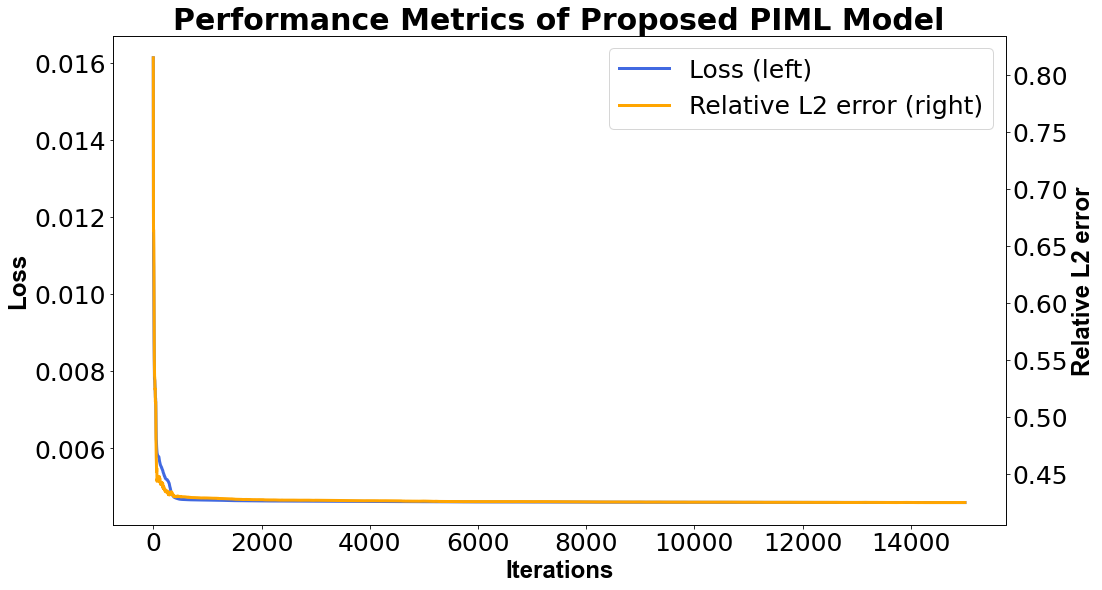

In [17]:
fig, ax1 = plt.subplots()
ax1 = plt.gca() 
ax1.set_facecolor('white')
ax2 = ax1.twinx()
line1 = ax1.plot(loss_record, linewidth = '3', color = "royalblue", label='Loss (left)')
line2 = ax2.plot(l2_record, linewidth = '3', color = "orange", label='Relative L2 error (right)')
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper right')
plt.title("Performance Metrics of Proposed PIML Model", fontsize=30, fontweight="bold")
ax1.set_xlabel("Iterations", fontsize=24, fontname = 'Arial', fontweight="bold")
ax1.set_ylabel("Loss", fontsize=24, fontname = 'Arial', fontweight="bold")
ax2.set_ylabel("Relative L2 error", fontsize=24, fontname = 'Arial', fontweight="bold")
fig.set_size_inches(16, 9)

# 전체 그리드 비교

In [18]:
u_pred = PINN.evaluate(X_u_grid)
u_pred = np.reshape(u_pred,usol.shape,order='F')

y_test = usol
y_pred = u_pred

error_vec = np.linalg.norm((y_test-y_pred),2)/np.linalg.norm(y_test,2)

print('MAE = ', mean_absolute_error(y_test, y_pred))
print('MSE = ', mean_squared_error(y_test, y_pred) )
print('RMSE = ', np.sqrt(mean_squared_error(y_test, y_pred)))
print('L2 relative error =', error_vec)
print('--------------------------------------------------')

MAE =  0.04075513368451974
MSE =  0.011439574191069918
RMSE =  0.10695594509455712
L2 relative error = 0.9281105708828178
--------------------------------------------------


Text(0, 0.5, 'Remaining Trip Distance (x 1 mile)')

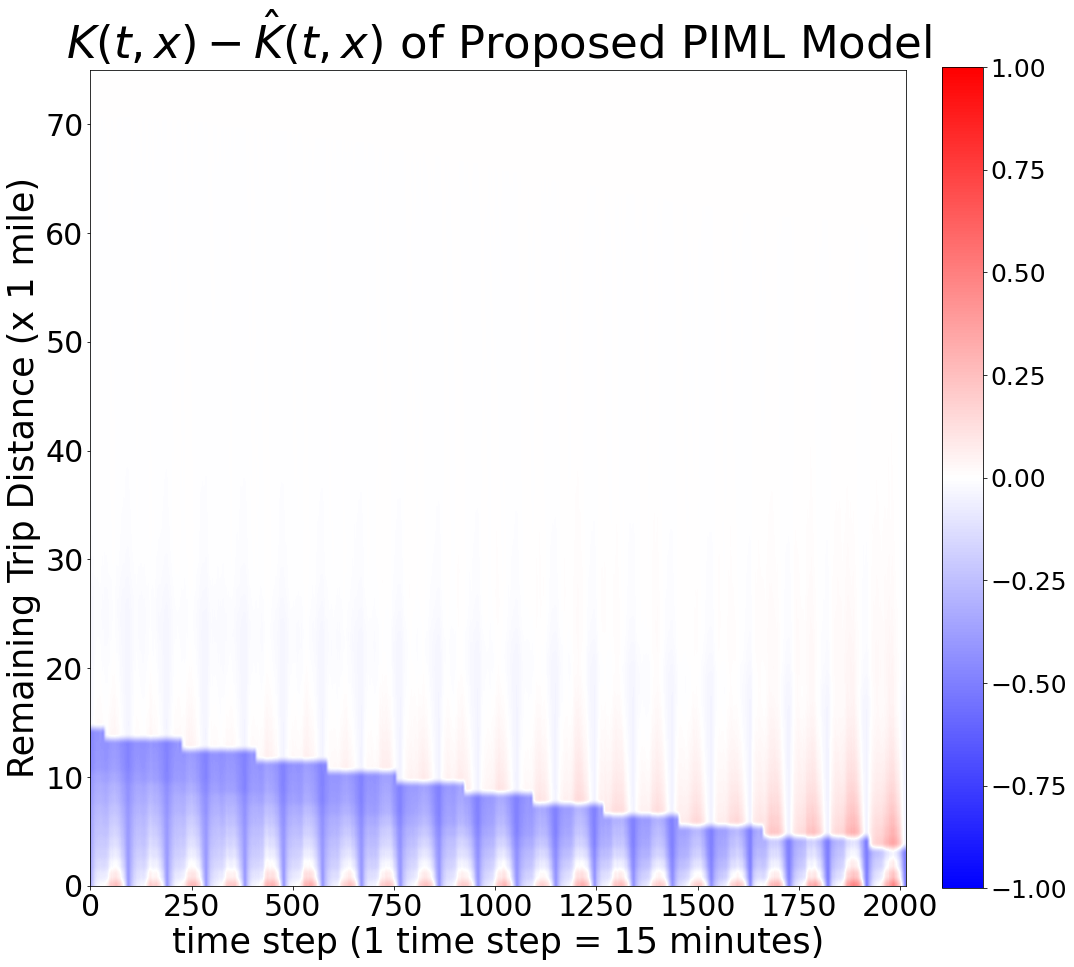

In [19]:
K_array = np.array(u_pred)
K_array = (usol - K_array)

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'bwr')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,75])
plt.clim(-1, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$K(t,x)- \hat{K}(t,x)$' ' of Proposed PIML Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)

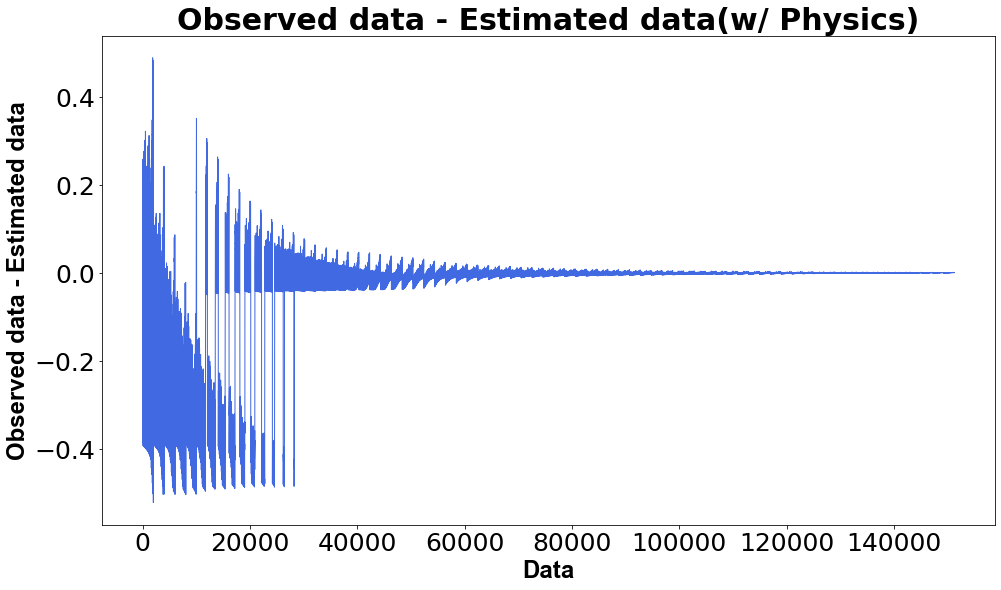

In [20]:
fig, ax1 = plt.subplots()
ax1 = plt.gca() 
ax1.set_facecolor('white')
ax1.plot(K_array.flatten(), linewidth = '1', color = "royalblue", label='Loss (left)')
plt.title("Observed data - Estimated data(w/ Physics)", fontsize=30, fontweight="bold")
ax1.set_xlabel("Data", fontsize=24, fontname = 'Arial', fontweight="bold")
ax1.set_ylabel("Observed data - Estimated data", fontsize=24, fontname = 'Arial', fontweight="bold")

fig.set_size_inches(16, 9)

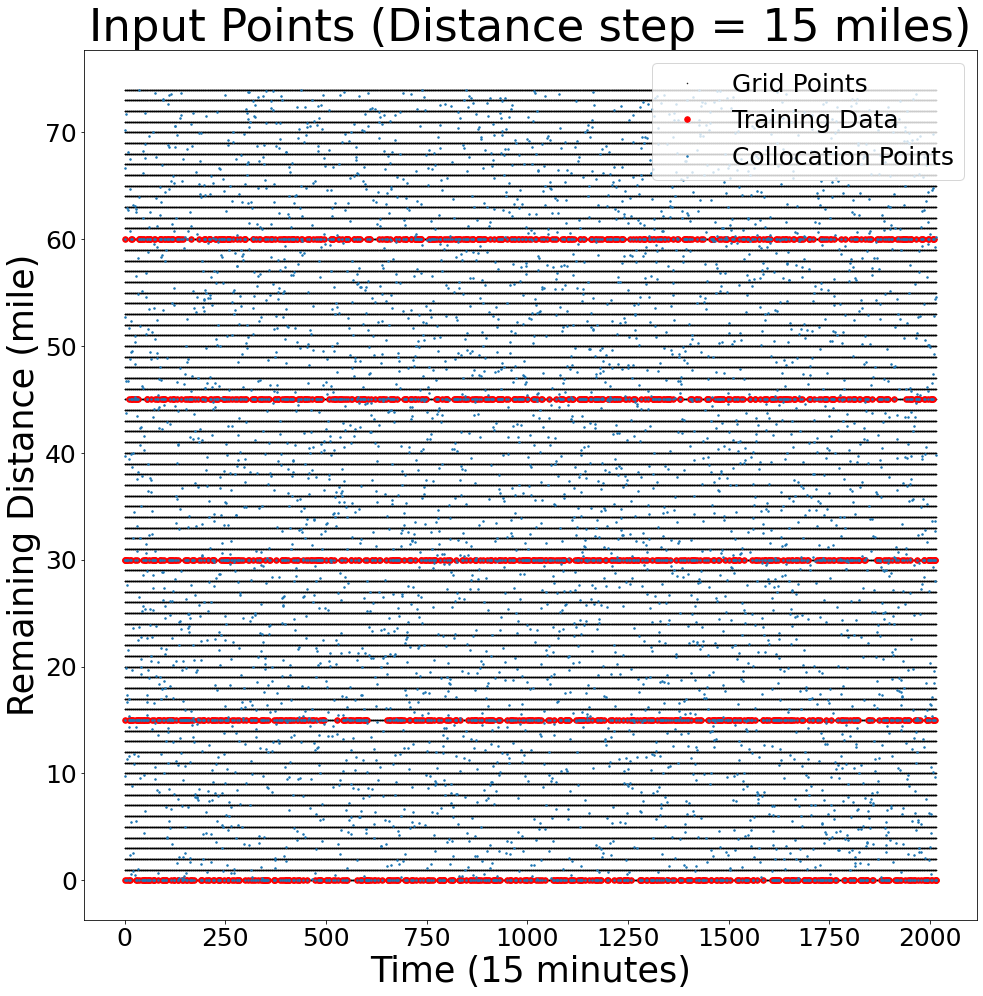

In [21]:
fig,ax = plt.subplots(figsize=(16, 16))
plt.plot(X_u_grid[:,1]*multiplier_time, X_u_grid[:,0]*multiplier_dist, 'o', color = 'black', markersize = 0.5, label = 'Grid Points')
plt.plot(X_u_train[:,1]*multiplier_time, X_u_train[:,0]*multiplier_dist, 'o', color = 'red', markersize = 5.5, label = 'Training Data')
plt.plot(X_f_train[:,1]*multiplier_time, X_f_train[:,0]*multiplier_dist, 'o', markersize = 1.5, label = 'Collocation Points')

plt.rcParams['font.size'] = '25'
plt.xlabel('Time (15 minutes)', fontsize=35)
plt.ylabel('Remaining Distance (mile)', fontsize=35)
plt.title('Input Points (Distance step = 15 miles)', fontsize=45)
plt.legend(loc='upper right')
plt.show()